In [1]:
#----- Trying to ensure reproducibility across systems (might not work for UMAP)
import numpy as np
import random
import os
import gc
seed=0
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)
os.environ['MKL_NUM_THREADS']="1"                                       
os.environ['OPENBLAS_NUM_THREADS']="1"                                  
os.environ['OMP_NUM_THREADS']="1"                                       
os.environ['NUMBA_NUM_THREADS']="1"    
os.environ['NUMBA_CPU_NAME']="generic"
os.environ['NUMBA_THREADING_LAYER']='workqueue'
#--------------------------------------------------------------------------------
from integration_utils import *
import stream2 as st2
sc.settings.figdir = "./figures/hematopoiesis/"

/home/jo/anaconda3/envs/stream2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Split into the 4 assays

In [ ]:
#ATAC
adata_ATAC = sc.read("../data/hematopoiesis/result_2b-ArchR_ATAC/Archr_imputed_log_gene_score.h5ad")
adata_ATAC.obs['label'] = adata_ATAC.obs['label'].copy().astype(str)
adata_ATAC.obs['label'][adata_ATAC.obs['label']=='CD34posCD33L']='CD34posCD33dim'
adata_ATAC.obs['label'][adata_ATAC.obs['label']=='CD34posCD33']='CD34posCD33neg'
adata_ATAC.obs['label'] = adata_ATAC.obs['label'].map(lambda s: s.split('y')[-1])
adata_ATAC_CD = adata_ATAC[np.isin(adata_ATAC.obs['label'],['CD33pos','CD34posCD33neg','CD34posCD33dim'])]
adata_ATAC_days = adata_ATAC[~np.isin(adata_ATAC.obs['label'],['CD33pos','CD34posCD33neg','CD34posCD33dim'])]
adata_ATAC_days.obs['label']=adata_ATAC_days.obs['label'].map(lambda s:s[1:])

#RNA
adata_RNA_days = sc.read('../data/hematopoiesis/result_1a-RNA_preprocessing/RNA_days.h5ad').raw.to_adata()
adata_RNA_CD = sc.read('../data/hematopoiesis/result_1a-RNA_preprocessing/RNA_CD.h5ad').raw.to_adata()
for a in [adata_RNA_days,adata_RNA_CD]:
    a.obs['label'] = a.obs['label'].map(lambda s: s.split('Day')[-1])

#join, clean up genes
adatas = [adata_ATAC_CD.copy(),adata_ATAC_days.copy(),adata_RNA_CD.copy(),adata_RNA_days.copy()]
names  = ['adata_ATAC_CD','adata_ATAC_days','adata_RNA_CD','adata_RNA_days']

%xdel adata_ATAC
%xdel adata_ATAC_CD
%xdel adata_ATAC_days
%xdel adata_RNA_CD
%xdel adata_RNA_days

#get hvg for all assays
for a in adatas:
    sc.pp.highly_variable_genes(a,min_mean=0.0125, max_mean=4, min_disp=0.5)
    
#intersection of expressed genes
common_genes = np.sort(list(set.intersection(*[set(a.var_names) for a in adatas])))
for i in range(len(adatas)): adatas[i] = adatas[i][:,common_genes].copy()
    
#union of variable genes
common_genes = np.sort(list(set.union(*[set(a.var_names[a.var.highly_variable]) for a in adatas])))
adatas_hvg_union = []
for i in range(len(adatas)): adatas_hvg_union.append(adatas[i][:,common_genes].copy())
    
#intersection of variable genes
common_genes = np.sort(list(set.intersection(*[set(a.var_names[a.var.highly_variable]) for a in adatas])))
adatas_hvg_inter = []
for i in range(len(adatas)): adatas_hvg_inter.append(adatas[i][:,common_genes].copy())
    

for _adatas in [adatas,adatas_hvg_union,adatas_hvg_inter]:
    for a in _adatas:
        if scipy.sparse.issparse(a.X):
            a.X = a.X.toarray()
        sc.pp.pca(a,n_comps=14,svd_solver='full')
        sc.pp.neighbors(a,metric='cosine')
        sc.tl.umap(a,min_dist=.1)

# Annotate

In [ ]:
###### ---disable annoying warnings
pd.options.mode.chained_assignment = None 

#---choose adatas to annotate
_adatas = adatas

################################
#### LOAD DETAILED MARKERS  ####
################################
print('loading markers...\n')

min_pearson_correlation=0.2
max_pval = 0.05

markers_dict_main, cell_types_main, marker_df_main = get_main_markers()
detailed_markers_HCA_all, markers_HCA_all, cell_types_HCA_all, marker_df_HCA_all, color_discrete_map_celltypes_HCA_all = get_marker_df_HCA_all(min_pearson_correlation, max_pval)
detailed_markers_HCA_main, markers_HCA_main, cell_types_HCA_main, marker_df_HCA_main, color_discrete_map_celltypes_HCA_main = get_marker_df_HCA_main(min_pearson_correlation, max_pval)
detailed_markers_PA, markers_PA, cell_types_PA, marker_df_PA, color_discrete_map_celltypes_PA = get_marker_df_PA()
(detailed_markers_diff_vitro_mature, detailed_markers_diff_vitro_day2, 
 detailed_markers_diff_vivo, detailed_markers_cell_types, detailed_markers_cell_types_early) = get_marker_lineage_tracing()

#--- harmonize things up
detailed_markers_cell_types_early=detailed_markers_cell_types_early[detailed_markers_cell_types_early['"-log10(adj. p-val)"']>4]
detailed_markers_cell_types_early['Symbol']=detailed_markers_cell_types_early['Symbol'].astype(str)
detailed_markers_cell_types_early['Cell State.1']=detailed_markers_cell_types_early['Cell State.1'].astype(str)

detailed_markers_diff_vitro_mature=pd.concat(detailed_markers_diff_vitro_mature)
detailed_markers_diff_vitro_mature=detailed_markers_diff_vitro_mature.reset_index().iloc[:,[0,2,3,4]]
detailed_markers_diff_vitro_mature.rename(columns={'level_0':'Cell State.1','Gene symbol':'Symbol'},inplace=1)
detailed_markers_diff_vitro_mature['Symbol']=detailed_markers_diff_vitro_mature['Symbol'].astype(str)
detailed_markers_diff_vitro_mature['Cell State.1']=detailed_markers_diff_vitro_mature['Cell State.1'].astype(str)
#detailed_markers_diff_vitro_mature=detailed_markers_diff_vitro_mature[detailed_markers_diff_vitro_mature['"log2(fold-enrichment)"']>2]

detailed_markers_diff_vivo=pd.concat(detailed_markers_diff_vivo).loc[list(detailed_markers_diff_vivo.keys())[2:]].reset_index()
detailed_markers_diff_vivo.rename(columns={"level_0":"Cell State.1","Gene symbol":"Symbol"},inplace=1)
detailed_markers_diff_vivo['Cell State.1']=detailed_markers_diff_vivo['Cell State.1'].map(lambda s: s.replace("human PB ",""))


##basophil annot
detailed_markers_baso_PA=detailed_markers_PA.copy()
detailed_markers_baso_PA['Cell State.1']=detailed_markers_baso_PA['Cell State']
detailed_markers_baso_PA = detailed_markers_baso_PA.loc[detailed_markers_baso_PA['Cell State.1']=='Basophil',['Symbol','Cell State.1']]

################################
### MAIN LINEAGES ANNOTATION ###
################################
print('annotating lineages...\n')

cell_types=os.listdir('../data/Protein_atlas_lineages/')

markers_PA = {} ; states = []
for ct in cell_types:
    markers_PA[ct] = pd.read_json(f'../data/Protein_atlas_lineages/{ct}')['Gene']
    states.append(np.repeat(ct[28:-5],len(markers_PA[ct])))
states = np.concatenate(states)

detailed_markers = pd.DataFrame({'Symbol':np.concatenate(list(markers_PA.values())),'Cell State':states})
markers = detailed_markers['Symbol'].unique()
cell_types = detailed_markers['Cell State'].unique()

marker_df = pd.DataFrame(0,index=markers,columns=cell_types)
for ct in cell_types:
    idx_ct = detailed_markers.loc[detailed_markers['Cell State']==ct,'Symbol']
    marker_df.loc[idx_ct,ct] = 1

common_genes = _adatas[0].var_names
dm_common = detailed_markers[np.isin(detailed_markers['Symbol'],list(common_genes))]

#--- annotate
annotate_adatas(names,_adatas,dm_common,ct_key='Cell State')

#--- search knn (to smooth)
print('\tsmoothing annotation...')

knn_indices = { n : NearestNeighbors(n_neighbors=10,metric='cosine').fit(a.obsm['X_pca']).kneighbors(a.obsm['X_pca'])[1]
               for n,a in zip(names,_adatas)}
for n,a in zip(names,_adatas): 
    a.obs['cell_ids_from_max_lineage']=a.obs['cell_ids_from_max'].copy()
    a.uns['detailed_gene_score_df_lineage']=a.uns['detailed_gene_score_df'].copy()
    a.uns['detailed_gene_score_df_lineage_smooth']=a.uns['detailed_gene_score_df'].copy()
    
    knnidx = knn_indices[n]
    for i,ix in enumerate(knnidx):
        a.uns['detailed_gene_score_df_lineage_smooth'].iloc[i] = a.uns['detailed_gene_score_df_lineage'].iloc[ix].mean(0)
    a.obs['cell_ids_from_max_lineage_smooth'] = a.uns['detailed_gene_score_df_lineage_smooth'].idxmax(axis=1).map(lambda s: s[:-6])

        
#################################
### MAIN CELL TYPE ANNOTATION ###
#################################
print('\nannotating main cell types...')

#--- select markers to use
detailed_markers = detailed_markers_HCA_main
markers = markers_HCA_main
color_discrete_map_celltypes = color_discrete_map_celltypes_HCA_main

#--- remove missing markers from marker df
common_genes = adatas[0].var_names
dm_common = detailed_markers[np.isin(detailed_markers['Symbol'],list(common_genes))]

#--- (optional) restrict to top n markers
n_top = 20
for ct in dm_common['Cell State.1'].unique():
    if len(dm_common[dm_common['Cell State.1']==ct]) > n_top:
        idx_outside_top = dm_common['Pearson rho'][dm_common['Cell State.1']==ct].sort_values()[::-1][n_top:].index
        dm_common = dm_common.loc[dm_common.index[~np.isin(dm_common.index,idx_outside_top)]]
    print(ct,len(dm_common[dm_common['Cell State.1']==ct]))

dm_common = pd.concat((dm_common,detailed_markers_baso_PA))

#--- annotate
annotate_adatas(names,_adatas,dm_common,ct_key='Cell State.1')

#--- smooth
print('\tsmoothing annotation...')
for n,a in zip(names,_adatas): 
    a.uns['detailed_gene_score_df_cell_types'] = a.uns['detailed_gene_score_df'].copy()
    a.uns['detailed_gene_score_df_cell_types_smooth']=a.uns['detailed_gene_score_df'].copy()
    knnidx = knn_indices[n]
    for i,ix in enumerate(knnidx):
        a.uns['detailed_gene_score_df_cell_types_smooth'].iloc[i] = a.uns['detailed_gene_score_df_cell_types'].iloc[ix].mean(0)
    a.obs['cell_ids_from_max_smooth'] = a.uns['detailed_gene_score_df_cell_types_smooth'].idxmax(axis=1).map(lambda s: s[:-6])

    
#--- consensus with PA lineage
print('\nforming consensus of lineage & main cell types...')
for a in _adatas:
    cell_ids_from_max_lin_corrected = np.array(a.obs['cell_ids_from_max_smooth']).astype(str)
    detailed_gene_score_df_cell_types_lin_corrected = np.array(a.uns['detailed_gene_score_df_cell_types_smooth']).copy()
    ix_mono = a.obs['cell_ids_from_max_smooth']=='Monocyte'

    mono_nn = NearestNeighbors(n_neighbors=10,metric='cosine').fit(a[ix_mono].obsm['X_pca'])
    for i in range(len(a)):
        label = a.obs['cell_ids_from_max_smooth'][i]
        lineage = a.obs['cell_ids_from_max_lineage_smooth'][i]
        neu_den = ['CD34+ Gran','Neutrophil','Pre-Dendritic','Dendritic Cell']
        if np.isin(label,neu_den) & (lineage == 'rna_monocytes_Lineage'):

            #correct max annot
            cell_ids_from_max_lin_corrected[i] = 'Monocyte'

            #correct prob vector
            ix=mono_nn.kneighbors(a.obsm['X_pca'][[0]])[1][0]
            detailed_gene_score_df_cell_types_lin_corrected[i] = a.uns['detailed_gene_score_df_cell_types_smooth'][ix_mono].iloc[ix].mean(0)       

    a.obs['cell_ids_from_max_lin_corrected'] = cell_ids_from_max_lin_corrected
    a.uns['detailed_gene_score_df_cell_types_lin_corrected']  = pd.DataFrame(detailed_gene_score_df_cell_types_lin_corrected,
                                                                             index=a.uns['detailed_gene_score_df_cell_types_smooth'].index,
                                                                            columns= a.uns['detailed_gene_score_df_cell_types_smooth'].columns)
        
#--- simplified annotation for integration
print('\ncreating simplified cell type annotation...')

for n,a in zip(names,_adatas): 
    ct_simple = np.array(a.obs['cell_ids_from_max_lin_corrected'])
    ct_simple[np.isin(ct_simple,['Early-ERP','Erythroblast','CD34+ ERP'])]='Erythroid'
    ct_simple[np.isin(ct_simple,['Platelet','CD34+ MKP'])]='MKP'
    ct_simple[np.isin(ct_simple,['Pre-Dendritic','Dendritic Cell'])]='Dendritic'
    ct_simple[np.isin(ct_simple,['CD34+ CLP','CD34+ pre-B','Pro-B','Plasma Cell', 'NK cells','Naive T-cell','CD8 T-cell'])]='Lymphoid'
    ct_simple[np.isin(ct_simple,['CD34+ Mixed-Lineage', 'CD34+ HSC','CD34+ CMP', 'CD34+ Gran', 'Eosinophil','Stromal Cells',])]= 'Mixed progenitors'
    if n=='adata_ATAC_days':
        ct_simple[(ct_simple=='Erythroid') & np.isin(a.obs['label'],['7','12'])]="Mixed progenitors" #correct wrong late erythroid annotation for atac_days
    a.obs['cell_ids_from_max_lin_corrected_simple']=ct_simple

#--- smooth by clustering and voting
print('\tsmoothing annotation...')

for n,a in zip(names,_adatas): 
    r = .9 if n!='adata_ATAC_days' else .7
    sc.tl.leiden(a,resolution=r)
    a.uns['detailed_gene_score_df_cell_types_lin_corrected_leiden']=a.uns['detailed_gene_score_df_cell_types_lin_corrected'].copy()
    a.obs['leiden_identity'] = a.obs['leiden'].astype(str)
    a.obs['leiden_identity_simple'] = a.obs['leiden'].astype(str)

    for i,u in enumerate(a.obs['leiden'].unique()):
        ix = a.obs['leiden']==u
        a.obs['leiden_identity'][ix] = a.obs['cell_ids_from_max_lin_corrected'][ix].mode()[0]
        a.obs['leiden_identity_simple'][ix] = a.obs['cell_ids_from_max_lin_corrected_simple'][ix].mode()[0]
        a.uns['detailed_gene_score_df_cell_types_lin_corrected_leiden'][ix] = a.uns['detailed_gene_score_df_cell_types_lin_corrected'][ix].mean(0)
        
#---- manual annotation refinement
print('\trefining annotation...')
for n,a in zip(names,_adatas): 
    leiden_identity=np.array(a.obs['leiden_identity']).astype(str)
    leiden_identity_simple=np.array(a.obs['leiden_identity_simple']).astype(str)
    
    # Ignore unreliable Eosinophil annotation
    leiden_identity[a.obs['leiden_identity']=='Eosinophil']='CD34+ Gran' 
    # Restore HSC annotation oversmoothed by clustering
    leiden_identity[a.obs['cell_ids_from_max_lin_corrected']=='CD34+ HSC']='CD34+ HSC'
    # Restore B-cells oversmoothed by clustering
    leiden_identity_simple[np.isin(a.obs['leiden_identity'],['CD34+ pre-B','Pro-B'])]='Lymphoid'
    a.obs['leiden_identity']=leiden_identity
    a.obs['leiden_identity_simple']=leiden_identity_simple
    
#--- smooth by cutpursuit
#import cutpursuit
#for _filter,_adatas in zip(['expressed',],[adatas,]):
#    for a in _adatas:
#        a.obs['encoded_labels']=encoded_labels=np.array(pd.get_dummies(a.obs['cell_ids_from_max_lin_corrected'])).argmax(1).astype(float)
#        y_sx = scipy.special.softmax(np.array(a.uns['detailed_gene_score_df_cell_types_lin_corrected']),1).T.copy('F')
#        Comp, rX = cutpursuit.cp_pfdr_d1_lsx(1,y_sx,
#                                  a.obsp['connectivities'].indptr.astype("uint32"),
#                                  a.obsp['connectivities'].indices.astype("uint32"),
#                                  edge_weights=.01)
#        plt.hist(Comp,bins=100);plt.show()
#        a.uns['detailed_gene_score_df_cell_types_lin_corrected_cut_pursuit']=a.uns['detailed_gene_score_df_cell_types_lin_corrected'].copy()
#        a.uns['detailed_gene_score_df_cell_types_lin_corrected_cut_pursuit'][:]=rX[:,Comp].T
#        a.obs['cell_ids_from_max_lin_corrected_cut_pursuit']=a.uns['detailed_gene_score_df_cell_types_lin_corrected'].columns[rX[:,Comp].argmax(axis=0)]
#        a.obs['cell_ids_from_max_lin_corrected_confidence'] = scipy.stats.entropy(y_sx,axis=0)
        
    
    
#########################################
### MONO/DENDRITIC SUBTYPE ANNOTATION ###
#########################################

#------prepare marker lists
common_genes = adatas[0].var_names
dms = {}
for name,df in zip(["mono_neutro_dc_vitro","mono_neutro_dc_vivo"],
              [detailed_markers_diff_vitro_mature,detailed_markers_diff_vivo]):
    dm_common = df[np.isin(df['Symbol'].map(lambda s:s.upper()),common_genes)]
    dm_common['Symbol']=dm_common['Symbol'].apply(lambda s: s.upper())

    #--- (optional) restrict to top n
    n_top=50
    for ct in dm_common['Cell State.1'].unique():
        if len(dm_common[dm_common['Cell State.1']==ct]) > n_top:
            idx_outside_top = dm_common['"log2(fold-enrichment)"'][dm_common['Cell State.1']==ct].sort_values()[::-1][n_top:].index
            dm_common = dm_common.loc[dm_common.index[~np.isin(dm_common.index,idx_outside_top)]]
        print(ct,len(dm_common[dm_common['Cell State.1']==ct]))
    dms[name]=dm_common.copy()

dms['mono_neutro_dc_vivo_plus_vitro']=pd.concat(list(dms.values()))
dms['mono_subtypes'] = detailed_markers_PA[  np.isin(detailed_markers_PA['Symbol'],list(common_genes)) 
                                              & np.isin(detailed_markers_PA['Cell State'],['Classical monocyte','Intermediate monocyte', 'Non-classical monocyte'])
                                             ]

#--------- annotate monocyte subtypes
print('\nannotating monocyte subtypes...\n')
adatas_mono=[a[a.obs['leiden_identity_simple']=='Monocyte'].copy() for a in adatas]
keys = ['mono_neutro_dc_vitro','mono_neutro_dc_vivo','mono_neutro_dc_vivo_plus_vitro','mono_subtypes']
mono_knn_indices = { n : NearestNeighbors(n_neighbors=10,metric='cosine').fit(a_m.obsm['X_pca']).kneighbors(a_m.obsm['X_pca'])[1]
               for n,a_m in zip(names,adatas_mono)}

for k,df_markers in dms.items():
    print(f'\t{k} annotation...')
    ct_key = 'Cell State.1' if k!='mono_subtypes' else 'Cell State'
    annotate_adatas(names,adatas_mono,df_markers,ct_key=ct_key)
    for n,a,a_m in zip(names,adatas,adatas_mono):
        mono_ix = a.obs['leiden_identity_simple']=='Monocyte'
        a.obs[f'cell_ids_from_max_{k}']='nan'
        a.obs[f'cell_ids_from_max_{k}'][mono_ix]=a_m.obs['cell_ids_from_max']

        a.uns[f'detailed_gene_score_df_{k}'] = a_m.uns['detailed_gene_score_df'].copy()
        a.uns[f'detailed_gene_score_df_{k}_smooth']=a_m.uns['detailed_gene_score_df'].copy()
        knnidx = mono_knn_indices[n]
        for i,ix in enumerate(knnidx):
            a.uns[f'detailed_gene_score_df_{k}_smooth'].iloc[i] = a.uns[f'detailed_gene_score_df_{k}'].iloc[ix].mean(0)
        a.obs[f'cell_ids_from_max_{k}_smooth'] = a.uns[f'detailed_gene_score_df_{k}_smooth'].idxmax(axis=1).map(lambda s: s[:-6])


#--- annotate dendritic subtypes
print('\nannotating dendritic subtypes...')
adatas_dendritic=[a[a.obs['leiden_identity_simple']=='Dendritic'].copy() for a in adatas]
dms['dendritic_subtypes'] = detailed_markers_PA[  np.isin(detailed_markers_PA['Symbol'],list(common_genes)) 
                                              & np.isin(detailed_markers_PA['Cell State'],['Myeloid DC', 'Plasmacytoid DC'])
                                             ]
annotate_adatas(names,
                [a for a in adatas_dendritic if sum(a.obs['leiden_identity_simple']=='Dendritic')], #prevent 0 cell error if no dendritic cells
                dms['dendritic_subtypes'],ct_key='Cell State')

k="dendritic_subtypes"
df_markers = dms[k]
for a,a_d in zip(adatas,adatas_dendritic):
    if len(a_d) == 0:
        continue
        
    den_ix = a.obs['leiden_identity_simple']=='Dendritic'
    a.obs[f'cell_ids_from_max_{k}']='nan'
    a.obs[f'cell_ids_from_max_{k}'][den_ix]=a_d.obs['cell_ids_from_max']
    a.uns[f'detailed_gene_score_df_{k}'] = a_d.uns['detailed_gene_score_df'].copy()
    a.uns[f'detailed_gene_score_df_{k}_smooth']=a_d.uns['detailed_gene_score_df'].copy()
    knnidx = NearestNeighbors(n_neighbors=10,metric='cosine').fit(a[den_ix].obsm['X_pca']).kneighbors(a[den_ix].obsm['X_pca'])[1]
    for i,ix in enumerate(knnidx):
        a.uns[f'detailed_gene_score_df_{k}_smooth'].iloc[i] = a.uns[f'detailed_gene_score_df_{k}'].iloc[ix].mean(0)
    a.obs[f'cell_ids_from_max_{k}_smooth'] = a.uns[f'detailed_gene_score_df_{k}_smooth'].idxmax(axis=1).map(lambda s: s[:-6])
    

#--------- update
print('\nupdating simplified annotation with subtypes...')
for n,a in zip(names,adatas):
    leiden_identity2=np.array(a.obs['leiden_identity_simple'].astype(str))
    if 'CD' in n:
        leiden_identity2[a.obs['leiden_identity_simple']=='Monocyte']=a.obs['cell_ids_from_max_mono_neutro_dc_vivo_smooth'][a.obs['leiden_identity_simple']=='Monocyte']
    else:
        leiden_identity2[a.obs['leiden_identity_simple']=='Monocyte']=a.obs['cell_ids_from_max_mono_neutro_dc_vitro_smooth'][a.obs['leiden_identity_simple']=='Monocyte']
    if sum(a.obs['leiden_identity_simple']=='Dendritic'):
        leiden_identity2[a.obs['leiden_identity_simple']=='Dendritic']=a.obs['cell_ids_from_max_dendritic_subtypes_smooth'][a.obs['leiden_identity_simple']=='Dendritic']
    a.obs['leiden_identity_simple2']=leiden_identity2
    
#--- join 
print('\njoining lymphoid and basophil annotation for supervised integration...')
for a in adatas:
    leiden_identity_simple=np.array(a.obs['leiden_identity_simple'].astype(str))
    leiden_identity_simple[np.isin(leiden_identity_simple,['Lymphoid','Basophil'])]='Lymphoid/Basophil'
    a.obs['leiden_identity_simple']=leiden_identity_simple.copy()
    
pd.options.mode.chained_assignment = 'warn' 

# Save

In [ ]:
for i in range(4):
    n=names[i]
    adatas_hvg_inter[i].obs=adatas[i].obs.copy()
    adatas_hvg_union[i].obs=adatas[i].obs.copy()
    
    adatas[i].write(f'../data/hematopoiesis/result_2-Integration/inter_{n}.h5ad')
    adatas_hvg_union[i].write(f'../data/hematopoiesis/result_2-Integration/union_hvg_{n}.h5ad')
    adatas_hvg_inter[i].write(f'../data/hematopoiesis/result_2-Integration/inter_hvg_{n}.h5ad')

# Read

In [4]:
names = ['adata_ATAC_CD','adata_ATAC_days','adata_RNA_CD','adata_RNA_days']
names_plot = ['ATAC sorted','ATAC timepoints','RNA sorted','RNA timepoints']
adatas, adatas_hvg_union, adatas_hvg_inter = [], [], []
for n in names:
    adatas.append(sc.read(f'../data/hematopoiesis/result_2-Integration/inter_{n}.h5ad'))
    adatas_hvg_union.append(sc.read(f'../data/hematopoiesis/result_2-Integration/union_hvg_{n}.h5ad'))
    adatas_hvg_inter.append(sc.read(f'../data/hematopoiesis/result_2-Integration/inter_hvg_{n}.h5ad'))

# Visualize cell types relationships and proportions

In [ ]:
#proportions
sc.settings.autoshow=False

for key in ['label','leiden_identity','leiden_identity_simple','leiden_identity_simple2','cell_ids_from_max_lin_corrected','cell_ids_from_max_lin_corrected_simple']:
    ulabels = np.unique(np.concatenate([a.obs[key] for a in adatas]))
    
    if len(ulabels)<=20:
        colors = sc.pl._utils.palettes.default_20
    else:
        colors = sc.pl._utils.palettes.default_28

    palette = dict(zip(ulabels,colors))
    
    f,axs=plt.subplots(2,2,figsize=(12,8))
    axs=axs.flat
    for n,a in zip(names_plot,adatas_hvg_inter): 
        ax=next(axs)
        if key=='label'and 'timepoints' in n:
            cols = sns.palettes.color_palette('viridis',n_colors=len(np.unique(a.obs[key])))
            pal = dict(zip(a.obs['label'].cat.categories,cols))
            sc.pl.umap(a,color=key,s=5,ax=ax,palette=pal)
        else:
            sc.pl.umap(a,color=key,s=5,ax=ax,palette=palette)
        ax.set_xlabel('UMAP1',fontsize=20)
        ax.set_ylabel('UMAP2',fontsize=20)
        ax.set_title(n,fontsize=25)
    plt.tight_layout()
    plt.savefig(f'figures/hematopoiesis/{key}.png',dpi=300,bbox_inches='tight')
    plt.show()

    f,axs=plt.subplots(2,2,figsize=(15,8))
    axs=axs.flat
    for n,a in zip(names,adatas_hvg_inter): 
        ax=next(axs)

        df=pd.get_dummies(a.obs[key])
        dfall=pd.DataFrame(index=df.index,columns=ulabels)
        dfall[df.columns]=df
        if key=='label':
            if 'days' in n:
                cols = sns.palettes.color_palette('viridis',n_colors=len(np.unique(a.obs[key])))
                pal = dict(zip(a.obs['label'].cat.categories,cols))
            else:
                pal=palette
            sns.barplot(data=dfall[a.obs['label'].cat.categories],orient='h',ax=ax,palette=pal)
        else:
            sns.barplot(data=dfall,orient='h',ax=ax,palette=palette)
        ax.set_title(n[6:])
    plt.tight_layout()
    plt.savefig(f'figures/hematopoiesis/{key}_proportions.png',dpi=300,bbox_inches='tight')
    plt.show()

In [ ]:
#relationships

for a in adatas:
    class_vecs = a.uns['detailed_gene_score_df_cell_types'].T

    #--- based on centroid distance
    centers=np.zeros((len(class_vecs),a.obsm['X_pca'].shape[1]))
    for i,c in enumerate(class_vecs.index):
        centers[i] = a[a.obs['cell_ids_from_max_lin_corrected']==c[:-6]].obsm['X_pca'].mean(0)
    D = pd.DataFrame(index=class_vecs.index,columns=class_vecs.index,dtype=float)
    for i,j in np.array(np.triu_indices(len(class_vecs))).T:
        D.iloc[i,j]=D.iloc[j,i]=scipy.spatial.distance.cosine(centers[i],centers[j])
    
    #--- based on k-centroid minimum distance
    #class_vecs = np.unique(np.hstack([a.obs['leiden_identity_simple'] for a in adatas]))
    #
    #centers=[]
    #for i,c in enumerate(class_vecs):
    #    centers.append(sklearn.cluster.KMeans(20).fit(a[a.obs['leiden_identity_simple']==c].obsm['X_pca']).cluster_centers_)
    #D = pd.DataFrame(index=class_vecs,columns=class_vecs,dtype=float)
    #for i,j in np.array(np.triu_indices(len(class_vecs))).T:
    #    D.iloc[i,j]=D.iloc[j,i]=sklearn.metrics.pairwise_distances(centers[i],centers[j],metric='cosine').min()

    #--- based on gene score distance
    D = pd.DataFrame(index=class_vecs.index,columns=class_vecs.index,dtype=float)
    for i,j in np.array(np.triu_indices(len(class_vecs))).T:
        #D.iloc[i,j]=D.iloc[j,i]=scipy.spatial.distance.cosine(class_vecs.iloc[i],class_vecs.iloc[j])
        D.iloc[i,j]=D.iloc[j,i]=scipy.spatial.distance.jensenshannon(scipy.special.softmax(class_vecs.iloc[i]),scipy.special.softmax(class_vecs.iloc[j]))
        
    #--- based on intra-class gene score distance
    #D = pd.DataFrame(index=class_vecs.index,columns=class_vecs.index,dtype=float)
    #for i,j in np.array(np.triu_indices(len(class_vecs))).T:
    #    ixi=np.where(a.obs['cell_ids_from_max_smooth']==class_vecs.index[i][:-6])[0]
    #    ixj=np.where(a.obs['cell_ids_from_max_smooth']==class_vecs.index[i][:-6])[0]
    #    if not len(ixi):
    #        pass
    #    else:
    #        D.iloc[i,j]=scipy.spatial.distance.jensenshannon(scipy.special.softmax(class_vecs.iloc[i,ixi]),scipy.special.softmax(class_vecs.iloc[j,ixi]))
    #    if not len(ixj):
    #        pass
    #    else:
    #        D.iloc[j,i]=scipy.spatial.distance.jensenshannon(scipy.special.softmax(class_vecs.iloc[i,ixj]),scipy.special.softmax(class_vecs.iloc[j,ixj]))

        #D.iloc[i,j]=D.iloc[j,i]=scipy.spatial.distance.cosine(class_vecs.iloc[i],class_vecs.iloc[j])
        
    #--- clustermap
    #D/=D.max()
    D[np.isnan(D)]=np.nanmax(D)
    i,j=np.array(np.triu_indices_from(D,k=1))
    distLinkage = scipy.cluster.hierarchy.linkage(D.to_numpy()[i,j])
    sns.clustermap(D, row_linkage=distLinkage, col_linkage=distLinkage,)
    
    plt.tight_layout()
    #plt.savefig(f'../../git/PHD_THESIS/images/stream2/{key}_proportions.png',dpi=300,bbox_inches='tight')
    plt.show()

In [ ]:
#confidence (entropy)

#for a in adatas:
#    a.uns['cell_ids_from_max_lin_corrected_confidence'] = pd.Series(index=a.obs['cell_ids_from_max_lin_corrected'].unique(),dtype=float)
#    for ct in a.uns['cell_ids_from_max_lin_corrected_confidence'].index:
#        ix = a.obs['cell_ids_from_max_lin_corrected']==ct   
#        a.uns['cell_ids_from_max_lin_corrected_confidence'][ct] = a.obs['cell_ids_from_max_lin_corrected_confidence'][ix].mean(0)
#        
#df=pd.concat([a.uns['cell_ids_from_max_lin_corrected_confidence'] for a in adatas],axis=1)
#df[np.isnan(df)]=np.nanmax(df)
#df=df.sort_values(list(df.columns),ascending=False)
#plt.figure(figsize=(10,10))
#sns.clustermap(df)

In [7]:
for key in ['leiden_identity_simple2']:
    for n,a in zip(names,adatas_hvg_inter): 
        sc.tl.dendrogram(a,groupby='leiden_identity_simple2')
        sc.pl.correlation_matrix(a,groupby='leiden_identity_simple2',dendrogram=True,
                                save=f'_{key}_{n}.png',
                                 )

In [8]:
for a in adatas_hvg_union:
    sc.tl.rank_genes_groups(a,groupby='leiden_identity_simple2',method='wilcoxon',
                            key_added=f'leiden_identity_simple2_markers')
for n,a in zip(names,adatas_hvg_union):
    sc.pl.rank_genes_groups(a,key=f'leiden_identity_simple2_markers',save=f'_{n}.png')

# Data integration - linear

In [ ]:
n_comps = 14
target = -1

for _adatas in [adatas,adatas_hvg_union,adatas_hvg_inter]:
    #pca
    skpca = sklearn.decomposition.PCA(n_comps,svd_solver='arpack',random_state=0).fit(_adatas[target].X)
    _adatas[target].obsm['X_pca_target'] = skpca.transform(_adatas[target].X)
    print('pca done...')

    #linear transport correction
    for n,a in zip(names[:-1],_adatas[:-1]):
        xs=a.obsm['X_pca_target']=skpca.transform(a.X)
        
        if n!='adata_ATAC_days':
            xt = _adatas[target].obsm['X_pca_target'][_adatas[target].obs['label']!='11_Fresh']
        else:
            xt = _adatas[target].obsm['X_pca_target']

        Ae, be = ot.da.OT_mapping_linear(xs,xt,bias=True)
        a.obsm['X_pca_transp'] = xs.dot(Ae) + be
        print('\tlinear mapping done...')

## Visualize linear integration

In [ ]:
target = -1

embs_baseline = []
embs = []
embedder = umap.UMAP(metric='cosine',random_state=0)
for _adatas in [adatas,adatas_hvg_union,adatas_hvg_inter]:
    
    X_pca_target = np.vstack([a.obsm['X_pca_target'] for a in _adatas])
    embs_baseline.append(embedder.fit_transform(X_pca_target))
    
    X_pca_transp = np.vstack([a.obsm['X_pca_transp'] for a in _adatas[:-1]]+[_adatas[target].obsm['X_pca_target']])
    embs.append(embedder.fit_transform(X_pca_transp))
    
ix_assay = np.append(0,np.cumsum([len(a) for a in adatas]))

f,axs=plt.subplots(1,3,figsize=(15,5))
#plt.suptitle('Assays projected to the same PCA subspace')
for i,title,_adatas in zip(range(4),['Intersection of expressed genes','Union of variable genes',
                            'Intersection of variable genes'],[adatas,adatas_hvg_union,adatas_hvg_inter]):
    
    for j in range(4):
        _=axs[i].scatter(*embs_baseline[i][ix_assay[j]:ix_assay[j+1]].T,alpha=.1,s=.4,label=names[j][6:])
        
    axs[i].set_title(title)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xlabel('UMAP1')
    axs[i].set_ylabel('UMAP2')
    
    handles, labels = axs[i].get_legend_handles_labels()
    lgnd = f.legend(handles, labels, bbox_to_anchor=(1.1, .55), scatterpoints=1, fontsize=10)
    for handle in lgnd.legendHandles:
        handle.set_sizes([100.0])
        handle.set_alpha(1)
plt.tight_layout()
#plt.savefig(f'../../git/PHD_THESIS/images/stream2/assays_RNA_days_subspace.png',dpi=300,bbox_inches='tight')
plt.show()

############################


f,axs=plt.subplots(1,3,figsize=(15,5))
#plt.suptitle('Assays projected to the same PCA subspace and aligned to RNA_days')
for i,title,_adatas in zip(range(4),['Intersection of expressed genes','Union of variable genes',
                            'Intersection of variable genes'],[adatas,adatas_hvg_union,adatas_hvg_inter]):
    
    for j in range(4):
        _=axs[i].scatter(*embs[i][ix_assay[j]:ix_assay[j+1]].T,alpha=.1,s=.4,label=names[j][6:])
         
    axs[i].set_title(title)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xlabel('UMAP1')
    axs[i].set_ylabel('UMAP2')
    
    handles, labels = axs[i].get_legend_handles_labels()
    lgnd = f.legend(handles, labels, bbox_to_anchor=(1.1, .55), scatterpoints=1, fontsize=10)
    for handle in lgnd.legendHandles:
        handle.set_sizes([100.0])
        handle.set_alpha(1)
plt.tight_layout()
stitle=title.replace(' ','_')
#plt.savefig(f'../../git/PHD_THESIS/images/stream2/assays_RNA_days_subspace_aligned.png',dpi=300,bbox_inches='tight')
plt.show()

############################


sc.settings.autoshow=False
key='leiden_identity_simple2'

for i,title,_adatas in zip(range(4),['Intersection of expressed genes','Union of variable genes',
                            'Intersection of variable genes'],[adatas,adatas_hvg_union,adatas_hvg_inter]):
    
    ulabels = np.unique(np.concatenate([a.obs[key] for a in _adatas]))
    colors = sc.pl._utils.palettes.default_20
    palette = dict(zip(ulabels,colors))
    
    f,axs=plt.subplots(2,2,figsize=(15,10))
    axs=axs.flat
    #plt.suptitle(f'{title}\nAssays projected to the same PCA subspace\n')
    for j,a in enumerate(_adatas):
        ax=next(axs)
        a.obsm['X_umap_baseline']=embs_baseline[i][ix_assay[j]:ix_assay[j+1]]
        sc.pl.embedding(a,basis='X_umap_baseline',color=key,palette=palette,ax=ax)
        ax.set_title(names[j][6:])
    plt.tight_layout()
    stitle=title.replace(' ','_')
    #plt.savefig(f'../../git/PHD_THESIS/images/stream2/assays_RNA_days_subspace_{stitle}_{key}.png',dpi=300,bbox_inches='tight')
    plt.show()

    ####################

    f,axs=plt.subplots(2,2,figsize=(15,10))
    axs=axs.flat
    #plt.suptitle(f'{title}\nAssays projected to the same PCA subspace and aligned to RNA_days\n')
    for j,a in enumerate(_adatas):
        ax=next(axs)
        a.obsm['X_umap_pca_transp']=embs[i][ix_assay[j]:ix_assay[j+1]]
        sc.pl.embedding(a,basis='X_umap_pca_transp',color=key,palette=palette,ax=ax)
        ax.set_title(names[j][6:])
    plt.tight_layout()
    stitle=title.replace(' ','_')
    #plt.savefig(f'../../git/PHD_THESIS/images/stream2/assays_RNA_days_subspace_aligned_{stitle}_{key}.png',dpi=300,bbox_inches='tight')
    plt.show()

In [ ]:
target = -1

#embs_baseline = []
#embs = []
#embedder = umap.UMAP(metric='cosine',random_state=0)
#for _adatas in [adatas_hvg_inter]:
#    
#    X_pca_target = np.vstack([a.obsm['X_pca_target'] for a in _adatas])
#    embs_baseline.append(embedder.fit_transform(X_pca_target))
#    
#    X_pca_transp = np.vstack([a.obsm['X_pca_transp'] for a in _adatas[:-1]]+[_adatas[target].obsm['X_pca_target']])
#    embs.append(embedder.fit_transform(X_pca_transp))
#    
#adata_transp = sc.read(f'../data/hematopoiesis/result_2-Integration/adata_transp_final_leiden_identity_simple.h5ad')
embs_emd = [adata_transp.obsm['X_umap_w_nodes']]

f,axs=plt.subplots(3,1,figsize=(5,15))
#plt.suptitle('Assays projected to the same PCA subspace and aligned to RNA_days')
for i,title,embs_ in zip(range(4),['Before integration','Linear OT','OT'],[embs_baseline,embs,embs_emd]):
    
    for j in np.arange(4)[::-1]:
        _=axs[i].scatter(*embs_[0][ix_assay[j]:ix_assay[j+1]].T,alpha=.5,s=.01,label=names_plot[j])
         
    axs[i].set_title(title,fontsize=20)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xlabel('UMAP1',fontsize=20)
    axs[i].set_ylabel('UMAP2',fontsize=20)
    
    handles, labels = axs[i].get_legend_handles_labels()
    lgnd = f.legend(handles, labels, bbox_to_anchor=(1.65, .55), scatterpoints=1, fontsize=18,frameon=False, )
    for handle in lgnd.legendHandles:
        handle.set_sizes([100.0])
        handle.set_alpha(1)
plt.tight_layout()
stitle=title.replace(' ','_')
plt.savefig(f'figures/hematopoiesis/assays_RNA_days_subspace_aligned.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
key = 'leiden_identity_simple2'

adatas_hvg_inter[-1].obsm['X_pca_transp_emd']=adatas_hvg_inter[-1].obsm['X_pca_transp']=adatas_hvg_inter[-1].obsm['X_pca_target']

for data_key in ['X_pca_target','X_pca_transp','X_pca_transp_emd']:
    
    pseudobulk = {}
    for n,a in zip(names,adatas_hvg_inter):
        pseudobulk[n] = pd.DataFrame({u: a[a.obs[key]==u].obsm[data_key].mean(0) for u in a.obs[key].unique()})

    cats = np.unique(np.concatenate([df_.columns for df_ in pseudobulk.values()]))

    f,axs=plt.subplots(2,3,figsize=(15,9),)
    cbar_ax = f.add_axes([.91, .3, .03, .4])

    axs=axs.flat

    for i in range(len(names)-1):
        for j in range(i+1,len(names)):
            ax=next(axs)

            df1=pseudobulk[names[i]].copy()
            df2=pseudobulk[names[j]].copy()


            df1.columns=df1.columns.map(lambda s:s+' '+names[i][6:])
            df2.columns=df2.columns.map(lambda s:s+' '+names[j][6:])
            df=pd.concat((df1,df2),axis=1)

            corrs = df.corr().loc[sorted(df1.columns, key=str.lower),sorted(df2.columns, key=str.lower)]
            corrs.index=corrs.index.map(lambda s: s[:-len(names[i][6:])-1])
            corrs.columns=corrs.columns.map(lambda s: s[:-len(names[j][6:])-1])

            corrs_all = pd.DataFrame(index=['label']+list(cats),columns=['label']+list(cats))
            corrs_all.loc[corrs.index,corrs.columns]=corrs
            corrs_all.iloc[1:,0]=corrs_all.iloc[0,1:]=range(corrs_all.shape[0]-1)
            mask=corrs_all.copy()
            mask[:]=True
            mask.iloc[1:,0]=mask.iloc[0,1:]=False      

            colors = sc.pl._utils.palettes.default_20[:len(cats)]
            palette = dict(zip(map(str, cats), colors))

            _=sns.heatmap(corrs_all.astype(float),mask=corrs_all.isnull(),cmap='coolwarm',ax=ax,vmin=-1,vmax=1,cbar=True,
                         cbar_ax=cbar_ax,linewidths=.1, linecolor='white')
            _=sns.heatmap(corrs_all.astype(float), mask=mask, cmap=list(palette.values()), square=True, annot=False, cbar=False, ax=ax,
                         yticklabels=False,xticklabels=False,linewidths=.1, linecolor='white')
            ax.set_xlabel(names_plot[i],fontsize=20)
            ax.set_ylabel(names_plot[j],fontsize=20)  
            ax.tick_params(left=False, bottom=False)
            ax.axhline(1,c='k')
            ax.axvline(1,c='k')

    plt.subplots_adjust(wspace=0, hspace=0.2)
    from matplotlib.patches import Patch
    custom_lines = [Patch(color=c) for c in colors]
    plt.legend(custom_lines, palette.keys(),loc='upper center', bbox_to_anchor=(-12, 1.7),frameon=False,ncol=5)

    #plt.tight_layout(h_pad=3, w_pad=3)
    plt.savefig(f'figures/hematopoiesis/assays_{data_key}_{key}.png',dpi=300,bbox_inches='tight')
    plt.show()

# Data integration - supervised OT 

In [10]:
_adatas = adatas_hvg_inter
cluster_key = 'leiden_identity_simple'
n_comps = 14
target = -1

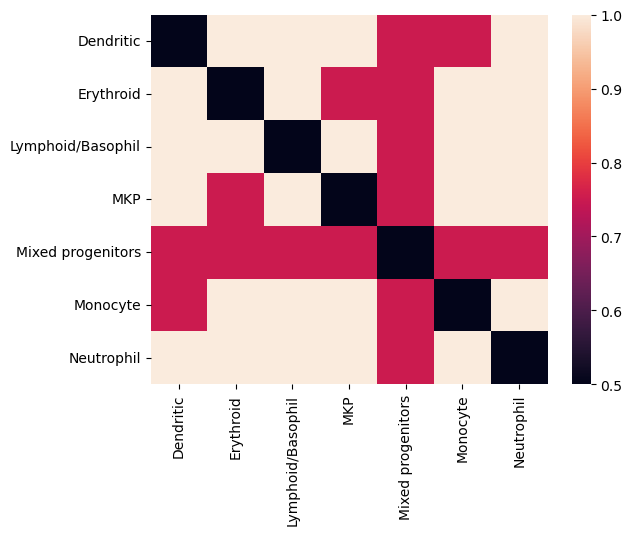

In [11]:
def get_M_matrix(adatas,key,D):
    ''' create cost matrix between cells given cost matrix between labels '''
    annots=[np.array(a.obs[key]).astype(str) for a in adatas]
    cell_types=np.unique(np.concatenate(annots))

    M=np.ones((len(annots[0]), len(annots[1])))
    for i in range(len(cell_types)):
        for j in range(len(cell_types)):
            ct_xs = np.where(annots[0]==cell_types[i])[0]
            ct_xt = np.where(annots[1]==cell_types[j])[0]
            for ix in ct_xs:
                M[ix,ct_xt] = D.loc[cell_types[i],cell_types[j]]
    return M

#--- create cost matrix between labels
ct = np.unique(np.hstack([a.obs['leiden_identity_simple'] for a in _adatas]))
D = pd.DataFrame(1.,index=ct,columns=ct,dtype=float)

# decrease cost to mixed lineage
D.loc['Mixed progenitors',:]=D.loc[:,'Mixed progenitors']=.75

# decrease cost to close labels
D.loc['Dendritic','Monocyte']=D.loc['Monocyte','Dendritic']=.75
D.loc['Erythroid','MKP']=D.loc['MKP','Erythroid']=.75

# decrease cost to same label
np.fill_diagonal(D.values,.5)

sns.heatmap(D)
plt.savefig(f'figures/hematopoiesis/integration_supervision.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
for n,a in zip(names[:-1],_adatas[:-1]):
    print(n)
    yt = np.array(_adatas[target].obs[cluster_key])  
    ys = np.array(a.obs[cluster_key]) 

    ixt = np.arange(len(_adatas[target]))
    
    # ignore fresh for CD samples (prevent mapping to neutrophils) & basophil annotation
    if 'CD' in n: 
        ixt = (_adatas[target].obs['label']!='11_Fresh')
        yt = yt[ixt]

    Xs = a.obsm['X_pca_target'][:,:n_comps]
    Xt = _adatas[target].obsm['X_pca_target'][ixt,:n_comps] 

    print(f'\tmaking supervised cost matrix...')
    M = get_M_matrix([a,_adatas[target][ixt]],cluster_key,D)
    print(f'\tcomputing distance matrix...')
    C = ot.da.cost_normalization(ot.dist(Xs, Xt), norm='max')
    print('\tcomputing adjusted weights')
    ws, wt = weight_per_label(ys, yt)
    #ws, wt = ot.unif(len(Xs)),ot.unif(len(Xt))
    print(f'\tcomputing OT...')        
    P = ot.emd(ws, wt, M*C, numItermax=100000000)
    print(f'\tdone\n')    
    scipy.sparse.save_npz(f'../data/hematopoiesis/result_2-integration/emd_{cluster_key}_{n}_hvg_inter.npz',scipy.sparse.csr_matrix(P))
    
    %xdel M
    %xdel C
    %xdel P
    %xdel Xs
    %xdel Xt
    import gc;gc.collect()

In [ ]:
#load results

Ps = []
for i,n,a in zip(range(3),names[:-1],_adatas[:-1]):
    print(n)

    ixt = np.arange(len(_adatas[target]))
    
    # ignore fresh for CD samples (prevent mapping to neutrophils) & basophil annot
    if 'CD' in n: 
        ixt = (_adatas[target].obs['label']!='11_Fresh')   

    Xt = _adatas[target].obsm['X_pca_target'][ixt,:n_comps] 
    
    P = scipy.sparse.load_npz(f'../data/hematopoiesis/result_2-integration/emd_weighted_{cluster_key}_{n}_hvg_inter.npz').toarray()
    P /= np.sum(P, 1)[:, None]
    P[~ np.isfinite(P)] = 0
    Ps.append(scipy.sparse.csr_matrix(P))
    a.obsm['X_pca_transp_emd']= np.dot(P, Xt)
    
    %xdel P
    
adata_transp = sc.concat(_adatas, label="assay_detailed",keys=[n[6:] for n in names],uns_merge='unique')
adata_transp.obs['assay'] = adata_transp.obs['assay_detailed'].map(lambda s:s.split('_')[0])
adata_transp.obsm['X_pca_transp'] = np.vstack([a.obsm['X_pca_transp'] for a in _adatas[:-1]]+[_adatas[target].obsm['X_pca_target']])
adata_transp.obsm['X_pca_transp_emd'] = np.vstack([*[a.obsm['X_pca_transp_emd'] for a in _adatas[:-1]],
                                                 _adatas[target].obsm['X_pca_target'][:,:n_comps]])

In [ ]:
sc.pp.neighbors(adata_transp,n_neighbors=50,metric='cosine',use_rep=f'X_pca_transp_emd')
sc.tl.umap(adata_transp,min_dist=0.1)
sc.pl.umap(adata_transp,color='leiden_identity_simple2')

In [ ]:
adata_transp.obs['hsc_score']=pd.concat([a.uns['detailed_gene_score_df_cell_types_lin_corrected']['CD34+ HSC_score'] for a in adatas])
plt.figure(figsize=(10,8))
ax=plt.subplot()
sc.pl.umap(adata_transp,color='hsc_score',ax=ax,vmax=np.percentile(adata_transp.obs['hsc_score'],99))
plt.savefig(f'figures/hematopoiesis/integrated_hsc_score.png',dpi=300,bbox_inches='tight')

In [ ]:
sc.settings.autoshow=False

for key in ['leiden_identity_simple2']:
    f,axs=plt.subplots(2,2,figsize=(25,15))
    axs=axs.flat
    for assay in adata_transp.obs['assay_detailed'].unique():
        ax=next(axs)
        sc.pl.umap(adata_transp[adata_transp.obs['assay_detailed']==assay],color=key,s=15,ax=ax)
        ax.set_title(assay)
    plt.tight_layout()
    plt.show()

In [ ]:
adata_transp.write(f'../data/hematopoiesis/result_2-Integration/adata_transp_final_leiden_identity_simple.h5ad')

# Trajectory inference

## in 2D

In [ ]:
f,axs=plt.subplots(1,3,figsize=(22,6))

annot=['leiden_identity_simple2','assay_detailed','epg_pseudotime',]
annot_name=['Cell types','Assay','Pseudotime',]

nodep=adata_transp.uns['epg']['node_pos']
edges=adata_transp.uns['epg']['edge']

for i,key in enumerate(annot):
    ax=axs[i]
    if i==1:
        ax=sc.pl.umap(adata_transp[::-1].copy(),color=key,ax=ax,show=False,)
    elif i==2:
        ax=sc.pl.umap(adata_transp,color=key,cmap='viridis_r',ax=ax,show=False)
        for e in edges:
            ax.plot(*nodep[e].T,linewidth=2,color='k')
    else:
        ax=sc.pl.umap(adata_transp,color=key,ax=ax,show=False)
        
    ax.set_title(annot_name[i],fontsize=35)
    ax.set_xlabel('UMAP1',fontsize=25)
    ax.set_ylabel('UMAP2',fontsize=25)
    if i!=2:
        #ax.legend(prop=dict(size=18),bbox_to_anchor=[1.2, 0.5], loc='center')
        for lh in ax.get_legend().legendHandles: 
            lh._sizes = [100] 

plt.tight_layout(pad=0,w_pad=0)
plt.savefig(f'figures/hematopoiesis/integrated_.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
adata_transp=sc.read(f'../data/hematopoiesis/result_2-Integration/adata_transp_final_leiden_identity_simple.h5ad')

In [ ]:
# select representation, subsample to speed up TI
a_s = sc.pp.subsample(adata_transp,copy=True,n_obs=5000)

key_highD = 'X_graphdr'
key2d = 'X_umap'
a_s.obsm['X_dr'] = a_s.obsm[key2d]
adata_transp.obsm['X_dr'] = adata_transp.obsm[key2d]

In [ ]:
st2.tl.seed_graph(a_s,n_clusters=80,paths_disfavored=[['Neu-like monocytes','DC-like monocytes']],label='leiden_identity_simple2')
st2.pl.graph(a_s,color=['leiden_identity_simple2'],alpha=.5,size=10,fig_size=(8,5),key='seed_epg')

In [ ]:
st2.tl.get_weights(a_s,bandwidth=2)
st2.tl.learn_graph(a_s,n_nodes=95,epg_lambda=0.02,epg_mu=0.05,epg_alpha=0.02,use_weights=True,verbose=0,
                   max_candidates = {"AddNode2Node": 10,"BisectEdge": 10,"ShrinkEdge": 0,})
st2.pl.graph(a_s,color=['leiden_identity_simple2'],alpha=.5,size=10,fig_size=(8,5))

In [ ]:
st2.pl.graph(a_s2,color=['leiden_identity_simple2'],alpha=.5,size=10,fig_size=(16,10),show_text=1)

In [ ]:
a_s2=a_s.copy()
st2.tl.add_path(a_s2,30,32)
st2.tl.add_path(a_s2,2,32,)
st2.tl.del_path(a_s2,62,32)
st2.tl.del_path(a_s2,17,40)
st2.tl.add_path(a_s2,36,27)
st2.tl.del_path(a_s2,27,102)

st2.tl.refit_graph(a_s2,shift_nodes_pos={ 
    3 : a_s2.uns['epg']['node_pos'][3] + np.array([+1, -.5]),
    7  : a_s2.uns['epg']['node_pos'][7] + np.array([-1,  +.75]),
    24 : a_s2.uns['epg']['node_pos'][24] + np.array([0.,+.3]),
    34 : a_s2.uns['epg']['node_pos'][34] + np.array([-.4, +.5]),
    41 : a_s2.uns['epg']['node_pos'][41] + np.array([-1.5,+.5]),
})
st2.tl.extend_leaves(a_s2,Mode="QuantDists",ControlPar=.7)
st2.tl.add_path(a_s2,109,105,epg_lambda=2)
st2.tl.del_path(a_s2,113,105)
st2.tl.del_path(a_s2,46,25)

In [ ]:
adata_transp.uns=a_s2.uns.copy()
st2.tl._elpigraph._store_graph_attributes(adata_transp,adata_transp.obsm['X_dr'],'epg')
st2.tl.infer_pseudotime(adata_transp,2)

In [ ]:
f,axs=plt.subplots(1,3,figsize=(22,6))

annot=['leiden_identity_simple2','assay_detailed','epg_pseudotime',]
annot_name=['Cell types','Assay','Pseudotime',]

nodep=adata_transp.uns['epg']['node_pos']
edges=adata_transp.uns['epg']['edge']

for i,key in enumerate(annot):
    ax=axs[i]
    if i==1:
        ax=sc.pl.umap(adata_transp[::-1].copy(),color=key,ax=ax,show=False,)
    elif i==2:
        ax=sc.pl.umap(adata_transp,color=key,cmap='viridis_r',ax=ax,show=False)
        for e in edges:
            ax.plot(*nodep[e].T,linewidth=2,color='k')
    else:
        ax=sc.pl.umap(adata_transp,color=key,ax=ax,show=False)
        
    ax.set_title(annot_name[i],fontsize=35)
    ax.set_xlabel('UMAP1',fontsize=25)
    ax.set_ylabel('UMAP2',fontsize=25)
    if i!=2:
        #ax.legend(prop=dict(size=18),bbox_to_anchor=[1.2, 0.5], loc='center')
        for lh in ax.get_legend().legendHandles: 
            lh._sizes = [100] 

plt.tight_layout(pad=0,w_pad=0)
plt.savefig(f'figures/hematopoiesis/integrated_.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
adata_transp.write(f'../data/hematopoiesis/result_2-Integration/adata_transp_final_leiden_identity_simple_UMAP_TI_.h5ad')

## in higher dim (PCA)

In [ ]:
adata_transp=sc.read(f'../data/hematopoiesis/result_2-Integration/adata_transp_final_leiden_identity_simple.h5ad')

# select representation, subsample to speed up TI
a_s = sc.pp.subsample(adata_transp,copy=True,n_obs=5000)

key_highD = 'X_pca_transp_emd'
key2d = 'X_umap'
a_s.obsm['X_dr'] = a_s.obsm[key_highD]
adata_transp.obsm['X_dr'] = adata_transp.obsm[key_highD]

In [ ]:
st2.tl.seed_graph(a_s,n_clusters=80,paths_disfavored=[['Neu-like monocytes','DC-like monocytes']],label='leiden_identity_simple2')
st2.pl.graph(a_s,color=['leiden_identity_simple2'],alpha=.5,size=10,fig_size=(8,5),key='seed_epg')

In [ ]:
st2.tl.learn_graph(a_s,n_nodes=100,epg_lambda=0.02,epg_mu=0.05,epg_alpha=0.02,verbose=1,store_evolution=True)
                   #max_candidates = {"AddNode2Node": 10,"BisectEdge": 10,"ShrinkEdge": 0,})
st2.pl.graph(a_s,color=['leiden_identity_simple2'],alpha=.5,size=10,fig_size=(8,5))

In [ ]:
def nodes_info(adata,key='epg'):
    '''Return nodes classified into leaf, branching, branch
    '''
    g = elpigraph.src.graphs.ConstructGraph(st2._utils.stream2elpi(a_s2, key=key))
    leaf = np.where(np.array(g.degree()) == 1)[0]
    branching = np.where(np.array(g.degree()) > 2)[0]
    branch = np.where(np.array(g.degree()) == 2)[0]
    return {'leaf':leaf, 'branching':branching, 'branch':branch}

a_s2=a_s.copy()
st2.tl.del_path(a_s2,48,8)
st2.tl.add_path(a_s2,45,29)
st2.tl.add_path(a_s2,39,47,n_nodes=4)
st2.tl.add_path(a_s2,52,68)#,refit_graph=True)
st2.tl.del_path(a_s2,20,36)
st2.tl.del_path(a_s2,39,6)
st2.tl.del_path(a_s2,98,48)
st2.tl.del_path(a_s2,26,10)
st2.tl.del_path(a_s2,82,15)
st2.tl.add_path(a_s2,82,55)
leaves = np.array([18,12,98,45,48,24,50,32])
st2.tl.extend_leaves(a_s2,LeafIDs=leaves,Mode="QuantDists",ControlPar=.4)
new_leaves = nodes_info(a_s2)['leaf']
st2.tl.refit_graph(a_s2,
                   shift_nodes_pos={**{l : a_s2.uns['epg']['node_pos'][l] for l in new_leaves},
                                    **{l : a_s2.uns['epg']['node_pos'][107] for l in [105,107]}
                                   } # fix same endpoint for monocytes
                  )

adata_transp.uns=a_s2.uns.copy()
st2.tl._elpigraph._store_graph_attributes(adata_transp,adata_transp.obsm['X_dr'],'epg')

In [ ]:
st2.tl.project_graph(a_s2,to_basis='X_umap')
st2.pl.graph(a_s2,color=['leiden_identity_simple2'],alpha=.5,size=10,fig_size=(16,10),show_text=1,key='epg_from_X_dr_to_X_umap')

In [ ]:
adata_transp.uns=a_s2.uns.copy()
st2.tl._elpigraph._store_graph_attributes(adata_transp,adata_transp.obsm['X_dr'],'epg')
st2.tl.infer_pseudotime(adata_transp,40)
st2.pl.stream_sc(adata_transp,40,preference=[104,109,103,110,106,108,26,107,105],color=['leiden_identity_simple2'])
st2.pl.stream(adata_transp,40,preference=[104,109,103,110,106,108,26,107,105],color=['leiden_identity_simple2'],fig_size=(14,8),dist_scale=2,factor_min_win=1.3,factor_num_win=4)
plt.savefig(f'figures/hematopoiesis/stream_plot.png',dpi=300,bbox_inches='tight')

In [ ]:
skpca = sklearn.decomposition.PCA(svd_solver='arpack',random_state=0).fit(adatas_hvg_inter[-1].X)
perc_var_expl = skpca.explained_variance_ratio_*100
n_comps=3
f,axs=plt.subplots(n_comps,n_comps,figsize=(16,16),sharex='col',sharey='row')
for i in range(n_comps):
    for j in range(i+1,n_comps):

        _=sc.pl.embedding(adata_transp,'X_pca_transp_emd',dimensions=(i,j),size=3,alpha=.8,
                        color='leiden_identity_simple2',show=False,return_fig=False,ax=axs[j,i])
        
        handles, labels = axs[j,i].get_legend_handles_labels()
        axs[j,i].get_legend().remove()
        axs[j,i].set_title(None)
        axs[j,i].plot(adata_transp.uns['epg']['node_pos'][adata_transp.uns['epg']['edge'].T,i],
                      adata_transp.uns['epg']['node_pos'][adata_transp.uns['epg']['edge'].T,j],
                      c='k',linewidth=3)
        
        pi,pj = perc_var_expl[i],perc_var_expl[j]
        if i==0: 
            axs[j,i].set_ylabel(f'PC{j+1} ({pj:.1f}% var.)',fontsize=20)
        else: 
            axs[j,i].set_ylabel(None)
        if j==(n_comps-1): 
            axs[j,i].set_xlabel(f'PC{i+1} ({pi:.1f}% var.)',fontsize=20)
        else: 
            axs[j,i].set_xlabel(None)

        if i<j: 
            axs[i,i].axis('off')
            axs[i,j].axis('off')
axs[-1,-1].axis('off')     
lgnd=f.legend(handles, labels, loc='center right',bbox_to_anchor=[.6, .5],prop={'size': 20},frameon=False)
for handle in lgnd.legend_handles:
    handle.set_sizes([100.0])
plt.tight_layout(pad=0,w_pad=0)
plt.savefig(f'figures/hematopoiesis/PC_pairwise_trajectory.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
a=sc.AnnData(np.concatenate((adata_transp.obsm['X_pca_transp_emd'],adata_transp.uns['epg']['node_pos'])))
sc.pp.neighbors(a,n_neighbors=50,metric='cosine')
sc.tl.umap(a,min_dist=0.1)

adata_transp.obsm['X_umap_w_nodes']=a.obsm['X_umap'][:len(adata_transp)]
adata_transp.uns['umap_nodes']=a.obsm['X_umap'][len(adata_transp):]

In [ ]:
f,axs=plt.subplots(1,3,figsize=(22,6))

adata_transp.obs['assay_detailed_plot']=adata_transp.obs['assay_detailed'].cat.rename_categories(
    ['ATAC sorted','ATAC timepoints','RNA sorted','RNA timepoints'])
annot=['leiden_identity_simple2','assay_detailed_plot','epg_pseudotime',]
annot_name=['Cell types','Assays','Pseudotime',]

nodep=adata_transp.uns['umap_nodes']
edges=adata_transp.uns['epg']['edge']

for i,key in enumerate(annot):
    ax=axs[i]
    if i==0:
        _=sc.pl.embedding(adata_transp,'X_umap',size=3,alpha=.5,color=key,show=False,return_fig=False,ax=ax)
    elif i==1:
        _=sc.pl.embedding(adata_transp[::-1],'X_umap',size=3,alpha=.5,color=key,show=False,return_fig=False,ax=ax)
    elif i==2:
        _=sc.pl.embedding(adata_transp,'X_umap_w_nodes',size=3,alpha=.5,color=key,cmap='viridis_r',show=False,return_fig=False,ax=ax)
        for e in edges:
            ax.plot(*nodep[e].T,linewidth=2,color='k')
        
    ax.set_title(annot_name[i],fontsize=35)
    ax.set_xlabel('UMAP1',fontsize=25)
    ax.set_ylabel('UMAP2',fontsize=25)
    if i<2:
        ax.legend(prop=dict(size=12),bbox_to_anchor=[1.2, 0.5], loc='center',frameon=False)
        for lh in ax.get_legend().legend_handles: 
            lh._sizes = [100] 

plt.tight_layout(pad=0,w_pad=0.2)
plt.savefig(f'figures/hematopoiesis/integrated_highD.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
del adata_transp.uns['epg']['graph_evolution']
del adata_transp.uns['stream_tree']
del adata_transp.uns['epg_from_X_dr_to_X_umap']['graph_evolution']
adata_transp.uns['epg_from_X_dr_to_X_umap']['conn'] = adata_transp.uns['epg_from_X_dr_to_X_umap']['conn'].toarray()
adata_transp.uns['epg']['conn']=adata_transp.uns['epg']['conn'].toarray()
adata_transp.uns['seed_epg']['conn']=adata_transp.uns['seed_epg']['conn'].toarray()
adata_transp.write(f'../data/hematopoiesis/result_2-Integration/adata_transp_final_leiden_identity_simple_UMAP_TI_highD.h5ad')

In [ ]:
#mde = pymde.preserve_neighbors(adata_transp.obsm['X_pca_transp_emd'],n_neighbors=50,embedding_dim=2,device='cuda')
#mde10d = pymde.preserve_neighbors(adata_transp.obsm['X_pca_transp_emd'],n_neighbors=50,embedding_dim=10,device='cuda')
#adata_transp.obsm['X_pymde'] = mde.embed().cpu().numpy()
#adata_transp.obsm['X_pymde10d'] = mde10d.embed().cpu().numpy()
#adata_transp.write(f'../data/hematopoiesis/result_2-Integration/adata_transp_final_leiden_identity_simple.h5ad')
#with open('../data/hematopoiesis/result_2-Integration/mde_instances.pkl','wb') as f:
#    pickle.dump({'mde':mde,'mde10d':mde10d},f)

#with open('../data/hematopoiesis/result_2-Integration/mde_instances.pkl','rb') as f:
#    mdes=pickle.load(f)
#mde,mde10d = mdes['mde'], mdes['mde10d']
#
#distortions10d_pca=mde10d.distortions(torch.tensor(adata_transp.obsm['X_pca_transp_emd'][:,:10],device='cuda:0')).cpu().numpy()
#distortions10d=mde10d.distortions().cpu().numpy()
#distortions_pca=mde.distortions(torch.tensor(adata_transp.obsm['X_pca_transp_emd'][:,:2],device='cuda:0')).cpu().numpy()
#distortions=mde.distortions().cpu().numpy()
#
#knn=sklearn.neighbors.NearestNeighbors(metric='euclidean',n_neighbors=50,n_jobs=-1)
#distpca, ixpca = knn.fit(adata_transp.obsm['X_pca_transp_emd']).kneighbors()
#distmde, ixmde = knn.fit(adata_transp.obsm['X_pymde']).kneighbors()
#
#print(sum(~np.isfinite(distortions_pca)))
#plt.hist(distortions,log=True,bins=100,label='MDE (2D)'histtype='step')
#plt.hist(distortions10d,log=True,bins=100,label='MDE (10D)',histtype='step')
#plt.hist(distortions_pca[np.isfinite(distortions_pca)],log=True,bins=100,label='PCA (2D)',alpha=.4,histtype='step')
#plt.hist(distortions10d_pca,log=True,bins=100,label='PCA (10D)',histtype='step')
#plt.legend()
#plt.show()
#
#
#mde.distortions_cdf()
#
#similar_cells = mde.edges[mde.distortion_function.pos_idx]
#sampled_edges = similar_cells[torch.randperm(similar_cells.shape[0])[:10000]]
#pairs, _ = mde.high_distortion_pairs()
#most_distorted_pairs = pairs[:500]
#ax1=pymde.plot(adata_transp.obsm['X_pymde'], color_by=adata_transp.obs['leiden_identity_simple2'].values, color_map='tab20',edges=sampled_edges, figsize_inches=(12, 12))
#ax2=pymde.plot(adata_transp.obsm['X_pymde'], color_by=adata_transp.obs['leiden_identity_simple2'].values, color_map='tab20',edges=most_distorted_pairs, figsize_inches=(12, 12))
#
#import plotly.express as px
#df=pd.DataFrame(adata_transp.obsm['X_pymde'])
#df['col']=adata_transp.obs['leiden_identity_simple2'].values
#fig = px.scatter_3d(df,x=0,y=1,z=2,color='col',opacity=.7)
#fig.update_traces(marker=dict(size=1,))
#fig.update_layout(margin=dict(b=0,r=0), height=1000, width=1000)

# Trajectory analysis motifs only

In [2]:
adata_transp=st2.read_h5ad(f'../data/hematopoiesis/result_2-Integration/adata_transp_final_leiden_identity_simple_UMAP_TI_highD.h5ad')
adata_transp.uns['epg']['params']['layer']=None
adata_transp.uns['epg']['conn']=scipy.sparse.csr_matrix(adata_transp.uns['epg']['conn'])
# small jitter to prevent duplicate node positions for monocyte
adata_transp.uns['epg']['node_pos']+=1e-10*np.random.random(adata_transp.uns['epg']['node_pos'].shape)

/home/jo/anaconda3/envs/stream2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


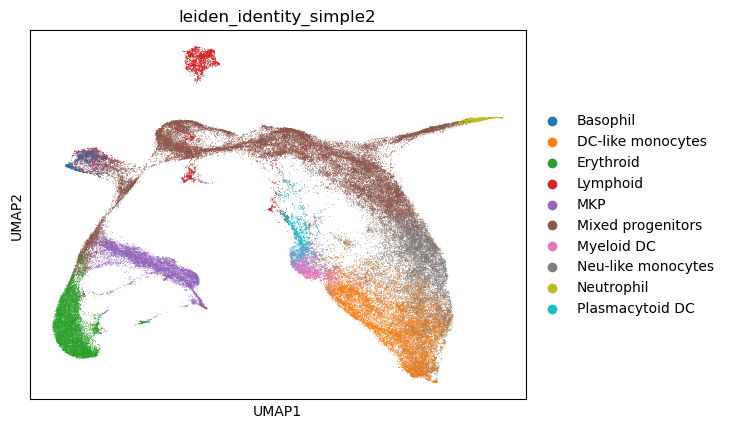

In [3]:
sc.pp.neighbors(adata_transp,n_neighbors=50,metric='cosine',use_rep=f'X_pca_transp_emd')
sc.tl.umap(adata_transp,min_dist=0.1)
sc.pl.umap(adata_transp,color='leiden_identity_simple2')

In [4]:
names = ['adata_ATAC_CD','adata_ATAC_days','adata_RNA_CD','adata_RNA_days']
adatas, adatas_hvg_union, adatas_hvg_inter = [], [], []
for n in names:
    adatas.append(sc.read(f'../data/hematopoiesis/result_2-Integration/inter_{n}.h5ad'))
    #adatas_hvg_union.append(sc.read(f'../data/hematopoiesis/result_2-Integration/union_hvg_{n}.h5ad'))
    #adatas_hvg_inter.append(sc.read(f'../data/hematopoiesis/result_2-Integration/inter_hvg_{n}.h5ad'))

#optional imputation/smoothing
for i,n,a in zip(range(len(names)),names,adatas): 
    if 'RNA' in n:
        if f'inter_{n}_magic.h5ad' not in os.listdir('../data/hematopoiesis/result_2-Integration/'):
            print(n)
            sc.external.pp.magic(a,random_state=0,solver='approximate',n_jobs=8)
            a.write(f'../data/hematopoiesis/result_2-Integration/inter_{n}_magic.h5ad')
        else:
            adatas[i].obsm['X_smooth']=sc.read(f'../data/hematopoiesis/result_2-Integration/inter_{n}_magic.h5ad').X

In [6]:
# load motifs
adata_motifs = sc.read('../data/hematopoiesis/result_1b-ATAC_by_ArchR/ArchR_motifs_JASPAR2022.h5ad')
adata_motifs.X=adata_motifs.X.toarray()

motifs = list(set(np.concatenate((adata_motifs.var['symbol1_hs'],adata_motifs.var['symbol2_hs']))))
motifs.remove(np.nan)
motifs = np.array(motifs)

adatas_test = [adata_motifs[a.obs_names].copy() for a in adatas[:2]] + [a.copy() for a in adatas]
names_test = ['adata_motifs_CD','adata_motifs_days']+names
names_plot = ['ATAC motifs','ATAC motifs','ATAC gene score','ATAC gene score','RNA expression','RNA expression']
names_plot2 = ['ATAC motif sorted','ATAC motif timepoints','ATAC gene score sorted','ATAC gene score timepoints','RNA expression sorted','RNA expression timepoints']
names_plot3 = ['ATAC motif\nsorted','ATAC motif\ntimepoints','ATAC gene score\nsorted','ATAC gene score\ntimepoints','RNA expression\nsorted','RNA expression\ntimepoints']

# subset to motifs
shared_vars =  motifs[np.isin(list(motifs),adatas_test[-1].var_names)]
for i in range(len(adatas_test)):
    if 'motifs' in names_test[i]:
        ix = (  adatas_test[i].var['symbol1_hs'].isin(shared_vars) 
              | adatas_test[i].var['symbol2_hs'].isin(shared_vars))
        adatas_test[i]=adatas_test[i][:,ix].copy()
    elif 'RNA' in names_test[i]:
        adatas_test[i].obsm['X_smooth']=adatas_test[i].obsm['X_smooth'][:,[np.where(adatas_test[i].var_names==s)[0][0] for s in shared_vars]]
        adatas_test[i]=adatas_test[i][:,shared_vars].copy()
    else:
        adatas_test[i]=adatas_test[i][:,shared_vars].copy()
    
    
idx_fusion = adatas_test[0].var_names.str.contains('::')
not_fusion = adatas_test[0].var_names[~idx_fusion]
fusion = adatas_test[0].var_names[idx_fusion]
idx_motifs = np.concatenate((not_fusion,np.repeat(fusion,2)))
idx_genes = np.concatenate((not_fusion.map(lambda s: s.split('_')[1]),
                           np.array(adatas_test[0].var.loc[fusion,['symbol1_hs','symbol2_hs']]).flatten('C')))
idx_genes = np.char.upper(idx_genes.astype(str))

# remove missing genes
idx_motifs=idx_motifs[np.isin(idx_genes,adatas_test[-1].var_names)]
idx_genes=idx_genes[np.isin(idx_genes,adatas_test[-1].var_names)]    

#%xdel adatas
%xdel adata_motifs
gc.collect()

6873

## single branch plots

In [ ]:
st2.tl.project_graph(adata_transp,to_basis='X_umap')
st2.pl.graph(adata_transp,color=['leiden_identity_simple2'],alpha=.5,size=10,fig_size=(16,10),show_text=1,
            key='epg_from_X_dr_to_X_umap')

In [ ]:
#leaves = [k for k,v in dict(nx.Graph(adata_transp.uns['epg']['edge'].tolist()).degree).items() if v==1]

source_target = {
    'Erythroid':(40,103),
    'MKP':(40,110),
    #'Basophil':(40,109),
    #'Neutrophil':(40,106),
    #'Monocyte':(40,15),
    #'Myeloid DC':(40,107),
    #'Plasmacytoid DC':(40,105),
    #'DC-like Monocyte':(40,26),
    #'Neu-like Monocyte':(40,108),
    #'Lymphoid':(40,104),
}

top_corrs = {}
for name,(source,target) in source_target.items():
    top_corrs[name] = {}
    for n,a in zip(names_test,adatas_test):
        if 'motifs' in n:
            adata_assay=adata_transp[adata_transp.obs['assay_detailed']=='ATAC_'+n.split('_')[-1]]
        else:
            adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]
        a.obsm['X_dr']=adata_assay.obsm['X_dr'].copy()
        a.uns=adata_assay.uns.copy()
        st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')
        st2.tl.infer_pseudotime(a,source,target)
        st2.tl.detect_transition_markers(a,fc_cutoff=0.)

        del a.uns['scaled_marker_expr']
        gc.collect()
        top_corrs[name][n] = a.uns['transition_markers'][f'Path_{source}-None-{target}']['stat'].sort_values()[::-1].index

    n_genes = 25
    save_name = f'{name}_{source}_{target}'

    f,axs=plt.subplots(3,2,figsize=(12,15),sharex=True)
    axs=axs.flat
    for i,title,n,a in zip(range(len(adatas_test)),names_plot,names_test,adatas_test): 

        scores = a.uns['transition_markers'][f'Path_{source}-None-{target}']['stat'].sort_values()
        scores = pd.concat((scores[:n_genes],scores[-n_genes:][::-1]))

        gene_names = scores.index
        corrs = a.uns['transition_markers'][f'Path_{source}-None-{target}']['stat'][gene_names]
        if 'motif' in n:
            gene_names = a.var.loc[scores.index,'symbol_hs'].values

        ymin = np.min(scores)
        ymax = np.max(scores)
        ymax += 0.8 * (ymax - ymin)
        ymin -= 0.1 * (ymax - ymin)

        ax=next(axs)
        ax.set_ylim(ymin, ymax)
        ax.set_xlim(-0.9, n_genes - 0.1)

        import matplotlib
        import matplotlib.patheffects as PathEffects

        cmap=plt.cm.get_cmap('RdYlGn')
        norm=matplotlib.colors.Normalize(vmin=-1, vmax=1)
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_array([-1,1])

        # Making labels
        s=0
        for ig, gene_name in zip(np.tile(range(len(gene_names)//2),2),gene_names):
            txt=ax.text(
                ig,
                scores[s],
                gene_name,
                rotation='vertical',
                verticalalignment='bottom',
                horizontalalignment='center',
                fontsize=13,
                color=cmap(norm(corrs[s])),)
            txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='lightgrey')])
            s+=1
        if (i%2) == 0:
            ax.set_ylabel(title+'\n'+'log FC',fontsize=25)
        if i>3:
            ax.set_xlabel('rank',fontsize=25)
        if i==0:
            ax.set_title('Sorted',fontsize=30)
        elif i==1:
            ax.set_title('Timepoints',fontsize=30)

    f.subplots_adjust(right=0.95)
    cbar_ax = f.add_axes([1., 0.3, 0.02, 0.4])
    cbar = f.colorbar(sm, cax=cbar_ax,ticks=np.arange(-1,1.1,.1))
    cbar.ax.get_yaxis().labelpad = 25
    cbar.ax.set_ylabel('Spearman correlation', fontsize=25,rotation=270)

    plt.tight_layout()
    plt.savefig(f'figures/hematopoiesis/stream2/{save_name}_motifs.png',dpi=300,bbox_inches='tight')

    f=plt.figure(figsize=(10,8))
    ax=plt.subplot()
    st2.tl.infer_pseudotime(adata_transp,source,target)
    plt.scatter(*adata_transp.obsm['X_umap'][adata_transp.obs['epg_pseudotime'].isnull()].T,s=.05,c='lightgrey')
    plt.scatter(*adata_transp.obsm['X_umap'].T,s=.1,c=adata_transp.obs['epg_pseudotime'])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('UMAP1',fontsize=30)
    ax.set_ylabel('UMAP2',fontsize=30)
    clb=plt.colorbar()
    clb.ax.set_ylabel('Pseudotime',  labelpad=20, rotation=270,fontsize=25)   
    plt.tight_layout()
    plt.savefig(f'figures/hematopoiesis/{save_name}_pseudotime.png',dpi=300,bbox_inches='tight')
    plt.show()

## single branch heatmaps

In [ ]:

#for n,a in zip(names,adatas_hvg_union[2:]): 
#    sc.external.pp.magic(a,name_list='all_genes',random_state=0,knn_dist='cosine',solver='approximate',n_jobs=4)
source_target = {
    'Erythroid':(24,115),}
#    'MKP':(24,117),
#    'Basophil':(24,113),
#    'Neutrophil':(35,116),
#    'Monocyte':(35,15),
#    'Dendritic':(35,49),
#    'Dendritic Monocyte':(39,54),
#    'Neutrophil Monocyte':(39,41),
#    'Lymphoid1':(24,112),
#    'Lymphoid2':(24,118)
#}


for name,(source,target) in source_target.items():
    #for n,a in zip(names_test,adatas_test):
    #    if 'motifs' in n:
    #        adata_assay=adata_transp[adata_transp.obs['assay_detailed']=='ATAC_'+n.split('_')[-1]]
    #    else:
    #        adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]
    #    a.obsm['X_dr']=adata_assay.obsm['X_dr'].copy()
    #    a.uns=adata_assay.uns.copy()
    #    st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')
    #    st2.tl.infer_pseudotime(a,source,target)
    #    st2.tl.detect_transition_markers(a,fc_cutoff=0.)
#
    #    del a.uns['scaled_marker_expr']
    #    gc.collect()
#
    #n_genes = 25
    save_name = f'{name}_{source}_{target}_heatmap'


    f,axs=plt.subplots(3,2,figsize=(12,15),sharex=False)
    axs=axs.flat
    for i,title,n,a in zip(range(len(adatas_test)),names_plot,names_test,adatas_test): 

        scores = a.uns['transition_markers'][f'Path_{source}-None-{target}']['logfc'].sort_values()[::-1][:n_genes]
        #if 'motif' in n:
        #    gene_names = a.var.loc[scores.index,'names'].values
        #else: 
        gene_names = scores.index
        corrs = a.uns['transition_markers'][f'Path_{source}-None-{target}']['stat'][gene_names]

        ax=next(axs)

        a_ps = a[~a.obs['epg_pseudotime'].isna(),gene_names]
        a_ps_sorted = a_ps[a_ps.obs['epg_pseudotime'].sort_values().index]
        df = a_ps_sorted.to_df().T.iloc[:10]
        for it in range(len(df)):
            df.iloc[it] = scipy.ndimage.filters.gaussian_filter(df.iloc[it], sigma=100)

        _=sns.heatmap(df,ax=ax)
        ax.set_xticks([])
            
        if (i%2) == 0:
            ax.set_ylabel(title,fontsize=25)
        if i>3:
            ax.set_xlabel('Pseudotime',fontsize=25)
        if i==0:
            ax.set_title('Sorted',fontsize=30)
        elif i==1:
            ax.set_title('Timepoints',fontsize=30)

    plt.tight_layout()
    #plt.savefig(f'../../git/PHD_THESIS/images/stream2/{save_name}_motifs.png',dpi=300,bbox_inches='tight')

In [ ]:
import gc

#for n,a in zip(names,adatas_hvg_union[2:]): 
#    sc.external.pp.magic(a,name_list='all_genes',random_state=0,knn_dist='cosine',solver='approximate',n_jobs=4)
source_target = {
    'Erythroid':(24,115),
    'MKP':(24,117),
    'Basophil':(24,113),
    'Neutrophil':(35,116),
#    'Monocyte':(35,15),
#    'Dendritic':(35,49),
#    'Dendritic Monocyte':(39,54),
#    'Neutrophil Monocyte':(39,41),
#    'Lymphoid1':(24,112),
#    'Lymphoid2':(24,118)
}
    
#scores = a.uns['transition_markers'][f'Path_{source}-None-{target}']['logfc'].sort_values()[::-1][:n_genes]
#if 'motif' in n:
#    gene_names = a.var.loc[scores.index,'names'].values
#else: 
#gene_names = scores.index
#corrs = a.uns['transition_markers'][f'Path_{source}-None-{target}']['stat'][gene_names]
save_name = f'{name}_{source}_{target}_heatmap'

f,axs=plt.subplots(1,4,figsize=(20,6),sharey=True)
axs=axs.flat
for name,(source,target) in source_target.items():
    for n,a in zip(names_test[5:],adatas_test[5:]):
        if 'motifs' in n:
            adata_assay=adata_transp[adata_transp.obs['assay_detailed']=='ATAC_'+n.split('_')[-1]]
        else:
            adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]
        a.obsm['X_dr']=adata_assay.obsm['X_dr'].copy()
        a.uns=adata_assay.uns.copy()
        st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')
        st2.tl.infer_pseudotime(a,source,target)
    #    st2.tl.detect_transition_markers(a,fc_cutoff=0.)
#
    #    del a.uns['scaled_marker_expr']
    #    gc.collect()
#
    #n_genes = 25

    ax=next(axs)

    a_ps = a[~a.obs['epg_pseudotime'].isna(),gene_names]
    a_ps_sorted = a_ps[a_ps.obs['epg_pseudotime'].sort_values().index]
    df = a_ps_sorted.to_df().T.iloc[:10]
    for it in range(len(df)):
        df.iloc[it] = scipy.ndimage.filters.gaussian_filter(df.iloc[it], sigma=100)

    _=sns.heatmap(df,ax=ax)
    ax.set_xticks([])

    ax.set_xlabel('Pseudotime',fontsize=25)
    ax.set_title(name,fontsize=30)

    plt.tight_layout()
    #plt.savefig(f'../../git/PHD_THESIS/images/stream2/{save_name}_motifs.png',dpi=300,bbox_inches='tight')

## single branch heatmaps scfates

In [ ]:
import scFates as scf
from typing import Union, Sequence, Optional, Iterable
from typing_extensions import Literal
import numpy as np
import pandas as pd
import igraph
import matplotlib.pyplot as plt
from scFates.tools.utils import get_X
import scanpy as sc
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scanpy.plotting._utils import savefig_or_show
from anndata import AnnData
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec

import logging as logg
from scFates.tools.graph_operations import subset_tree
from scFates.tools.utils import getpath

def subset_adata(adata,part):
    a_s = adata[part].copy()
    for key in ['seed_epg','epg']:
        if "layer" not in a_s.uns[key]["params"]:
            a_s.uns[key]["params"]["layer"] = None
        st2.tl._elpigraph._store_graph_attributes(a_s,st2.tl._graph_utils._get_graph_data(a_s,key),key)
        G=nx.Graph(a_s.uns[key]["edge"].tolist())
        nx.set_node_attributes(G,dict(zip(range(len(G.nodes)),a_s.uns[key]['node_pos'])),"pos")
        G.remove_nodes_from(set(range(len(G.nodes))).difference(a_s.obs[f'{key}_node_id']))
        #G.remove_nodes_from(np.where(np.array(list(G.degree.values()))==0)[0])
        G2 = nx.relabel_nodes(G,dict(zip(G.nodes,range(len(G.nodes)))),copy=True)
        a_s.uns[key]['node_pos'] = np.vstack([nx.get_node_attributes(G2,'pos')[i] for i in range(len(G2.nodes))])
        a_s.uns[key]["edge"]= np.array(G2.edges)
    st2.tl._elpigraph._store_graph_attributes(a_s,st2.tl._graph_utils._get_graph_data(a_s,key),'epg')
    return a_s

def epg_to_graph(EPG, X, Nodes, use_rep, ndims_rep, extend_leaves, device):
    import elpigraph
    import igraph
    from numba import njit, prange
    import math
    @njit(parallel=True)
    def norm_R_cpu(R, Rsum):
        for x in prange(len(Rsum)):
            for y in range(R.shape[1]):
                R[x, y] = R[x, y] / Rsum[x]
                if math.isnan(R[x, y]):
                    R[x, y] = 0
                    
    if device == "gpu":
        from cuml.metrics import pairwise_distances
    else:
        from sklearn.metrics import pairwise_distances

    if extend_leaves:
        EPG = elpigraph.ExtendLeaves(X, EPG, Mode="WeightedCentroid")
        Nodes = EPG["NodePositions"].shape[0]

    F = EPG["NodePositions"].T

    # assign to edge and obtain R
    R = pairwise_distances(X, EPG["NodePositions"])
    idx_nodes = np.arange(Nodes)
    elpigraph.utils.getProjection(X, EPG)
    mask = [
        np.isin(idx_nodes, EPG["Edges"][0][EPG["projection"]["edge_id"][i]]) * 1
        for i in range(X.shape[0])
    ]

    R = R * np.vstack(mask)
    Rsum = R.sum(axis=1)
    norm_R_cpu(R, Rsum)
    R = np.abs(R - 1)
    R[R == 1] = 0

    # obtain B
    g = igraph.Graph(directed=False)
    g.add_vertices(np.unique(EPG["Edges"][0].flatten().astype(int)))
    g.add_edges(pd.DataFrame(EPG["Edges"][0]).astype(int).apply(tuple, axis=1).values)

    B = np.asarray(g.get_adjacency().data)

    emptynodes = np.argwhere(R.max(axis=0) == 0).ravel()

    if len(emptynodes) > 0:
        logg.info("    there are %d non assigned nodes" % (len(emptynodes)))

    g = igraph.Graph.Adjacency((B > 0).tolist(), mode="undirected")
    tips = np.argwhere(np.array(g.degree()) == 1).flatten()
    forks = np.argwhere(np.array(g.degree()) > 2).flatten()

    graph = {
        "B": B,
        "F": F,
        "tips": tips,
        "forks": forks,
        "metrics": "euclidean",
        "use_rep": use_rep,
        "ndims_rep": ndims_rep,
        "method": "epg",
    }

    return graph, R, EPG

def stream2scf(adata):
    a = adata.copy()
    obsm = a.uns['epg']["params"]["obsm"]
    layer = a.uns['epg']["params"]["layer"]
    use_rep = obsm if obsm is not None else layer
    a.uns["graph"], a.obsm["X_R"], a.uns["epg"]  = epg_to_graph(st2._utils.stream2elpi(a), 
                                                                st2.tl._graph_utils._get_graph_data(a,"epg"), 
                                                                Nodes=len(a.uns['epg']['node_pos']),use_rep=use_rep, 
                                                                ndims_rep=None, extend_leaves=False, device='cpu')
    return a

def subset_cells(adata, root_milestone, milestones):
    dct = adata.uns["graph"]["milestones"]

    leaves = list(map(lambda leave: dct[leave], milestones))
    root = dct[root_milestone]
    df = adata.obs.copy(deep=True)
    edges = (
        adata.uns["graph"]["pp_seg"][["from", "to"]]
        .astype(str)
        .apply(tuple, axis=1)
        .values
    )
    img = igraph.Graph()
    img.add_vertices(
        np.unique(
            adata.uns["graph"]["pp_seg"][["from", "to"]].values.flatten().astype(str)
        )
    )
    img.add_edges(edges)

    cells = np.unique(
        np.concatenate(
            list(
                map(
                    lambda leave: getpath(
                        img,
                        root,
                        adata.uns["graph"]["tips"],
                        leave,
                        adata.uns["graph"],
                        df,
                    ).index,
                    leaves,
                )
            )
        )
    )

    return adata[cells]

def matrix(
    adata: AnnData,
    features: Sequence,
    nbins: int = 5,
    layer: str = "fitted",
    norm: Literal["max", "minmax", "none"] = "max",
    annot_var: bool = False,
    annot_top: bool = True,
    link_seg: bool = True,
    root_milestone: Optional[str] = None,
    milestones: Optional[Iterable] = None,
    feature_style: str = "normal",
    feature_spacing: float = 1,
    cmap: Optional[str] = None,
    colorbar: bool = True,
    colorbar_title: Optional[str] = None,
    figsize: Union[None, tuple] = None,
    return_data: bool = False,
    show: Optional[bool] = None,
    save: Union[str, bool, None] = None,
    maxval=None,
    **kwargs,
):
    """\
    Plot a set of features as per-segment matrix plots of binned pseudotimes.
    Parameters
    ----------
    adata
        Annotated data matrix.
    features
        Name of the features.
    nbins
        Number of pseudotime bins per segment.
    layer
        Layer to use for the expression to display.
    norm
        How to normalize the expression.
    annot_var
        Annotate overall tree amplitude of expression of the marker (from .var['A']).
    annot_top
        Display milestones gradient for each segment on top of plots.
    link_seg
        Link the segment together to keep track of the the tree progression.
    root_milestone
        tip defining progenitor branch.
    milestones
        tips defining the progenies branches.
    feature_style
        Font style of the feature labels.
    feature_spacing
        When figsize is None, controls the the height of each rows.
    cmap
        colormap to use, by default is plt.rcParams["image.cmap"].
    colorbar
        Show the colorbar.
    colorbar_title
        Set a custom colorbar title.
    figsize
        Custom figure size.
    show
        show the plot.
    save
        save the plot.
    save_genes
        save list of genes following the order displayed on the heatmap.
    **kwargs
        arguments passed to :class:`scanpy.pl.MatrixPlot`
    Returns
    -------
    If `show==False` an array of :class:`~matplotlib.axes.Axes`
    """

    adata = adata[:, features].copy()

    if milestones is not None:
        adata = subset_cells(adata, root_milestone, milestones)

    cmap = plt.rcParams["image.cmap"] if cmap is None else cmap

    if (layer == "fitted") & ("fitted" not in adata.layers):
        print("Features not fitted, using X expression matrix instead")
        layer = None

    X = get_X(adata, adata.obs_names, adata.var_names, layer=layer)
    if norm == "max":
        adata.X = X / X.max(axis=0).ravel()
    elif norm == "minmax":
        adata.X = (X - X.min(axis=0).ravel()) / (
            X.max(axis=0).ravel() - X.min(axis=0).ravel()
        )

    if maxval is None:
        maxval = max(X.max(axis=0)) if norm == "none" else 1

    graph = adata.uns["graph"]

    dct = graph["milestones"]
    keys = np.array(list(dct.keys()))
    vals = np.array(list(dct.values()))

    edges = graph["pp_seg"][["from", "to"]].astype(str).apply(tuple, axis=1).values
    img = igraph.Graph(directed=True)
    img.add_vertices(vals.astype(str))
    img.add_edges(edges)

    allpaths = img.get_all_shortest_paths(
        str(graph["root"]), to=graph["tips"].astype(str)
    )

    allpaths = np.array(allpaths, dtype=object)[
        np.argsort(np.array([len(p) for p in allpaths]))
    ]

    order = allpaths[0]
    for i in range(1, len(allpaths)):
        order = order + np.array(allpaths[i])[~np.isin(allpaths[i], order)].tolist()

    order = np.array(order)[1:]

    order = pd.Series(graph["milestones"].keys(), index=graph["milestones"].values())[
        np.array(img.vs["name"])[order].astype(int)
    ]
    to_mil = graph["pp_seg"].loc[adata.obs.seg.cat.categories.astype(int), "to"]
    seg_order = pd.Series(range(len(adata.obs.seg.cat.categories)), index=to_mil)[
        order[order.index.isin(to_mil)].index
    ].values

    vs2mils = pd.Series(dct.keys(), index=dct.values())

    cellsel = [
        adata.obs.milestones[adata.obs.seg == s]
        for s in adata.obs.seg.cat.categories[seg_order]
    ]

    fig, axs = plt.subplots(
        1,
        len(seg_order) + 1 * annot_var,
        constrained_layout=False,
        sharey=True,
        figsize=(
            len(seg_order) * 0.85 + 0.85 + annot_var * 1,
            (len(features)) / (5 - feature_spacing) + 0.4 * annot_top,
        )
        if figsize is None
        else figsize,
    )

    if (len(seg_order) + 1 * annot_var) == 1:
        axs = [axs]

    pos = np.arange(len(seg_order), 0, -1)
    caxs = []
    if return_data:
        datas = dict()
    for i, s in enumerate(seg_order):
        adata_sub = adata[adata.obs.seg == adata.obs.seg.cat.categories[s]].copy()
        adata_sub.obs["split"] = pd.cut(adata_sub.obs.t, bins=nbins)

        # remove unsed categories
        counts = adata_sub.obs.split.value_counts()
        counts = np.array(counts[counts == 0].index.values)
        empty = np.argwhere(
            np.isin(np.array(adata_sub.obs.split.cat.categories), counts)
        )
        if len(empty) > 0:
            logg.warn(f"removed {len(empty)} empty interval")
            adata_sub.obs.split = adata_sub.obs.split.cat.remove_unused_categories()

        if annot_top:
            ss = int(adata.obs.seg.cat.categories[s])
            sel = (
                adata.obs.milestones.cat.categories
                == vs2mils[graph["pp_seg"].loc[ss]["from"]]
            )
            start = np.array(adata.uns["milestones_colors"])[sel][0]
            sel = (
                adata.obs.milestones.cat.categories
                == vs2mils[graph["pp_seg"].loc[ss]["to"]]
            )
            end = np.array(adata.uns["milestones_colors"])[sel][0]

            my_cm = LinearSegmentedColormap.from_list("aspect", [start, end])

        if "use_raw" not in kwargs:
            kwargs["use_raw"] = False

        M = sc.pl.MatrixPlot(
            adata_sub,
            features,
            "split",
            vmin=0,
            vmax=maxval,
            cmap=cmap,
            antialiaseds=True,
            linewidth=0.0,
            snap=True,
            edgecolors="none",
            **kwargs,
        )
        M.swap_axes()
        M._mainplot(axs[i])
        axs[i].set_xticklabels("")
        axs[i].set_xticks([])
        plt.margins(y=10)
        plt.setp(axs[i].get_yticklabels(), style=feature_style)
        if annot_top:
            divider = make_axes_locatable(axs[i])
            cax = divider.new_vertical(size=0.2, pad=0.05, pack_start=False)
            caxs.append(cax)
            mappable = cm.ScalarMappable(cmap=my_cm)

            fig.add_axes(cax)
            cbar = fig.colorbar(mappable, cax=cax, orientation="horizontal")
            cbar.set_ticks([])
            cbar.outline.set_linewidth(1.5)

        if return_data:
            data = pd.DataFrame(
                0, index=features, columns=adata_sub.obs.split.cat.categories
            )
            allidx = data.stack().index
            for group in data.columns:
                data.loc[data.index, group] = np.array(
                    adata_sub[adata_sub.obs.split == group, data.index].X.mean(axis=0)
                ).ravel()

            k = "->".join(
                vs2mils[
                    graph["pp_seg"].loc[int(adata.obs.seg.cat.categories[s])][
                        ["from", "to"]
                    ]
                ]
            )
            datas[k] = data

    if annot_var:
        Amps = adata.var.loc[features, "A"]
        axs[i + 1].barh(
            np.arange(len(features)) + 0.5,
            Amps,
            color="salmon",
            height=0.65,
            left=0,
            edgecolor="black",
            label="A",
        )
        axs[i + 1].invert_yaxis()
        axs[i + 1].spines["top"].set_visible(False)
        axs[i + 1].spines["left"].set_visible(False)
        axs[i + 1].spines["right"].set_visible(False)

        axs[i + 1].get_xaxis().tick_bottom()
        axs[i + 1].tick_params(left=False)
        axs[i + 1].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[i + 1].grid(False)

        if annot_top:
            divider = make_axes_locatable(axs[i + 1])
            cax = divider.new_vertical(size=0.2, pad=0.05, pack_start=False)
            fig.add_axes(cax)
            cax.annotate("Amplitude", (0, 0), va="bottom", ha="left", size=12)
            cax.axis("off")

    if link_seg:
        caxs_dct = dict(zip([adata.obs.seg.cat.categories[o] for o in seg_order], caxs))

        kw = dict(
            arrowprops=dict(
                arrowstyle="<|-",
                facecolor="k",
                connectionstyle="bar,fraction=.2",
                shrinkA=0.1,
            ),
            zorder=0,
            va="center",
            xycoords="axes fraction",
            annotation_clip=False,
        )

        kwclose = dict(
            arrowprops=dict(
                arrowstyle="<|-",
                facecolor="k",
                connectionstyle="bar,fraction=1",
                shrinkA=0.1,
            ),
            zorder=0,
            va="center",
            xycoords="axes fraction",
            annotation_clip=False,
        )

        pp_seg = adata.uns["graph"]["pp_seg"]

        dsts = pd.Series(range(len(caxs_dct)), index=caxs_dct.keys())
        for s, cax in caxs_dct.items():
            fro = pp_seg.loc[int(s), "from"]
            to = pp_seg.loc[int(s), "to"]
            for n in pp_seg.index[pp_seg["from"] == to]:
                if str(n) not in dsts.index:
                    pass
                elif dsts[str(n)] - dsts[s] > 1:
                    cax.annotate("", xy=[1, 1], xytext=[2.4, 1], **kw)
                else:
                    cax.annotate("", xy=[1, 1], xytext=[1.2, 1], **kwclose)

    if colorbar:
        ax = axs[i + 1 * annot_var]
        position = inset_axes(
            ax,
            width=1,
            height=0.15,
            bbox_to_anchor=(1.04, 0),
            bbox_transform=ax.transAxes,
            loc=3,
            borderpad=2,
        )

        mappable = cm.ScalarMappable(cmap=cm.get_cmap(cmap))
        cbar = fig.colorbar(mappable, cax=position, orientation="horizontal", aspect=50)
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels(
            [
                "min" if norm == "minmax" else "0",
                "%.2f" % maxval if norm == "none" else "max",
            ]
        )
        title = "expression"
        if colorbar_title is not None:
            title = colorbar_title
        elif norm == "minmax":
            title = "minmax\nnormalized\nexpression"
        elif norm == "max":
            title = "max\nnormalized\nexpression"
        cbar.ax.set_title(title, loc="center")

    savefig_or_show("matrix", show=show, save=save)

    if show == False:
        return axs
    if return_data:
        return datas

In [ ]:
### DETAILED ASSAYS ####
#scf.set_figure_pubready()

source_target = {
    'Erythroid':(40,103),
    'MKP':(40,110),
    'Basophil':(40,109),
    #'Neutrophil':(40,106),
    #'Monocyte':(40,15),
    #'Myeloid DC':(40,107),
    #'Plasmacytoid DC':(40,105),
    #'DC-like Monocyte':(40,26),
    #'Neu-like Monocyte':(40,108),
    #'Lymphoid':(40,104),
}

root = 40
leaves = [v[1] for v in source_target.values()]

top_feats = {}
interpolated = {}
for name,(source,target) in source_target.items():
    top_feats[name] = {}
    interpolated[name] = {}
    for n,a in zip(names_test,adatas_test):
        if 'motifs' in n:
            adata_assay=adata_transp[adata_transp.obs['assay_detailed']=='ATAC_'+n.split('_')[-1]]
        else:
            adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]
        a.obsm['X_dr']=adata_assay.obsm['X_dr'].copy()
        a.uns=adata_assay.uns.copy()
        st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')
        st2.tl.infer_pseudotime(a,source,target)
        st2.tl.detect_transition_markers(a,fc_cutoff=0.)

        del a.uns['scaled_marker_expr']
        gc.collect()
        top_feats[name][n] = a.uns['transition_markers'][f'Path_{source}-None-{target}']['logfc'].sort_values()[::-1].index
        xs, interpolated[name][n] = st2.tl.interpolate(a,t_len=200,method='knn',frac=.1,n_neighbors='auto',weights='uniform')
        
feats = []
for name in source_target:
    for k,v in top_feats[name].items():
        if 'motifs' not in k:
            feats.append(v[:20])
feats = np.unique(feats)
corrs=adatas_test[-1][:,feats].to_df().corr('spearman')
feats_order = scipy.cluster.hierarchy.leaves_list(scipy.cluster.hierarchy.linkage(scipy.spatial.distance.pdist(corrs), method='average',optimal_ordering=True))
feats = feats[feats_order]

feats_motifs_all = []
feats_motifs_top = []
for f in feats:
    f_motif = np.where((adatas_test[0].var['symbol1_hs']==f) | (adatas_test[0].var['symbol2_hs']==f))[0]
    feats_motifs_all.extend(adatas_test[0].var_names[f_motif])
    ix_fm = np.argmax(np.abs([scipy.stats.spearmanr(interpolated[name]['ATAC motifs'][:,i],
                                            interpolated[name]['RNA expression'][:,adatas_test[-1].var_names==f]).correlation 
                      for i in f_motif]))
    feats_motifs_top.extend(adatas_test[0].var_names[f_motif[ix_fm]])
                                    # unique w order preserved
feats_motifs_top = np.array(feats_motifs_top)[np.sort(np.unique(feats_motifs_top, return_index=True)[1])]
feats_motifs_all = np.array(feats_motifs_all)[np.sort(np.unique(feats_motifs_all, return_index=True)[1])]
        

for n,a in zip(names_test[-1:],adatas_test[-1:]):
    if 'motifs' in n:
        adata_assay=adata_transp[adata_transp.obs['assay_detailed']=='ATAC_'+n.split('_')[-1]]
    else:
        adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]
    a.obsm['X_dr']=adata_assay.obsm['X_dr'].copy()
    a.uns=adata_assay.uns.copy()
    st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')

    partition = np.zeros(len(a),dtype=bool)
    for leaf in leaves:
        st2.tl.infer_pseudotime(a,40,leaf)
        partition = partition | (~a.obs['epg_pseudotime'].isna().values)

    a_s = subset_adata(a,partition)
    a_scf = stream2scf(a_s)
    np.clip(a_scf.X,np.percentile(a_scf.X,5,axis=0),np.percentile(a_scf.X,95,axis=0),out=a_scf.X)
    
    root_scf = np.where(np.all(a_s.uns['epg']['node_pos']==a.uns['epg']['node_pos'][root],axis=1))[0]
    scf.tl.root(a_scf,root_scf)
    scf.tl.pseudotime(a_scf)

    fig, axs=plt.subplots(1,3,figsize=(10,4))
    axs=axs.ravel()
    scf.pl.graph(a_scf,basis="umap",show=False,ax=axs[0])
    scf.pl.trajectory(a_scf,basis="umap",show=False,ax=axs[1])
    a_scf.obsm['X_draw_graph_umap']=a_scf.obsm['X_umap']
    sc.pl.draw_graph(a_scf,layout='umap',color="milestones",legend_loc="on data",show=False,ax=axs[2],legend_fontoutline=True)

    #list(adata_transp2.uns["graph"]["milestones"].values())
    #scf.tl.rename_milestones(adata_transp2,['Baso', 'Lymph', 'Mono', 'Ery', 'Neu', 'MKP', 'MonoDC<>MonoNeu', 'MonoDC><MonoNeu', 
    #                                       'HSC', 'Lymph<>EryMKP', 'DC', 'Early\n DC-Neu-Mono', 'Neu<>Mono', 'Ery<>MKP'])

    feats_plot = feats_motifs if "motifs" in n else feats
    scf.pl.matrix(a_scf,#root_milestone='17',milestones=['Basophil','Erythroid','Neutrophil','MKP','Lymphoid2','Monocyte',],
           features=feats[feats_order],norm="minmax",cmap="RdBu_r",colorbar=True,)#figsize=(20,10),save="_F.pdf")

In [ ]:
### COMBINED ASSAYS ####

scf.set_figure_pubready()

source_target = {
    'Erythroid':(40,103),
    'MKP':(40,110),
    #'Basophil':(40,109),
    'Neutrophil':(40,106),
    'Monocyte':(40,15),
    #'Myeloid DC':(40,107),
    #'Plasmacytoid DC':(40,105),
    #'DC-like Monocyte':(40,26),
    #'Neu-like Monocyte':(40,108),
    #'Lymphoid':(40,104),
}

leaves = [v[1] for v in source_target.values()]
root = 40

top_feats = {}
interpolated = {}
for name,(source,target) in source_target.items():
    top_feats[name] = {}
    interpolated[name] = {}
    for i,n,ix in zip(np.arange(3),['ATAC motifs','ATAC gene score','RNA expression'],[[0,1],[2,3],[4,5]]):
        adata_assay=adata_transp[adata_transp.obs['assay']==n.split(' ')[0]]  
        a=adatas_test[ix[0]].concatenate(adatas_test[ix[1]],index_unique=None)
        a.obsm['X_dr']=adata_assay.obsm['X_dr'].copy()
        a.obsm['X_umap']=adata_assay.obsm['X_umap'].copy()
        a.uns=adata_assay.uns.copy()
        st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')
        st2.tl.infer_pseudotime(a,source,target)
        st2.tl.detect_transition_markers(a,fc_cutoff=0.)

        top_feats[name][n] = a.uns['transition_markers'][f'Path_{source}-None-{target}']['logfc'].sort_values()[::-1].index
        xs, interpolated[name][n] = st2.tl.interpolate(a,t_len=200,method='knn',frac=.1,n_neighbors='auto',weights='uniform')
        %xdel a
        gc.collect()        
        
n_feats = 5
feats = []
for name in source_target:
    for k,v in top_feats[name].items():
        if 'motifs' not in k:
            feats.append(v[:n_feats])
feats = np.unique(feats)
corrs = adatas_test[-1][:,feats].to_df().corr('spearman')
feats_order = scipy.cluster.hierarchy.leaves_list(scipy.cluster.hierarchy.linkage(scipy.spatial.distance.pdist(corrs), method='average',optimal_ordering=True))
feats = feats[feats_order]

%xdel corrs 

feats_motifs_all = []
feats_motifs_top = []
for f in feats:
    f_motif = np.where((adatas_test[0].var['symbol1_hs']==f) | (adatas_test[0].var['symbol2_hs']==f))[0]
    feats_motifs_all.extend(adatas_test[0].var_names[f_motif])
    ix_fm = np.argmax(np.abs([scipy.stats.spearmanr(interpolated[name]['ATAC motifs'][:,i],
                                            interpolated[name]['RNA expression'][:,adatas_test[-1].var_names==f]).correlation 
                      for i in f_motif]))
    feats_motifs_top.extend(adatas_test[0].var_names[f_motif[ix_fm]])
                                    # unique w order preserved
feats_motifs_top = np.array(feats_motifs_top)[np.sort(np.unique(feats_motifs_top, return_index=True)[1])]
feats_motifs_all = np.array(feats_motifs_all)[np.sort(np.unique(feats_motifs_all, return_index=True)[1])]

%xdel interpolated
gc.collect()        

for i,n,ix in zip(np.arange(3),['ATAC motifs','ATAC gene score','RNA expression'],[[0,1],[2,3],[4,5]]):
    n_ = n.replace(' ','_')
    perc = 10 if 'motifs' in n else 0

    #if f"matrixerymkp_{n_}_{n_feats}_{perc}.pdf" in os.listdir('figures/hematopoiesis/'):
    #    continue
    adata_assay=adata_transp[adata_transp.obs['assay']==n.split(' ')[0]]  
    a=adatas_test[ix[0]].concatenate(adatas_test[ix[1]],index_unique=None)
    a.obsm['X_dr']=adata_assay.obsm['X_dr'].copy()
    a.obsm['X_umap']=adata_assay.obsm['X_umap'].copy()    
    a.uns=adata_assay.uns.copy()
    sc.pp.subsample(a,n_obs=5000)
    st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')

    partition = np.zeros(len(a),dtype=bool)
    for leaf in leaves:
        st2.tl.infer_pseudotime(a,root,leaf)
        partition = partition | (~a.obs['epg_pseudotime'].isna().values)

    a_s = subset_adata(a,partition)
    a_scf = stream2scf(a_s)
    
    np.clip(a_scf.X,np.percentile(a_scf.X,perc,axis=0),np.percentile(a_scf.X,100-perc,axis=0),out=a_scf.X)

    root_scf = np.where(np.all(a_s.uns['epg']['node_pos']==a.uns['epg']['node_pos'][root],axis=1))[0][0]
    scf.tl.root(a_scf,root_scf)
    scf.tl.pseudotime(a_scf)

    fig, axs=plt.subplots(1,3,figsize=(10,4))
    axs=axs.ravel()
    scf.pl.graph(a_scf,basis="umap",show=False,ax=axs[0])
    scf.pl.trajectory(a_scf,basis="umap",show=False,ax=axs[1])
    sc.pl.umap(a_scf,color="milestones",legend_loc="on data",show=False,ax=axs[2],legend_fontoutline=True)

    %xdel a
    %xdel a_s
    gc.collect()
    import time
    time.sleep(3)
    
    maxval = 1 if 'motifs' in n else 1
    feats_plot = feats_motifs_all if "motifs" in n else feats
    
    matrix(a_scf,nbins=5,maxval=maxval,root_milestone='45',milestones=['13','28','87','47','57','88'],
           features=feats_plot,norm="minmax",cmap="RdBu_r",colorbar=True,save=f"mono_{n_}.pdf")#figsize=(20,10)
    gc.collect()
    time.sleep(3)
    
    matrix(a_scf,nbins=5,maxval=maxval,root_milestone='45',milestones=['13','6','86','89'],
           features=feats_plot,norm="minmax",cmap="RdBu_r",colorbar=True,save=f"erymkp_{n_}_{n_feats}_{perc}.pdf")#figsize=(20,10)

    %xdel a_scf

In [ ]:
import warnings
warnings.filterwarnings('ignore')

for i,n,ix in zip(np.arange(3),['ATAC motifs','ATAC gene score','RNA expression'],[[0,1],[2,3],[4,5]]):
    
    print(n)
    
    n_ = n.replace(' ','_')
    perc = 10 if 'motifs' in n else 0

    #if f"matrixerymkp_{n_}_{n_feats}_{perc}.pdf" in os.listdir('figures/hematopoiesis/'):
    #    continue
    adata_assay=adata_transp[adata_transp.obs['assay']==n.split(' ')[0]]  
    a=adatas_test[ix[0]].concatenate(adatas_test[ix[1]],index_unique=None)
    a.obsm['X_dr']=adata_assay.obsm['X_dr'].copy()
    a.obsm['X_umap']=adata_assay.obsm['X_umap'].copy()    
    a.uns=adata_assay.uns.copy()
    sc.pp.subsample(a,n_obs=5000)
    st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')

    partition = np.zeros(len(a),dtype=bool)
    for leaf in leaves:
        st2.tl.infer_pseudotime(a,root,leaf)
        partition = partition | (~a.obs['epg_pseudotime'].isna().values)

    a_s = subset_adata(a,partition)
    a_scf = stream2scf(a_s)
    if  "X_smooth" in a_scf.obsm:
        a_scf.layers['fitted']=a_scf.obsm['X_smooth']
    
    #np.clip(a_scf.X,np.percentile(a_scf.X,perc,axis=0),np.percentile(a_scf.X,100-perc,axis=0),out=a_scf.X)

    root_scf = np.where(np.all(a_s.uns['epg']['node_pos']==a.uns['epg']['node_pos'][root],axis=1))[0][0]
    scf.tl.root(a_scf,root_scf)
    scf.tl.pseudotime(a_scf)

    fig, axs=plt.subplots(1,3,figsize=(10,4))
    axs=axs.ravel()
    scf.pl.graph(a_scf,basis="umap",show=False,ax=axs[0])
    scf.pl.trajectory(a_scf,basis="umap",show=False,ax=axs[1])
    sc.pl.umap(a_scf,color="milestones",legend_loc="on data",show=False,ax=axs[2],legend_fontoutline=True)
    break
    %xdel a
    %xdel a_s
    gc.collect()
    import time
    time.sleep(3)
    
    maxval = 1 if 'motifs' in n else 1
    feats_plot = feats_motifs_all if "motifs" in n else feats
    
    matrix(a_scf,nbins=5,maxval=maxval,root_milestone='29',milestones=['7','3','50','52'],
           features=feats_plot,norm="minmax",cmap="RdBu_r",colorbar=True)#,save=f"mono_{n_}.pdf")#figsize=(20,10)
    gc.collect()
    time.sleep(3)
    
    #matrix(a_scf,nbins=5,maxval=maxval,root_milestone='45',milestones=['13','6','86','89'],
    #       features=feats_plot,norm="minmax",cmap="RdBu_r",colorbar=True)#,save=f"erymkp_{n_}_{n_feats}_{perc}.pdf")#figsize=(20,10)

    #%xdel a_scf

In [ ]:
a=adata_transp

partition = np.zeros(len(a),dtype=bool)
for leaf in leaves:
    st2.tl.infer_pseudotime(a,root,leaf)
    partition = partition | (~a.obs['epg_pseudotime'].isna().values)

a_s = subset_adata(a,partition)
a_scf = stream2scf(a_s)
root_scf = np.where(np.all(a_s.uns['epg']['node_pos']==a.uns['epg']['node_pos'][root],axis=1))[0][0]
scf.tl.root(a_scf,root_scf)
scf.tl.pseudotime(a_scf)
scf.tl.rename_milestones(a_scf,['Ery-MKP<>Mono','Neutro<>Mono','HSC','DC-like<>Neu-like Mono','DC-like Mono','Ery<>MKP',
                                'Ery','Neu','Neu-like Mono','MKP',])
#sc.pl.umap(a_scf,color='milestones',)

umap_nodes = []
for i in np.arange(len(a_s.uns['epg']['node_pos'])):
    ix_ = (a_s.uns['epg']['node_pos'][i] == a.uns['epg']['node_pos']).all(1)
    umap_nodes.append(a.uns['umap_nodes'][ix_])
a_s.uns['umap_nodes']=np.vstack(umap_nodes)

f=plt.figure(figsize=(10,10))
ax=plt.subplot()
ax.scatter(*adata_transp.obsm['X_umap'][~adata_transp.obs_names.isin(a_s.obs_names)].T,s=.05,c='lightgrey',alpha=.5)

ax.plot(a_s.uns['umap_nodes'][a_s.uns['epg']['edge'].T,0],
         a_s.uns['umap_nodes'][a_s.uns['epg']['edge'].T,1],c='k',linestyle='dotted',linewidth=2)
#a_scf.obs['milestones'].cat.rename_categories({'Neu-like Mono':'Mono'},inplace=True)
#a_scf.obs['milestones'].cat.rename_categories({'DC-like Mono':'DC-like and Neu-like Mono'},inplace=True)
_=sc.pl.umap(a_scf, color="milestones",
           legend_loc="on data",
           legend_fontsize='xx-large',
           return_fig=False,show=False,ax=ax,legend_fontoutline=True)
_.texts[-3].set_y(_.texts[-3].get_position()[1]+.5)
_.texts[-2].set_x(_.texts[-2].get_position()[0]+2)
_.texts[0].set_y(_.texts[0].get_position()[1]-1)
_.texts[4].set_x(_.texts[4].get_position()[0]-2)
#a_scf.obs['milestones'].cat.rename_categories({'Mono':'Neu-like Mono'},inplace=True)
#a_scf.obs['milestones'].cat.rename_categories({'DC-like and Neu-like Mono':'DC-like Mono'},inplace=True)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP1',fontsize=30)
ax.set_ylabel('UMAP2',fontsize=30)
ax.set_title(None)

plt.tight_layout()
plt.savefig(f'figures/hematopoiesis/milestones.png',dpi=300,bbox_inches='tight')

## X plots static

In [11]:
import gc
from adjustText import adjust_text

def threshold(x,y,max_n=3):
    for max_factor in np.linspace(1,3):
        idx = (x>=(max(max(x),.5)/max_factor)) & (y>=(max(max(y),.5)/max_factor))
        if sum(idx) > max_n:
            break       
    return idx

def plot_two_assays(ax,transition_markers, mods, names, i, j, idx_motifs=None,idx_genes=None,
                    plot_var='stat',col_var='logfc',color='lightgrey',cmap='Viridis',show_cb=True,show_markers=True,
                    show_text=True):
    
    mod1, mod2 = mods[i],mods[j]
    name1, name2 = names[i], names[j]
    selected_dfs = {k:v for k,v in transition_markers.items() if k in [mod1,mod2]}
    
    if 'motif' in mod1 and 'motif' not in mod2:
        idx_motifs2=idx_motifs[np.isin(idx_genes,selected_dfs[mod2].index)]
        idx_genes2=idx_genes[np.isin(idx_genes,selected_dfs[mod2].index)]
        selected_dfs[mod1] = selected_dfs[mod1].loc[idx_motifs2]
        selected_dfs[mod2] = selected_dfs[mod2].loc[idx_genes2]

        selected_dfs[mod1].index = selected_dfs[mod2].index = selected_dfs[mod1].index.str.cat(selected_dfs[mod2].index,sep='_')
    
    df = pd.concat(selected_dfs,axis=1,keys=[mod1,mod2]).dropna()
    df.columns = df.columns.to_flat_index().map(lambda s:' '.join(s))
    
    if type(color)!=str: 
        df = df.join(color)
        color, clabel = df[color.name], color.name
    else:
        clabel = color
              
    x,y = df[f'{mod1} {plot_var}'],df[f'{mod2} {plot_var}']
    ix11,ix00,ix10,ix01 = threshold(x,y), threshold(-x,-y), threshold(x,-y), threshold(-x,y)
    selected = ix11|ix00|ix10|ix01
    
    _ = ax.scatter(df[f'{mod2} {plot_var}'],df[f'{mod1} {plot_var}'],
                   c=df[f'{mod2} {col_var}'],
                   s=40*df[f'{mod1} {col_var}'],alpha=.4)

    ax.set_xlim(-1.0,1.0)
    ax.set_ylim(-1.0,1.0)  

    if i==0: ax.set_xlabel(name2+'\nSpearman ρ',fontsize=20)
    if j==(len(mods)-1): ax.set_ylabel(name1+ '\nSpearman ρ',fontsize=20)

    if show_markers:
        lgd=ax.legend(*_.legend_elements("sizes", num=5),prop={'size':'large'},loc='center', bbox_to_anchor=(1.1, .5),labelspacing=2,
                      borderpad=0,handletextpad=0,frameon=False)
        for t in lgd.get_texts():
            t.set_text(round(int(t.get_text().split('{')[1][:-2])/40,1))
        ax.text(x=1.45,y=-.52,s=f'{name1} logFC',fontsize=15,rotation=90)

    if show_cb:
        cax = f.add_axes([ax.get_position().x0, ax.get_position().y1 +.005, ax.get_position().width,0.01])
        cb=plt.colorbar(_,cax=cax,orientation="horizontal")
        cb.ax.xaxis.set_ticks_position('top')
        cb.ax.set_title(f'{name2} logFC',fontsize=15)

    # Making labels
    if show_text:
        texts = []
        for idx in np.where(selected)[0]:
            t1,t2 = df[f'{mod2} {plot_var}'][idx],df[f'{mod1} {plot_var}'][idx]

            texts.append(ax.text(
                t1,t2,
                df.index[idx],
                rotation='horizontal',
                verticalalignment='bottom',
                horizontalalignment='center',
                fontsize=10,))

        adjust_text(texts,arrowprops=dict(arrowstyle="-", color="k", lw=0.5),ax=ax,precision=.05,lim=100)


3264 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
Matrix contains negative values...
644 markers are being scanned ...
3999 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
Matrix contains negative values...
644 markers are being scanned ...
3264 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
531 markers are being scanned ...
3999 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
531 markers are being scanned ...
4697 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
533 markers are being scanned ...
10705 Cell

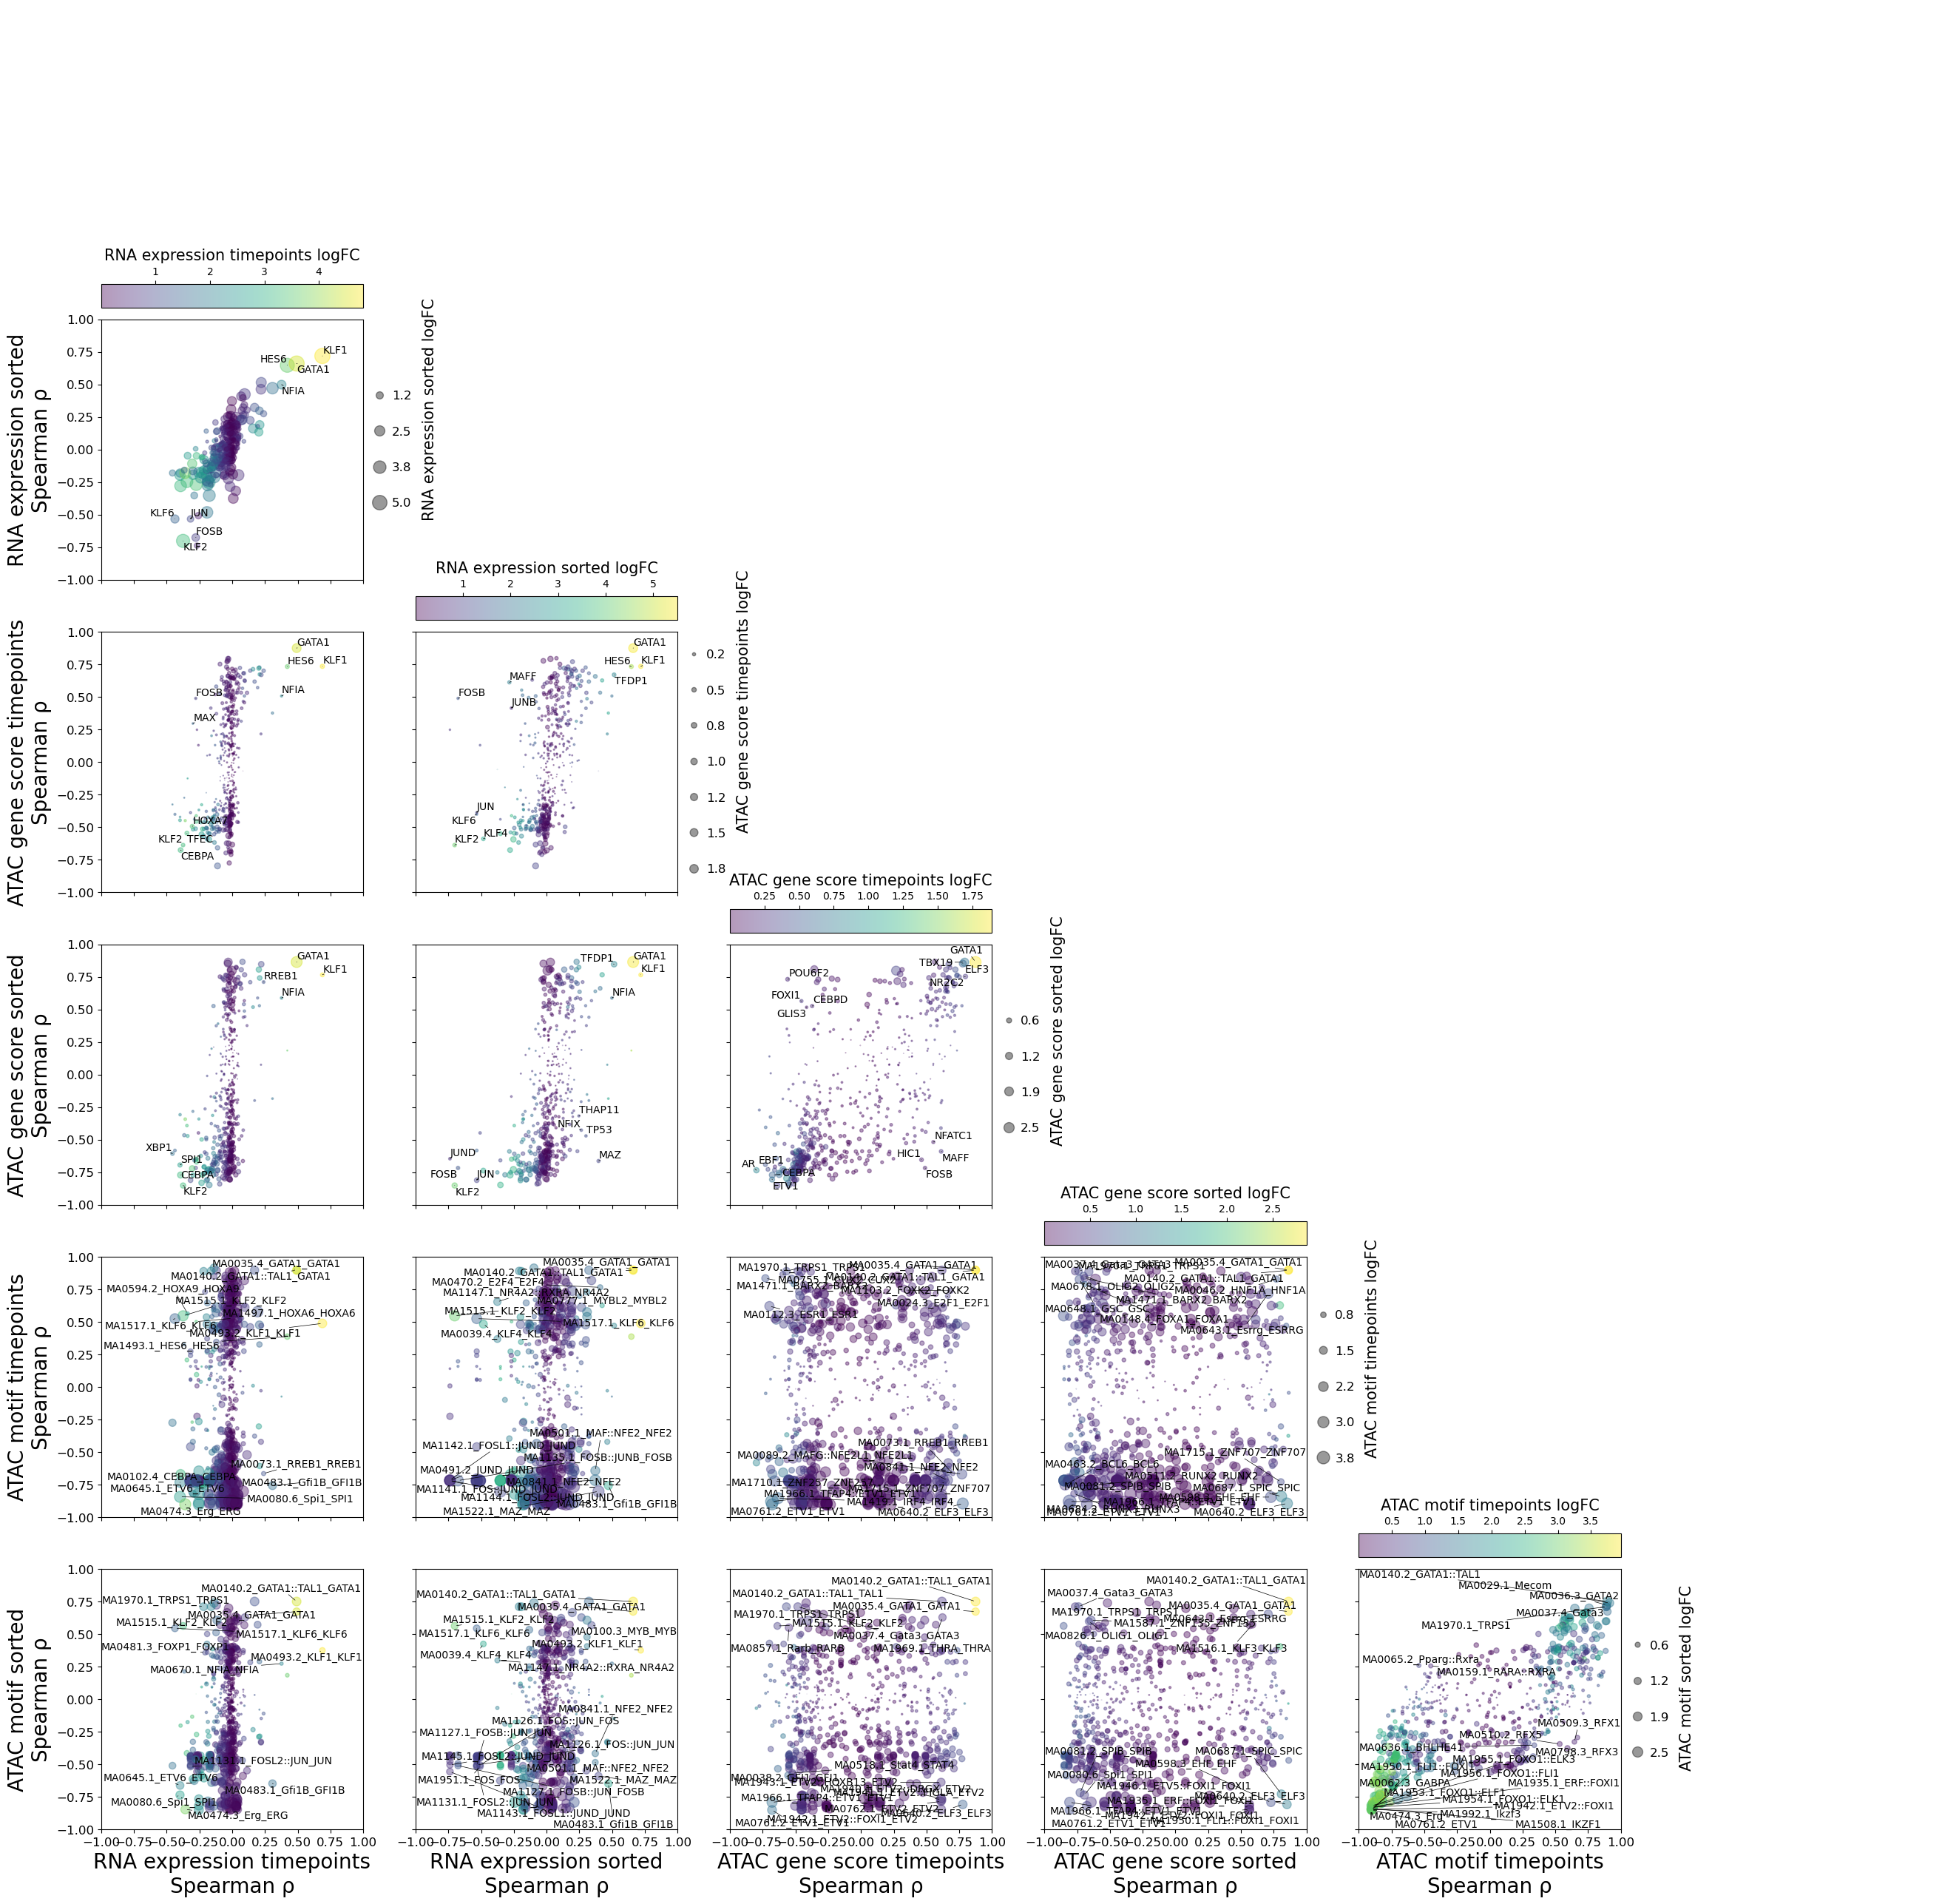

3264 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
Matrix contains negative values...
644 markers are being scanned ...
3999 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
Matrix contains negative values...
644 markers are being scanned ...
3264 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
531 markers are being scanned ...
3999 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
531 markers are being scanned ...
4697 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
Matrix contains negative values...


/mnt/c/Users/jobac/Desktop/all/git/STREAM2/stream2/tools/_markers.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg.iloc[:, i] = df_gene - minValues[i]
/mnt/c/Users/jobac/Desktop/all/git/STREAM2/stream2/tools/_markers.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg.iloc[:, i] = df_gene - minValues[i]
/mnt/c/Users/jobac/Desktop/all/git/STREAM2/stream2/tools/_markers.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

533 markers are being scanned ...
10705 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
Matrix contains negative values...


/mnt/c/Users/jobac/Desktop/all/git/STREAM2/stream2/tools/_markers.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg.iloc[:, i] = df_gene - minValues[i]
/mnt/c/Users/jobac/Desktop/all/git/STREAM2/stream2/tools/_markers.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg.iloc[:, i] = df_gene - minValues[i]
/mnt/c/Users/jobac/Desktop/all/git/STREAM2/stream2/tools/_markers.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

533 markers are being scanned ...


<Figure size 640x480 with 0 Axes>

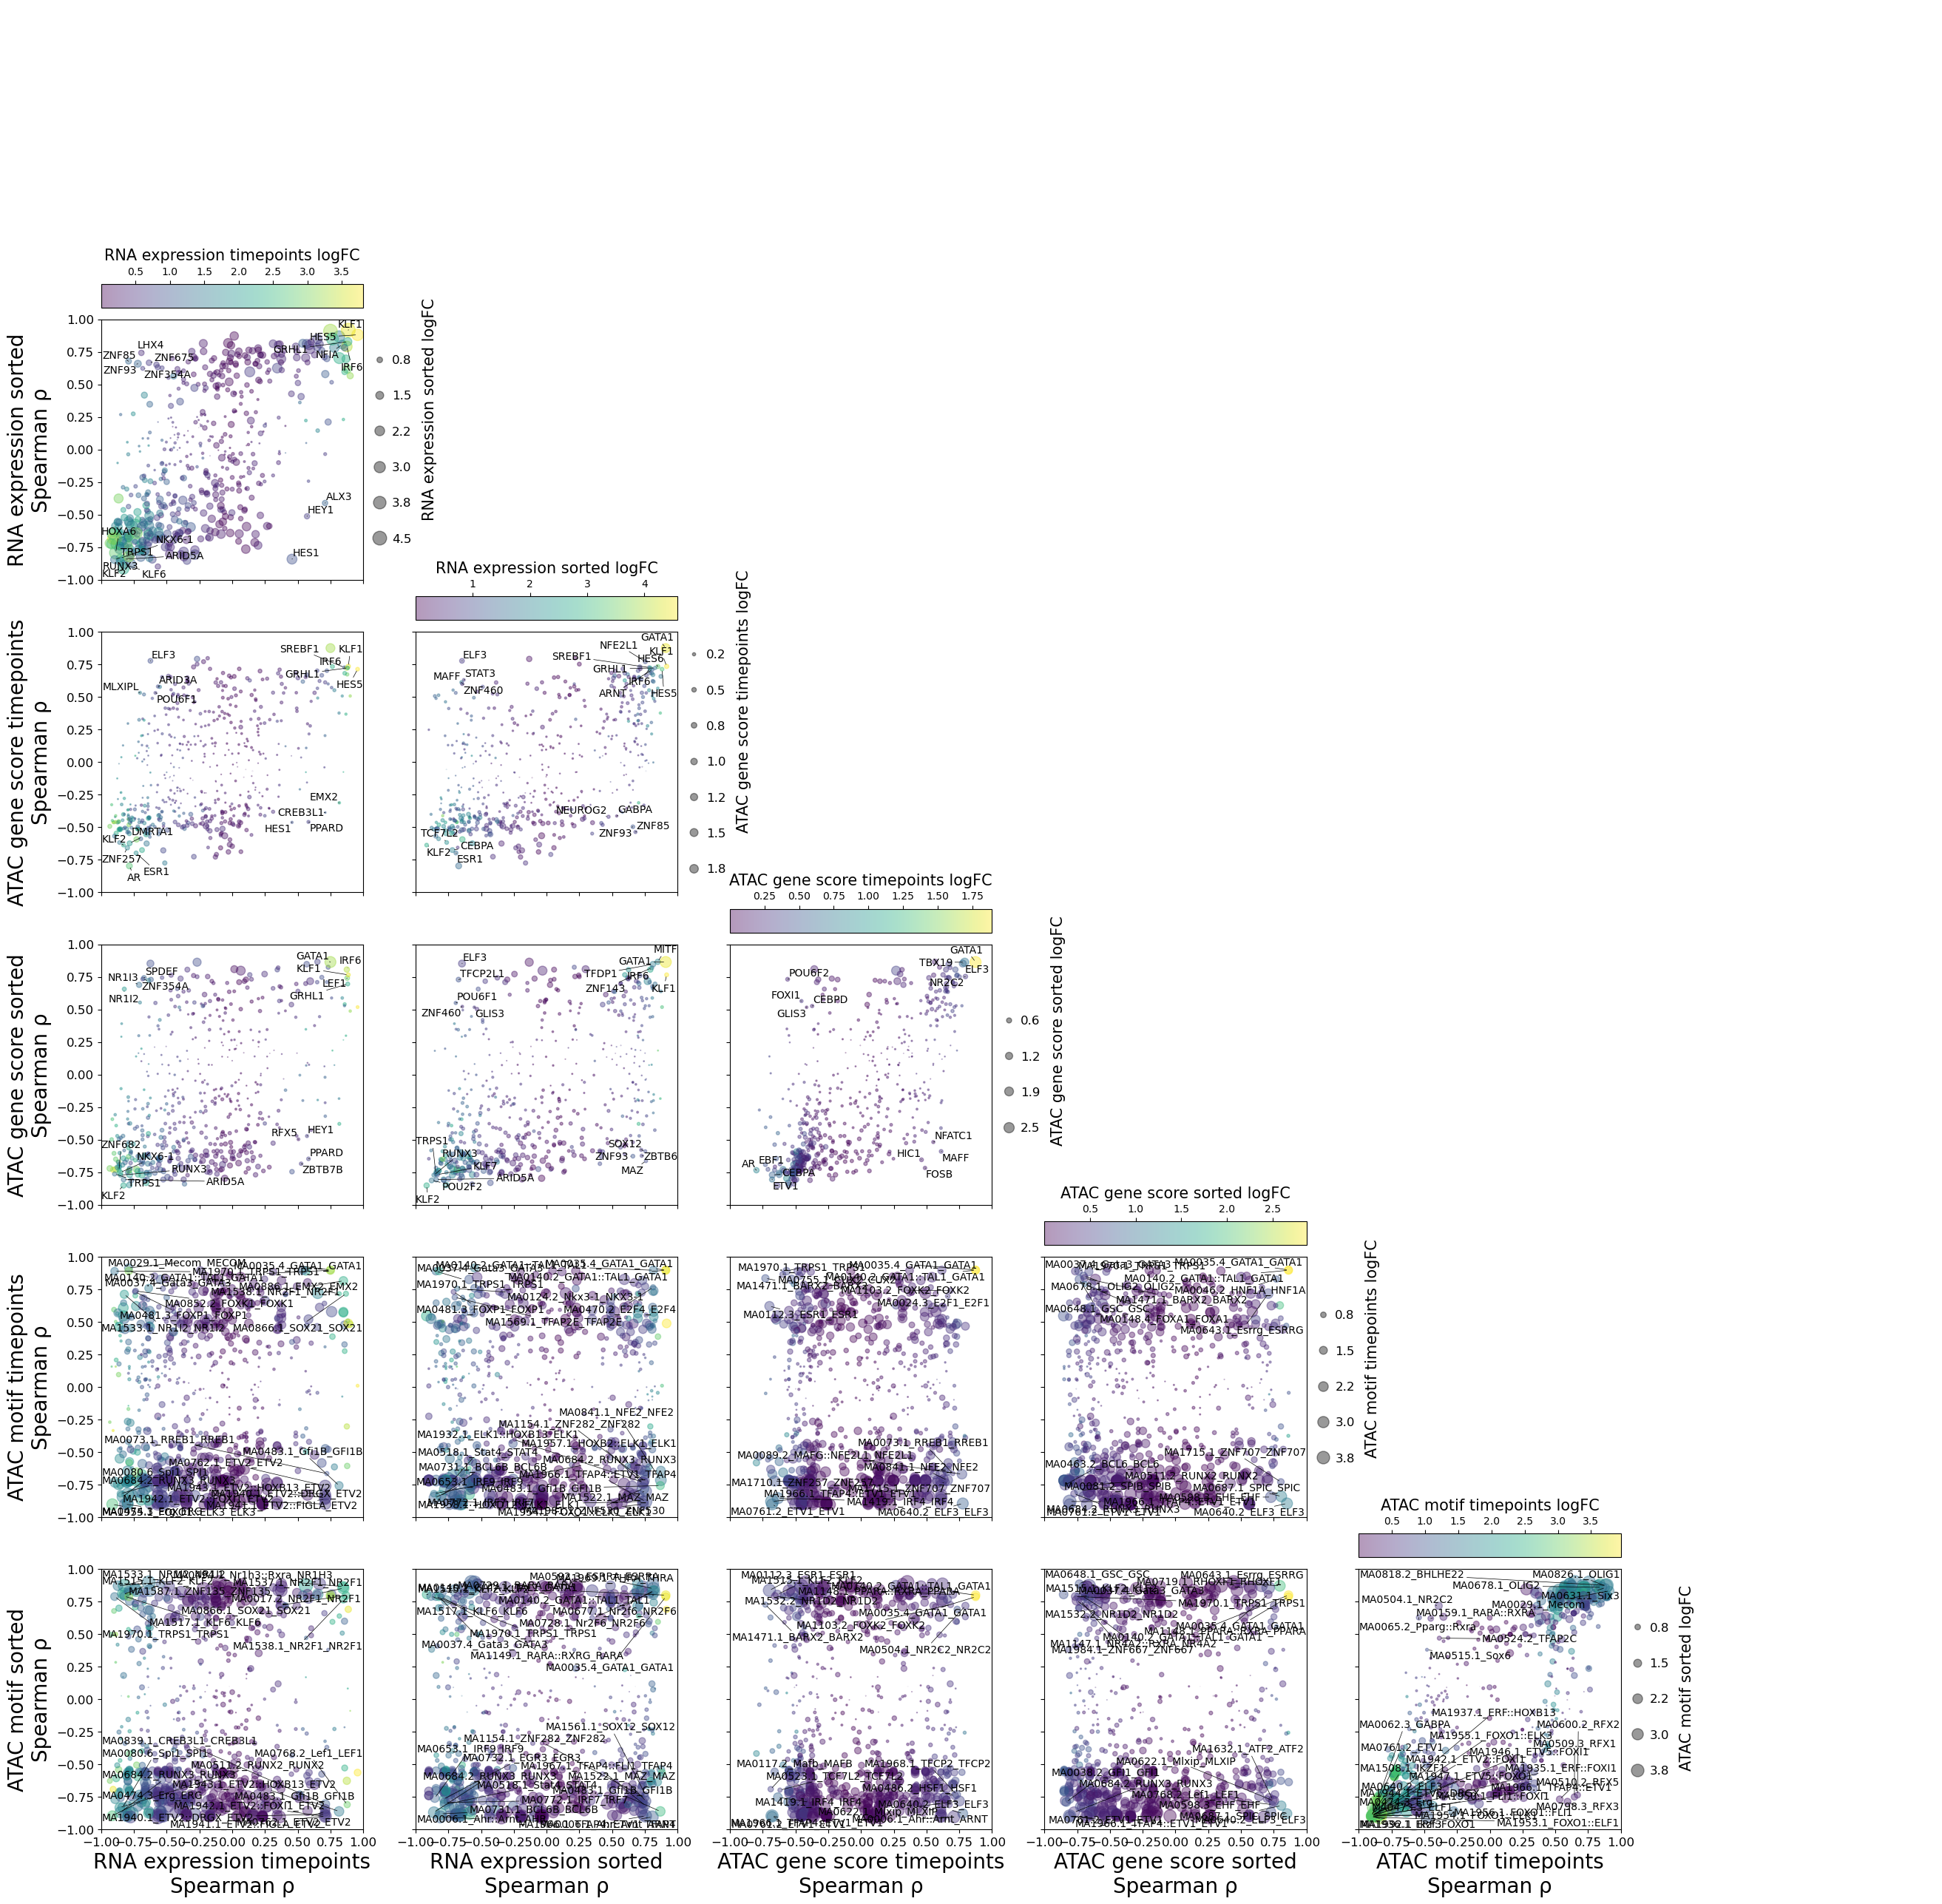

/home/jo/anaconda3/envs/stream2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


200 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
Matrix contains negative values...


/mnt/c/Users/jobac/Desktop/all/git/STREAM2/stream2/tools/_markers.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg.iloc[:, i] = df_gene - minValues[i]
/mnt/c/Users/jobac/Desktop/all/git/STREAM2/stream2/tools/_markers.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg.iloc[:, i] = df_gene - minValues[i]
/mnt/c/Users/jobac/Desktop/all/git/STREAM2/stream2/tools/_markers.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

612 markers are being scanned ...


/tmp/ipykernel_180/2642128618.py:48: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  a_ = sc.AnnData(pd.DataFrame(a.uns['X_interp'],columns=a.var_names),uns=a.uns)
/home/jo/anaconda3/envs/stream2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


200 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
Matrix contains negative values...


/mnt/c/Users/jobac/Desktop/all/git/STREAM2/stream2/tools/_markers.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg.iloc[:, i] = df_gene - minValues[i]
/mnt/c/Users/jobac/Desktop/all/git/STREAM2/stream2/tools/_markers.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg.iloc[:, i] = df_gene - minValues[i]
/mnt/c/Users/jobac/Desktop/all/git/STREAM2/stream2/tools/_markers.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

534 markers are being scanned ...


/home/jo/anaconda3/envs/stream2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


200 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
531 markers are being scanned ...


/home/jo/anaconda3/envs/stream2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


200 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
531 markers are being scanned ...


/home/jo/anaconda3/envs/stream2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


200 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
519 markers are being scanned ...


/home/jo/anaconda3/envs/stream2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


200 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
512 markers are being scanned ...


KeyError: "['MA0488.1_JUN', 'MA0497.1_MEF2C', 'MA0639.1_DBP', 'MA0660.1_MEF2B', 'MA0752.1_ZNF410', 'MA0773.1_MEF2D', 'MA0838.1_CEBPG', 'MA0843.1_TEF', 'MA1478.1_DMRTA2', 'MA1552.1_RARB', 'MA1553.1_RARG', 'MA1589.1_ZNF140', 'MA1707.1_DMRTA1', 'MA1710.1_ZNF257', 'MA1720.1_ZNF85', 'MA1636.1_CEBPG', 'MA1725.1_ZNF189', 'MA0833.2_ATF4', 'MA0102.4_CEBPA', 'MA0836.2_CEBPD', 'MA0043.3_HLF', 'MA0052.4_MEF2A', 'MA0025.2_NFIL3', 'MA0081.2_SPIB', 'MA0003.4_TFAP2A', 'MA0093.3_USF1', 'MA0466.3_CEBPB', 'MA0837.2_CEBPE', 'MA0602.1_Arid5a', 'MA1999.1_Prdm5', 'MA0080.6_Spi1', 'MA0074.1_RXRA::VDR'] not in index"

<Figure size 640x480 with 0 Axes>

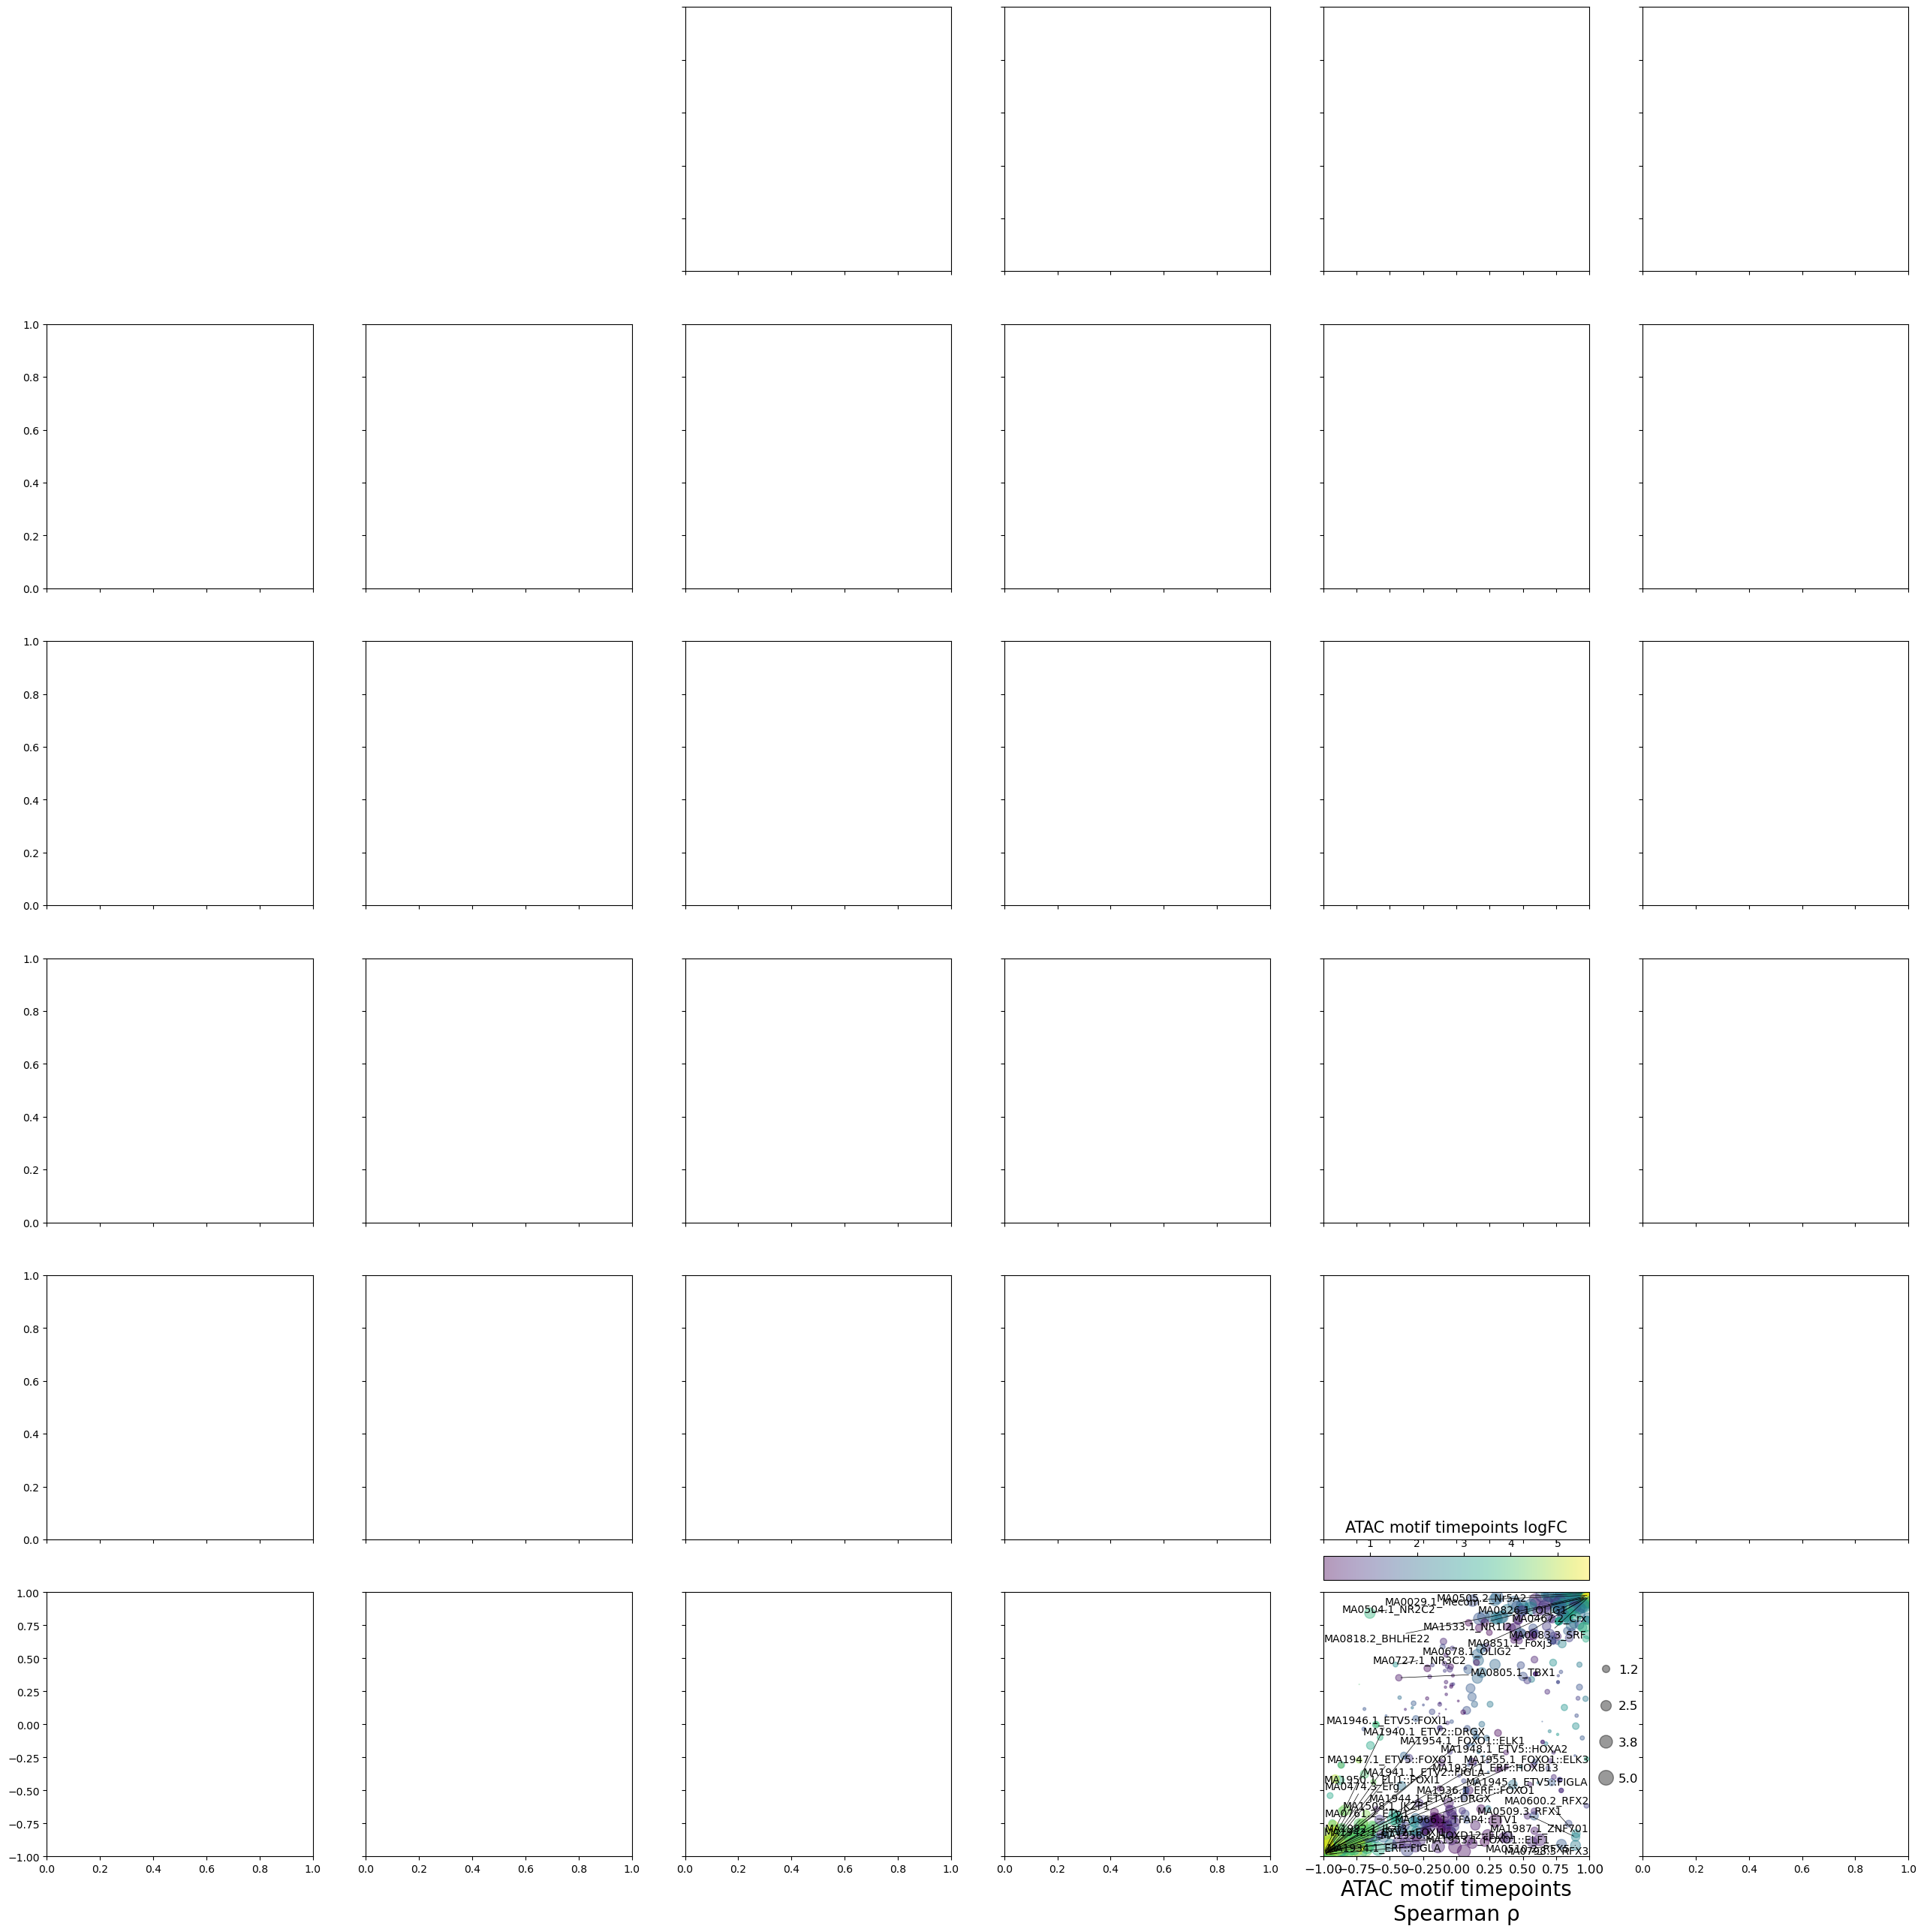

In [15]:
### DETAILED ASSAYS
    
source_target = {
    'Erythroid':(40,103),
    #'MKP':(40,110),
    #'Basophil':(40,109),
    #'Neutrophil':(40,106),
    #'Monocyte':(40,15),
    #'Myeloid DC':(40,107),
    #'Plasmacytoid DC':(40,105),
    #'DC-like Monocyte':(40,26),
    #'Neu-like Monocyte':(40,108),
    #'Lymphoid':(40,104),
}


for use_smooth in ['none', 'magic','knn']:
    for name,(source,target) in source_target.items():

        save_name = f'{name}_{source}_{target}_smooth_{use_smooth}_detailed_X_plot'
        transition_markers={}

        # get pseudotime, markers
        for n,a in zip(names_test,adatas_test):
            if 'motifs' in n:
                adata_assay=adata_transp[adata_transp.obs['assay_detailed']=='ATAC_'+n.split('_')[-1]]
            else:
                adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]
            a.obsm['X_dr']=adata_assay.obsm['X_dr'].copy()
            a.uns=adata_assay.uns.copy()
            st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')
            st2.tl.infer_pseudotime(a,source,target)
            
            if use_smooth=='magic':
                a.obsm['X']=a.X.copy()
                if 'RNA' in n:
                    a.X=a.obsm['X_smooth']
                elif 'motif' in n:
                    a.X=a.layers['z_imp']
                a_ = a

            elif use_smooth=='knn':
                a.uns['X_interp_pseudotime'], a.uns['X_interp'] = st2.tl.interpolate(a)
                a_ = sc.AnnData(pd.DataFrame(a.uns['X_interp'],columns=a.var_names),uns=a.uns)
                a_.obs['epg_node_id'] = source
                a_.obs['epg_pseudotime'] = a.uns['X_interp_pseudotime']
            else:
                a_ = a
                
            st2.tl.detect_transition_markers(a_,fc_cutoff=0.,min_num_cells=0,method='spearman')
            transition_markers[n] = a_.uns['transition_markers'][f'Path_{source}-None-{target}']
            
            if use_smooth=='magic':
                a_.X = a_.obsm['X']
                del a_.obsm['X']
            del a_.uns['scaled_marker_expr']
            gc.collect()

        # interpolate
        interpolated = {}
        for assay,adata in zip(names_test,adatas_test): 
            xs, interpolated[assay] = st2.tl.interpolate(adata,t_len=200,method='knn',frac=.1,n_neighbors='auto',weights='uniform')

        # correlate
        correlations = {}
        modalities = names_test
        for i in range(len(modalities)):
            for j in range(i+1,len(modalities)):
                #comparing to motifs
                if interpolated[modalities[i]].shape > interpolated[modalities[j]].shape:
                    dfj=pd.DataFrame(interpolated[modalities[j]],columns=adatas_test[j].var_names)
                    dfi=pd.DataFrame(interpolated[modalities[i]],columns=adatas_test[i].var_names)
                    correlations[modalities[i],modalities[j]] = st2.tl.spearman_columns(dfi[idx_motifs].to_numpy(),dfj[idx_genes].to_numpy())

                else:   
                    correlations[modalities[i],modalities[j]] = st2.tl.spearman_columns(interpolated[modalities[i]],
                                                                                         interpolated[modalities[j]])

        # plot
        f,axs=plt.subplots(len(modalities),len(modalities),figsize=(32,32),sharex='col',sharey='row')
        for i in range(len(modalities)):
            for j in range(i+1,len(modalities)):
                #color = correlations[modalities[i],modalities[j]].rename('correlation '+modalities[i]+' vs '+modalities[j])
                max_factor = 3 if j==(len(modalities)-1) else 2
                if (j-1)==i: show_cb = show_markers = True 
                else:  show_cb = show_markers = False 

                plot_two_assays(axs[len(modalities)-(i+1),len(modalities)-(j+1)],transition_markers,modalities, names_plot2, i,j, idx_motifs=idx_motifs,idx_genes=idx_genes,
                                plot_var='stat',show_cb=show_cb,show_markers=show_markers,show_text=1,)
                axs[len(modalities)-(i+1),len(modalities)-(j+1)].tick_params(axis='both', which='major', labelsize=12)

                if i<j:
                    axs[i,i].axis('off')
                    axs[i,j].axis('off')

        axs[-1,-1].axis('off')  
        plt.show()
        plt.savefig(f'figures/hematopoiesis/{save_name}.png',dpi=300,bbox_inches='tight')

3264 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
Matrix contains negative values...
644 markers are being scanned ...
3999 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
Matrix contains negative values...
644 markers are being scanned ...
3264 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
531 markers are being scanned ...
3999 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
531 markers are being scanned ...
4697 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
533 markers are being scanned ...
10705 Cell

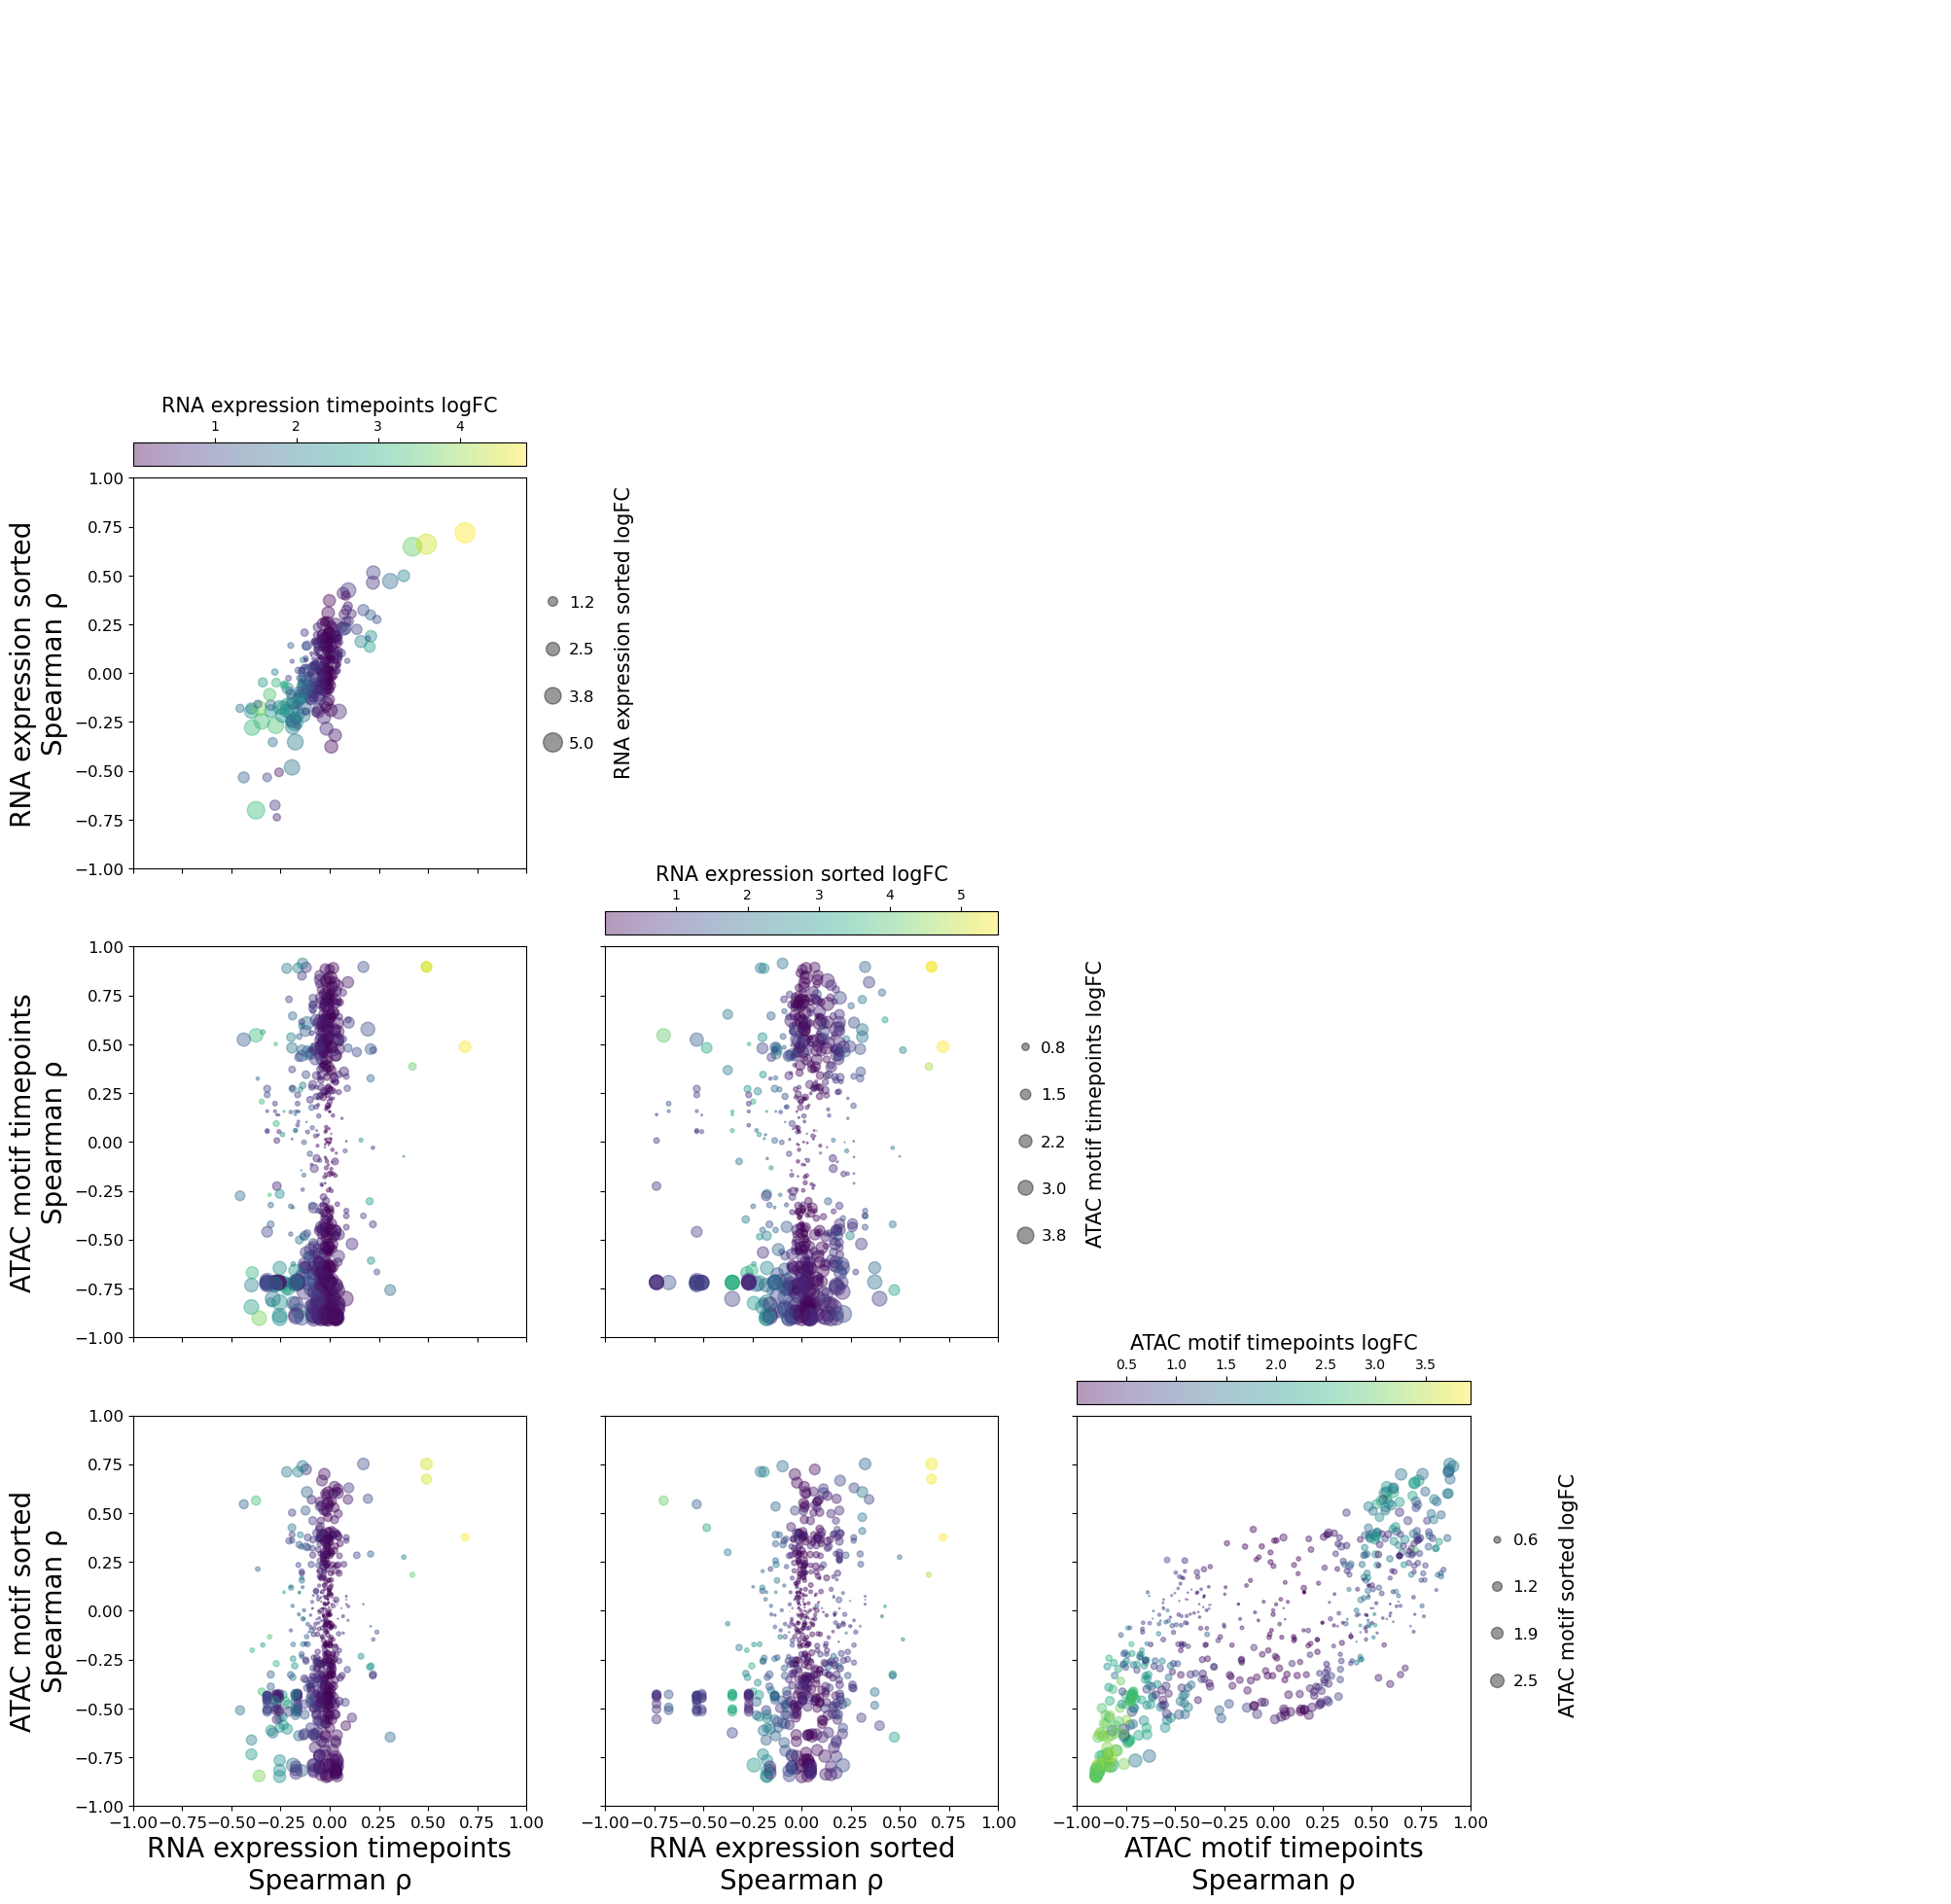

3264 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
Matrix contains negative values...
644 markers are being scanned ...
3999 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
Matrix contains negative values...
644 markers are being scanned ...
3264 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
531 markers are being scanned ...
3999 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
531 markers are being scanned ...
4697 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
Matrix contains negative values...


/mnt/c/Users/jobac/Desktop/all/git/STREAM2/stream2/tools/_markers.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg.iloc[:, i] = df_gene - minValues[i]
/mnt/c/Users/jobac/Desktop/all/git/STREAM2/stream2/tools/_markers.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg.iloc[:, i] = df_gene - minValues[i]
/mnt/c/Users/jobac/Desktop/all/git/STREAM2/stream2/tools/_markers.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

533 markers are being scanned ...
10705 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
Matrix contains negative values...


/mnt/c/Users/jobac/Desktop/all/git/STREAM2/stream2/tools/_markers.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg.iloc[:, i] = df_gene - minValues[i]
/mnt/c/Users/jobac/Desktop/all/git/STREAM2/stream2/tools/_markers.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg.iloc[:, i] = df_gene - minValues[i]
/mnt/c/Users/jobac/Desktop/all/git/STREAM2/stream2/tools/_markers.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

533 markers are being scanned ...


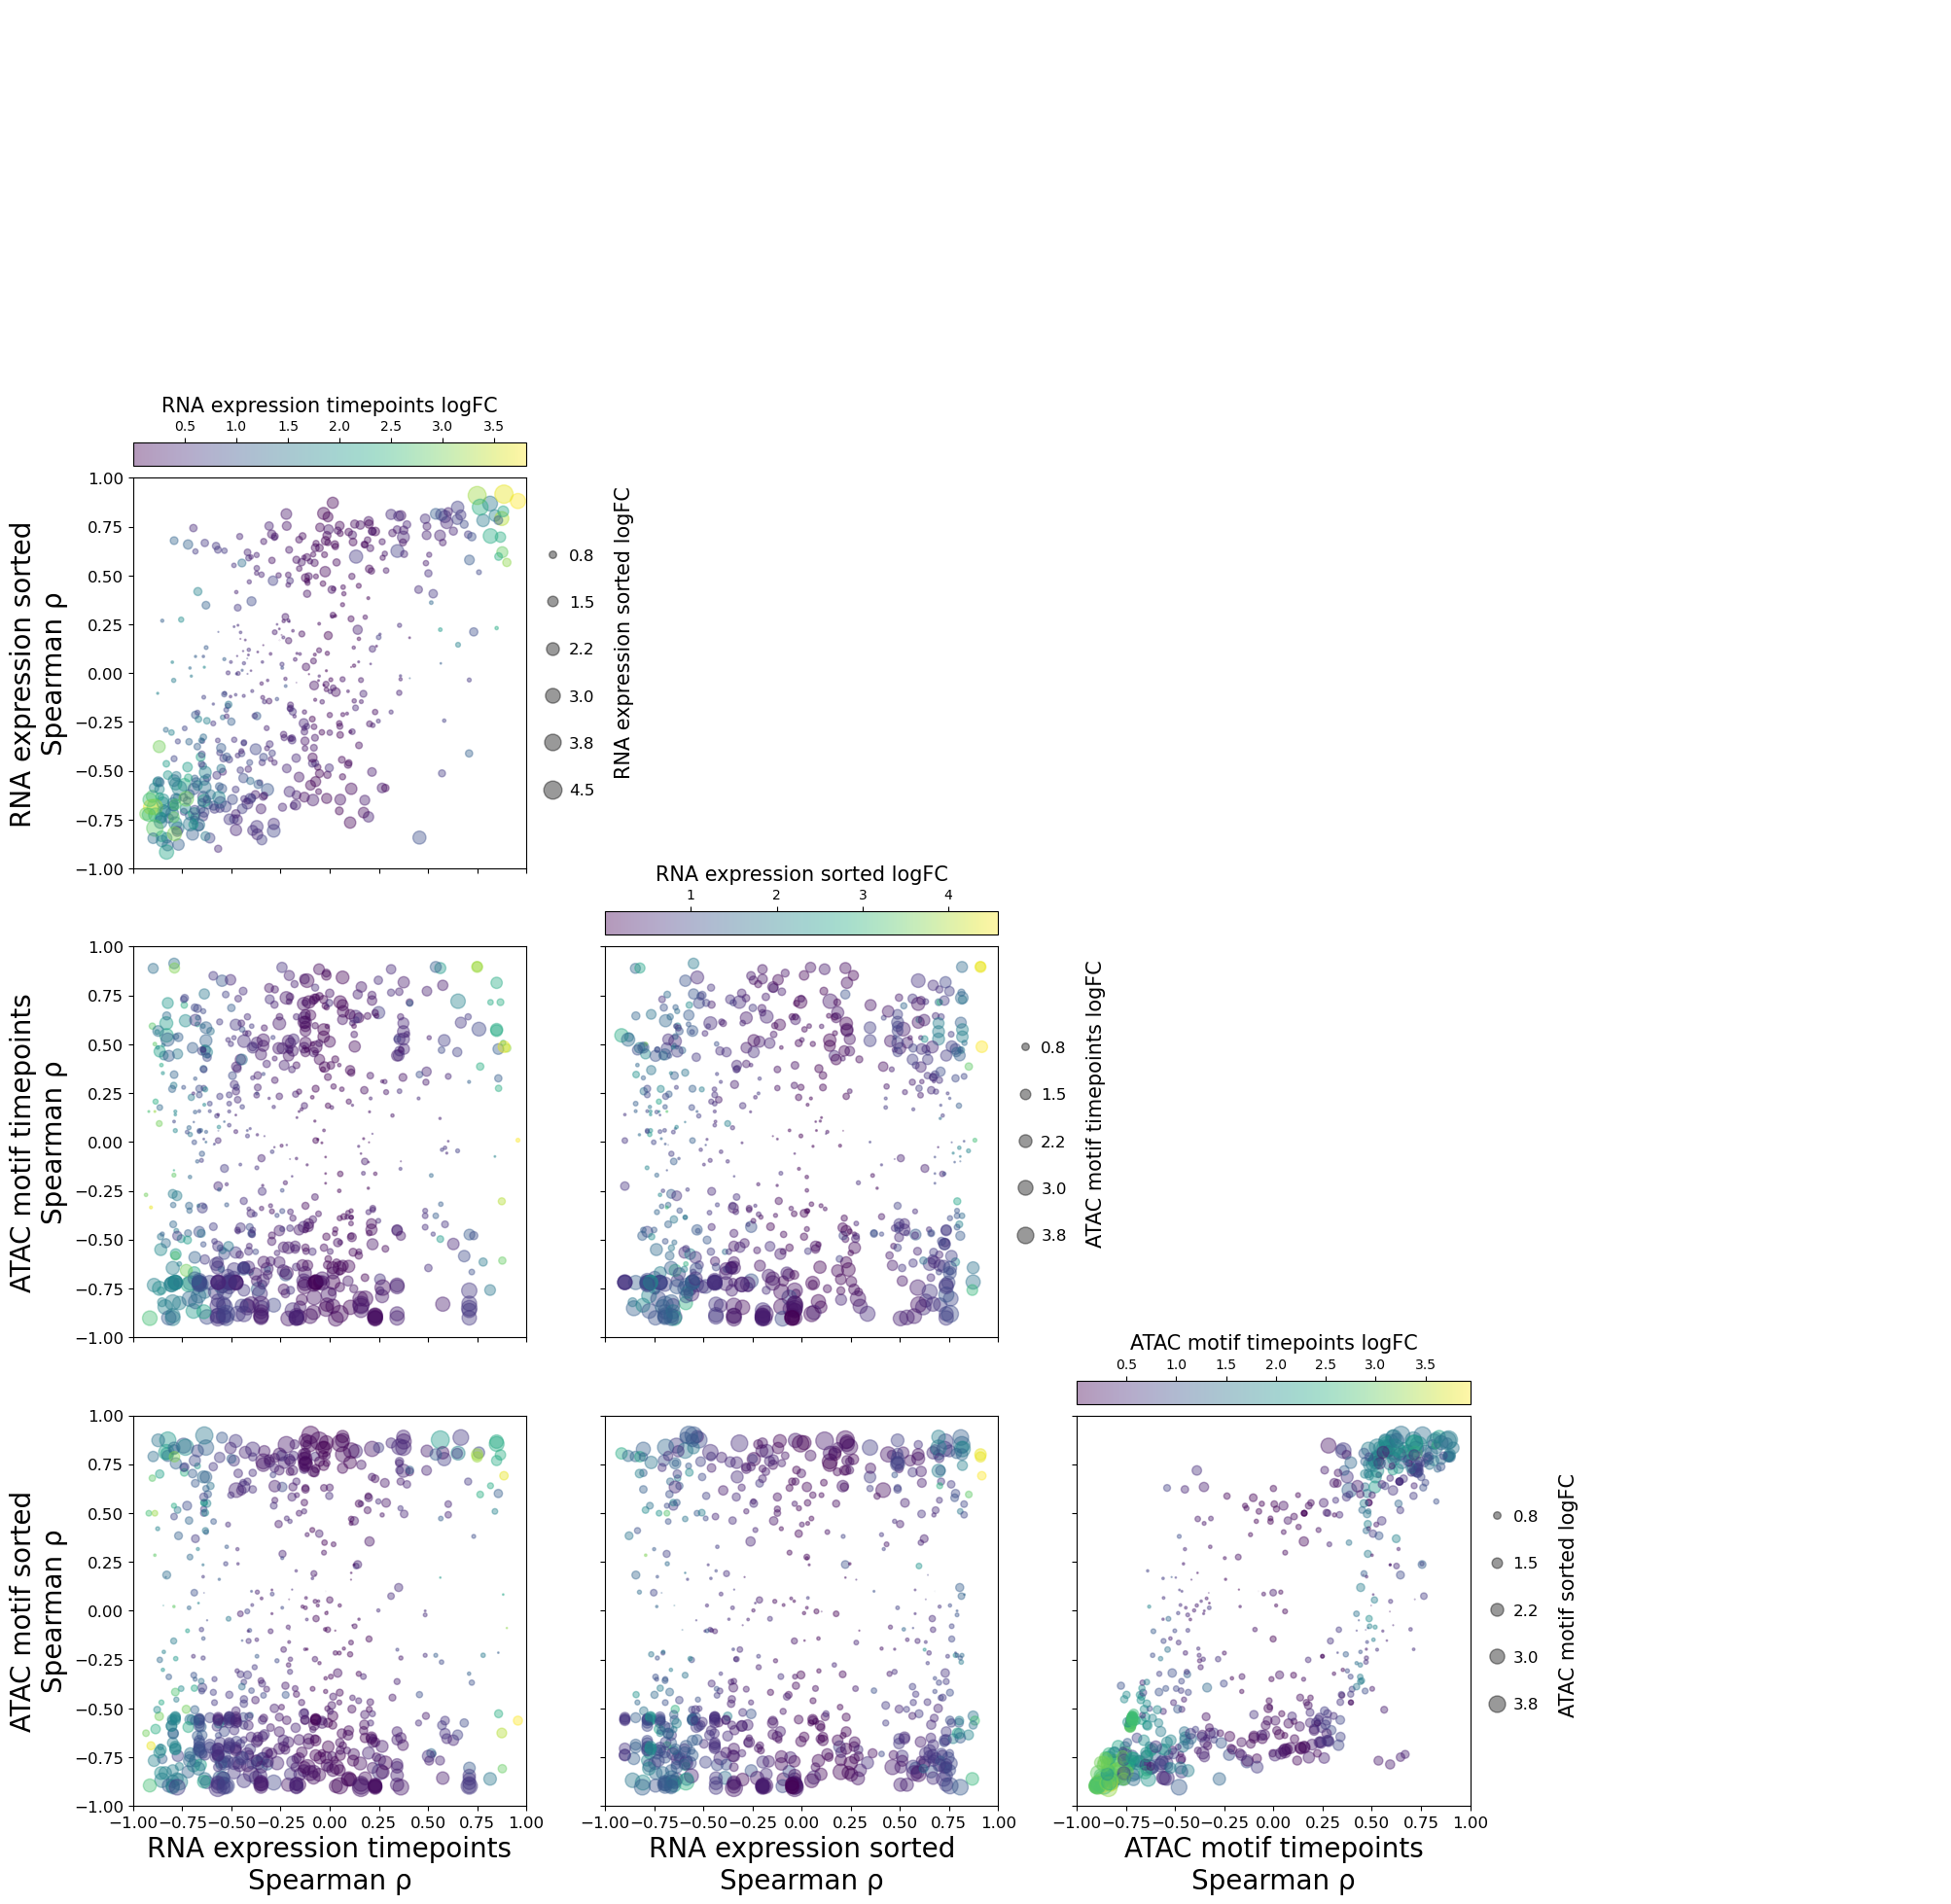

/home/jo/anaconda3/envs/stream2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


200 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
Matrix contains negative values...


/mnt/c/Users/jobac/Desktop/all/git/STREAM2/stream2/tools/_markers.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg.iloc[:, i] = df_gene - minValues[i]
/mnt/c/Users/jobac/Desktop/all/git/STREAM2/stream2/tools/_markers.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg.iloc[:, i] = df_gene - minValues[i]
/mnt/c/Users/jobac/Desktop/all/git/STREAM2/stream2/tools/_markers.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

612 markers are being scanned ...


/tmp/ipykernel_180/1374404196.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  a_ = sc.AnnData(pd.DataFrame(a.uns['X_interp'],columns=a.var_names),uns=a.uns)
/home/jo/anaconda3/envs/stream2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


200 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
Matrix contains negative values...


/mnt/c/Users/jobac/Desktop/all/git/STREAM2/stream2/tools/_markers.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg.iloc[:, i] = df_gene - minValues[i]
/mnt/c/Users/jobac/Desktop/all/git/STREAM2/stream2/tools/_markers.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg.iloc[:, i] = df_gene - minValues[i]
/mnt/c/Users/jobac/Desktop/all/git/STREAM2/stream2/tools/_markers.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

534 markers are being scanned ...


/home/jo/anaconda3/envs/stream2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


200 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
531 markers are being scanned ...


/home/jo/anaconda3/envs/stream2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


200 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
531 markers are being scanned ...


/home/jo/anaconda3/envs/stream2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


200 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
519 markers are being scanned ...


/home/jo/anaconda3/envs/stream2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


200 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_40-None-103
Filtering out markers that are expressed in less than 0 cells ...
512 markers are being scanned ...


KeyError: "['MA0488.1_JUN', 'MA0497.1_MEF2C', 'MA0639.1_DBP', 'MA0752.1_ZNF410', 'MA0773.1_MEF2D', 'MA0838.1_CEBPG', 'MA0843.1_TEF', 'MA1478.1_DMRTA2', 'MA1552.1_RARB', 'MA1553.1_RARG', 'MA1589.1_ZNF140', 'MA1707.1_DMRTA1', 'MA1710.1_ZNF257', 'MA1720.1_ZNF85', 'MA1636.1_CEBPG', 'MA1725.1_ZNF189', 'MA0833.2_ATF4', 'MA0102.4_CEBPA', 'MA0836.2_CEBPD', 'MA0043.3_HLF', 'MA0052.4_MEF2A', 'MA0025.2_NFIL3', 'MA0081.2_SPIB', 'MA0003.4_TFAP2A', 'MA0093.3_USF1', 'MA0466.3_CEBPB', 'MA0602.1_Arid5a', 'MA1999.1_Prdm5', 'MA0080.6_Spi1', 'MA0074.1_RXRA::VDR'] not in index"

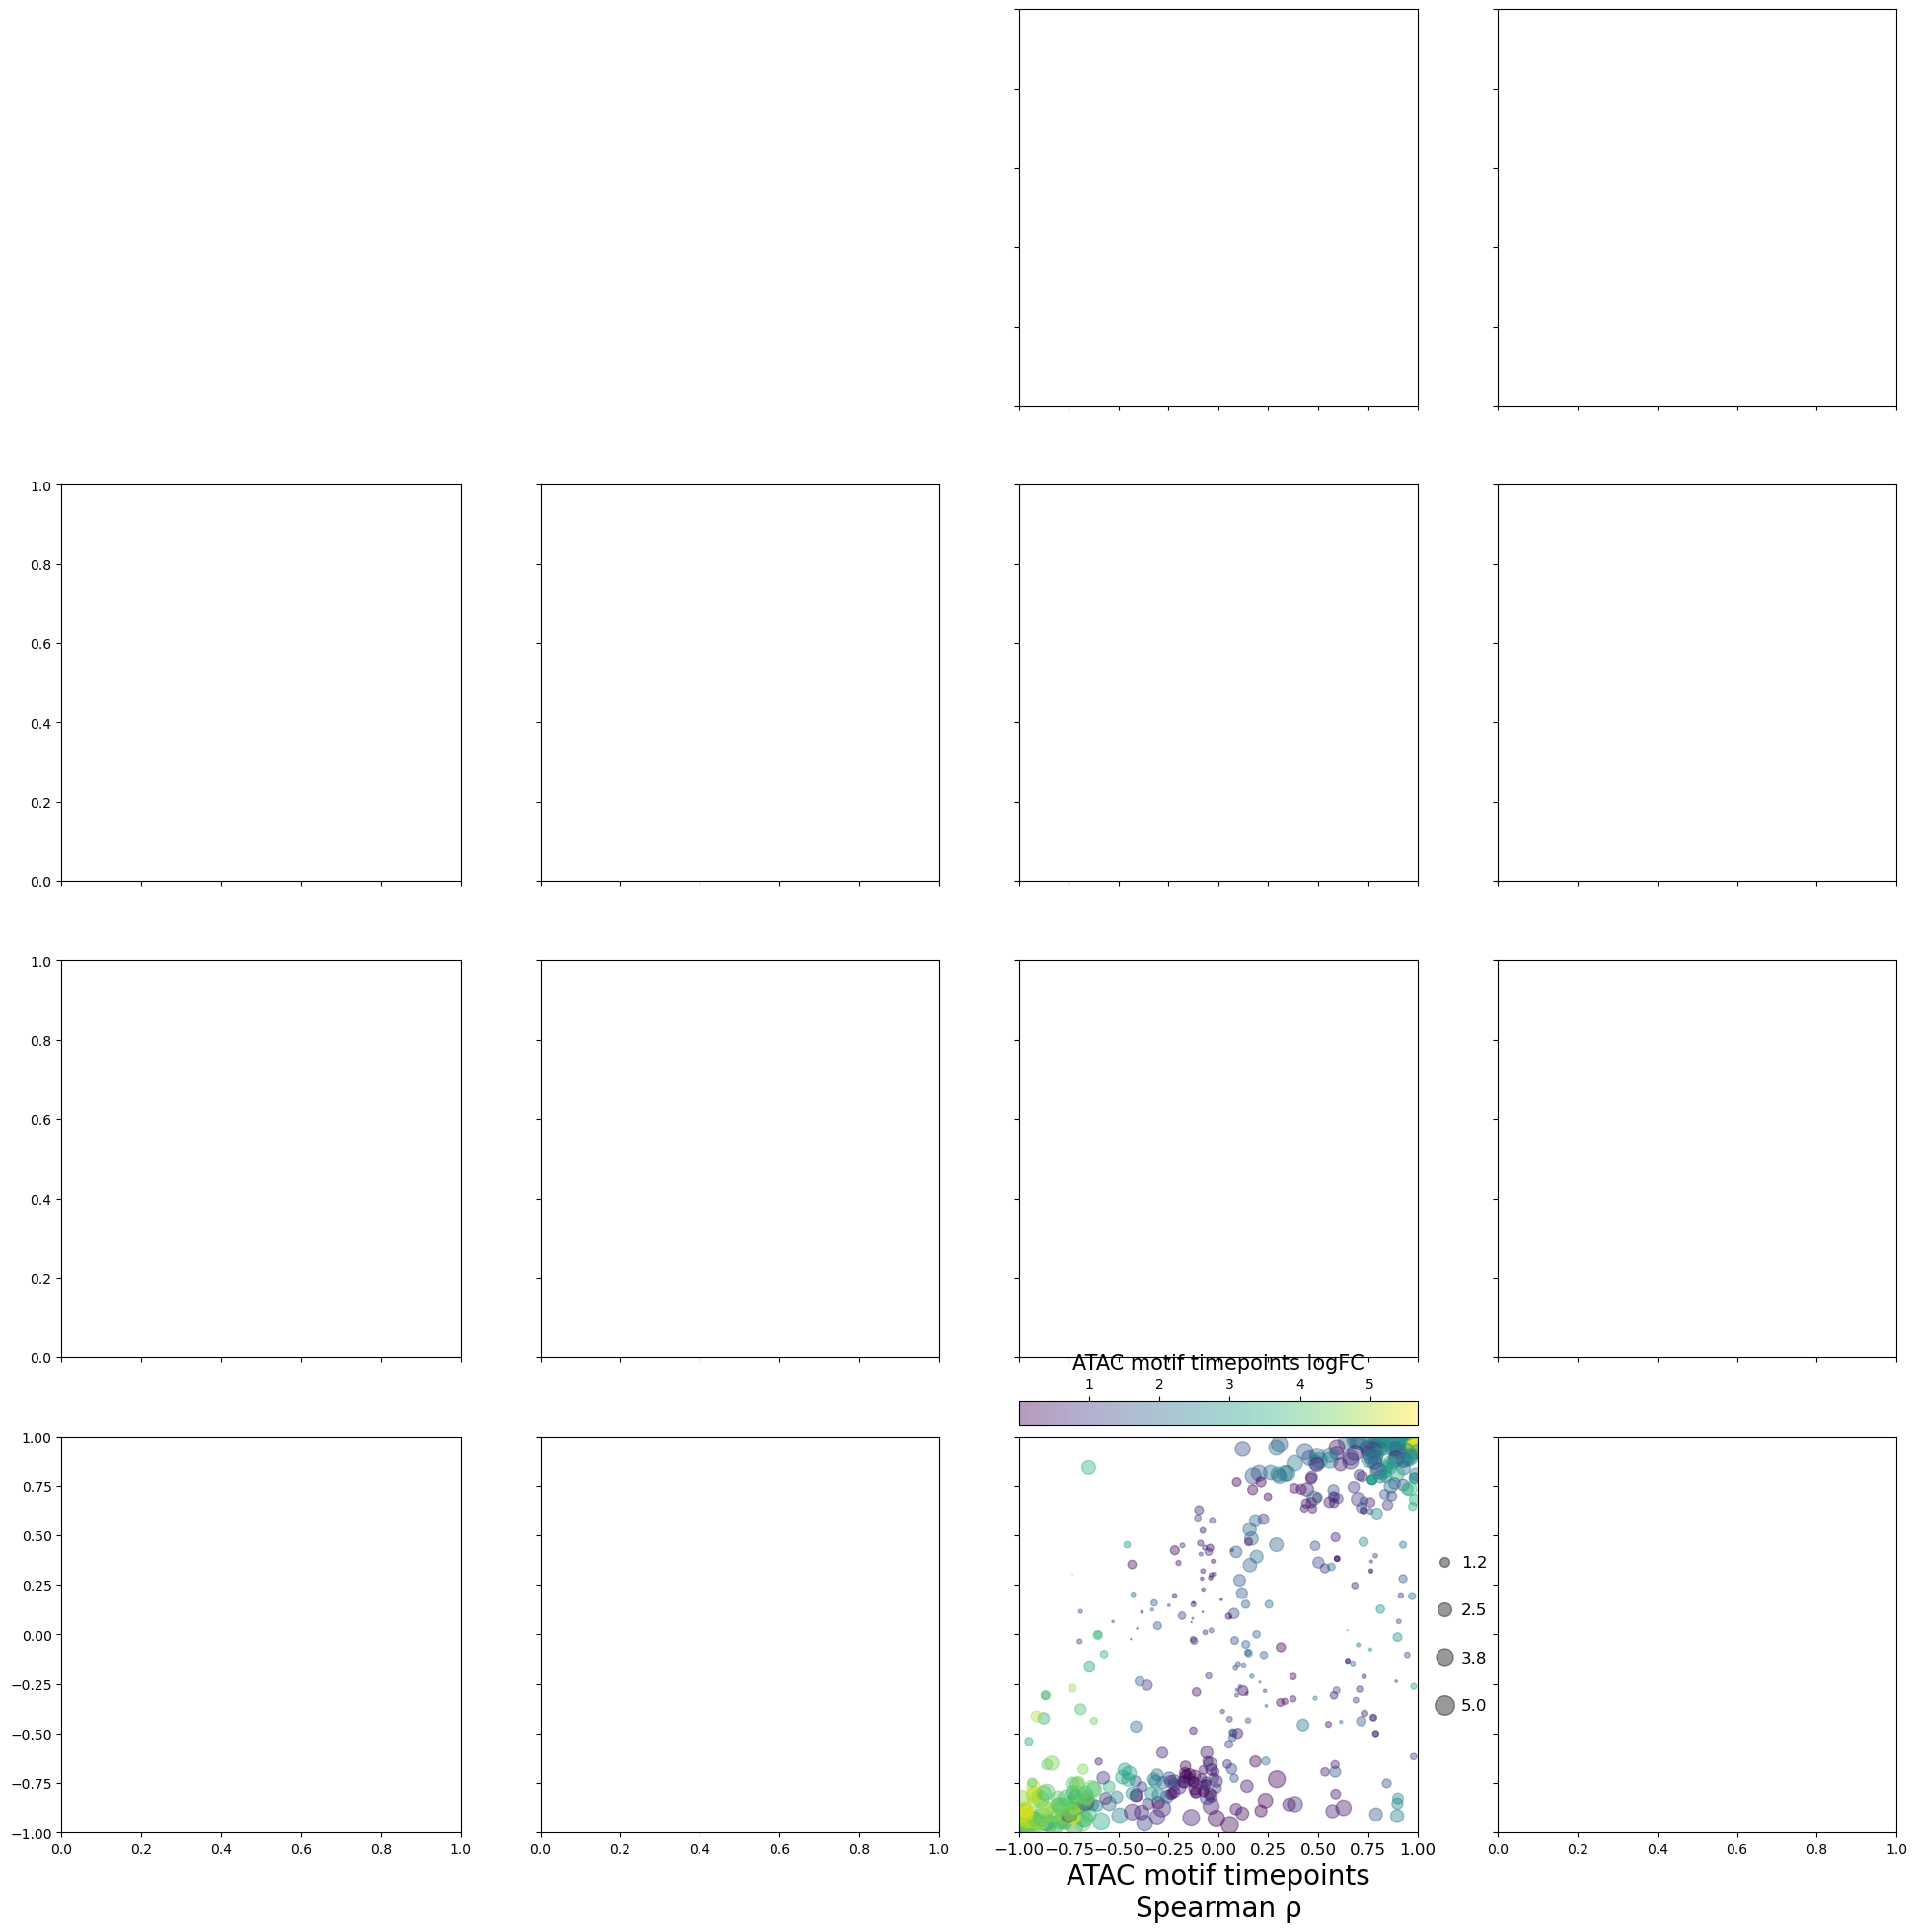

In [17]:
### SEMI-DETAILED ASSAYS
    
source_target = {
    'Erythroid':(40,103),
    #'MKP':(40,110),
    #'Basophil':(40,109),
    #'Neutrophil':(40,106),
    #'Monocyte':(40,15),
    #'Myeloid DC':(40,107),
    #'Plasmacytoid DC':(40,105),
    #'DC-like Monocyte':(40,26),
    #'Neu-like Monocyte':(40,108),
    #'Lymphoid':(40,104),
}

for use_smooth in ['none', 'magic','knn']:
    for name,(source,target) in source_target.items():

        save_name = f'{name}_{source}_{target}_semi_detailed_smooth_{use_smooth}_X_plot_grouped_assays'
        transition_markers={}

        # get pseudotime, markers
        for n,a in zip(names_test,adatas_test):
            if 'motifs' in n:
                adata_assay=adata_transp[adata_transp.obs['assay_detailed']=='ATAC_'+n.split('_')[-1]]
            else:
                adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]
            a.obsm['X_dr']=adata_assay.obsm['X_dr'].copy()
            a.uns=adata_assay.uns.copy()
            st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')
            st2.tl.infer_pseudotime(a,source,target)
            
            if use_smooth=='magic':
                a.obsm['X']=a.X.copy()
                if 'RNA' in n:
                    a.X=a.obsm['X_smooth']
                elif 'motif' in n:
                    a.X=a.layers['z_imp']
                a_ = a

            elif use_smooth=='knn':
                a.uns['X_interp_pseudotime'], a.uns['X_interp'] = st2.tl.interpolate(a)
                a_ = sc.AnnData(pd.DataFrame(a.uns['X_interp'],columns=a.var_names),uns=a.uns)
                a_.obs['epg_node_id'] = source
                a_.obs['epg_pseudotime'] = a.uns['X_interp_pseudotime']
            else:
                a_ = a
                
            st2.tl.detect_transition_markers(a_,fc_cutoff=0.,min_num_cells=0,method='spearman')
            transition_markers[n] = a_.uns['transition_markers'][f'Path_{source}-None-{target}']
            
            if use_smooth=='magic':
                a_.X = a_.obsm['X']
                del a_.obsm['X']
            del a_.uns['scaled_marker_expr']
            gc.collect()

        # interpolate
        interpolated = {}
        for assay,adata in zip(names_test,adatas_test): 
            xs, interpolated[assay] = st2.tl.interpolate(adata,t_len=200,method='knn',frac=.1,n_neighbors='auto',weights='uniform')

        # correlate
        correlations = {}
        modalities = [n for n in names_test if 'ATAC' not in n]
        modalities_names_plot = [n.replace('\n','') for n in names_plot2 if 'score' not in n]
        for i in range(len(modalities)):
            for j in range(i+1,len(modalities)):
                #comparing to motifs
                if interpolated[modalities[i]].shape > interpolated[modalities[j]].shape:
                    dfj=pd.DataFrame(interpolated[modalities[j]],columns=adatas_test[j].var_names)
                    dfi=pd.DataFrame(interpolated[modalities[i]],columns=adatas_test[i].var_names)
                    correlations[modalities[i],modalities[j]] = st2.tl.spearman_columns(dfi[idx_motifs].to_numpy(),dfj[idx_genes].to_numpy())

                else:   
                    correlations[modalities[i],modalities[j]] = st2.tl.spearman_columns(interpolated[modalities[i]],
                                                                                         interpolated[modalities[j]])

        f,axs=plt.subplots(len(modalities),len(modalities),figsize=(24,24),sharex='col',sharey='row')
        for i in range(len(modalities)):
            for j in range(i+1,len(modalities)):
                #color = correlations[modalities[i],modalities[j]].rename('correlation '+modalities[i]+' vs '+modalities[j])
                max_factor = 3 if j==(len(modalities)-1) else 2
                if (j-1)==i: show_cb = show_markers = True 
                else:  show_cb = show_markers = False 

                plot_two_assays(axs[len(modalities)-(i+1),len(modalities)-(j+1)],transition_markers,modalities, modalities_names_plot, i,j, idx_motifs=idx_motifs,idx_genes=idx_genes,
                                plot_var='stat',show_cb=show_cb,show_markers=show_markers,show_text=1,)
                axs[len(modalities)-(i+1),len(modalities)-(j+1)].tick_params(axis='both', which='major', labelsize=12)

                if i<j:
                    axs[i,i].axis('off')
                    axs[i,j].axis('off')

        axs[-1,-1].axis('off')     
        plt.savefig(f'figures/hematopoiesis/{save_name}.png',dpi=300,bbox_inches='tight')
        plt.show()

In [ ]:
### GROUPED ASSAYS

source_target = {
    'Erythroid':(40,103),
    #'MKP':(40,110),
    #'Basophil':(40,109),
    #'Neutrophil':(40,106),
    #'Monocyte':(40,15),
    #'Myeloid DC':(40,107),
    #'Plasmacytoid DC':(40,105),
    #'DC-like Monocyte':(40,26),
    #'Neu-like Monocyte':(40,108),
    #'Lymphoid':(40,104),
}



for use_smooth in ['none', 'magic','knn']:
    for name,(source,target) in source_target.items():

        save_name = f'{name}_{source}_{target}_smooth_{use_smooth}_X_plot_grouped_assays'

    transition_markers={}
    # get pseudotime, markers
    results_adatas={}
    for i,n,ix in zip(range(3),['ATAC motif','ATAC gene score','RNA expression'],[[0,1],[2,3],[4,5]]):
        adata_assay=adata_transp[adata_transp.obs['assay']==n.split(' ')[0]]  
        a=adatas_test[ix[0]].concatenate(adatas_test[ix[1]],index_unique=None)
        a.obsm['X_dr']=a.obsm['X_umap']=adata_assay.obsm['X_dr'].copy()
        a.uns=adata_assay.uns.copy()

        st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')
        st2.tl.infer_pseudotime(a,source,target)

        if use_smooth=='magic':
            a.obsm['X']=a.X.copy()
            if 'RNA' in n:
                a.X=a.obsm['X_smooth']
            elif 'motif' in n:
                a.X=a.layers['z_imp']
            a_ = a
        elif use_smooth=='knn':
            a.uns['X_interp_pseudotime'], a.uns['X_interp'] = st2.tl.interpolate(a)
            a_ = sc.AnnData(pd.DataFrame(a.uns['X_interp'],columns=a.var_names),uns=a.uns)
            a_.obs['epg_node_id'] = source
            a_.obs['epg_pseudotime'] = a.uns['X_interp_pseudotime']
        else:
            a_ = a

        st2.tl.detect_transition_markers(a_,fc_cutoff=0.,min_num_cells=0,method='spearman')
        transition_markers[n] = a_.uns['transition_markers'][f'Path_{source}-None-{target}']

        if use_smooth=='magic':
            a_.X = a_.obsm['X']
            del a_.obsm['X']
        del a_.uns['scaled_marker_expr']
        gc.collect()
        
        results_adatas[n]=a 
    
    # interpolate
    interpolated = {}
    for assay,adata in results_adatas.items(): 
        xs, interpolated[assay] = st2.tl.interpolate(adata,t_len=200,method='knn',frac=.1,n_neighbors='auto',weights='uniform')


    # correlate
    correlations = {}
    modalities = ['ATAC motif','ATAC gene score','RNA expression']
    for i in range(len(modalities)):
        for j in range(i+1,len(modalities)):
            #comparing to motifs
            if interpolated[modalities[i]].shape > interpolated[modalities[j]].shape:
                dfj=pd.DataFrame(interpolated[modalities[j]],columns=results_adatas[list(results_adatas.keys())[j]].var_names)
                dfi=pd.DataFrame(interpolated[modalities[i]],columns=results_adatas[list(results_adatas.keys())[i]].var_names)
                correlations[modalities[i],modalities[j]] = st2.tl.spearman_columns(dfi[idx_motifs].to_numpy(),dfj[idx_genes].to_numpy())

            else:   
                correlations[modalities[i],modalities[j]] = st2.tl.spearman_columns(interpolated[modalities[i]],
                                                                                     interpolated[modalities[j]])
    # plot
    f,axs=plt.subplots(len(modalities),len(modalities),figsize=(21,21),sharex='col',sharey='row')
    for i in range(len(modalities)):
        for j in range(i+1,len(modalities)):
            #color = correlations[modalities[i],modalities[j]].rename('correlation '+modalities[i]+' vs '+modalities[j])
            max_factor = 3 if j==(len(modalities)-1) else 2
            if (j-1)==i: show_cb = show_markers = True 
            else:  show_cb = show_markers = False 

            plot_two_assays(axs[len(modalities)-(i+1),len(modalities)-(j+1)],transition_markers,modalities, modalities, i,j, idx_motifs=idx_motifs,idx_genes=idx_genes,
                            plot_var='stat',show_cb=show_cb,show_markers=show_markers,show_text=0,)
            axs[len(modalities)-(i+1),len(modalities)-(j+1)].tick_params(axis='both', which='major', labelsize=12)

            if i<j:
                axs[i,i].axis('off')
                axs[i,j].axis('off')

    axs[-1,-1].axis('off')     
    #plt.savefig(f'figures/hematopoiesis/{save_name}.png',dpi=300,bbox_inches='tight')

In [ ]:
def smooth(df):
    dfT=df.T
    for it in range(len(dfT)):
        dfT.iloc[it] = scipy.ndimage.gaussian_filter(dfT.iloc[it], sigma=15)
    return dfT.T
def average(df,n=5):
    increment=len(df)//n
    df_avg=df.iloc[::increment].copy()
    for it in range(len(df_avg)):
        df_avg.iloc[it] = df.iloc[it*increment:(it+1)*increment].mean(0)
    return df_avg

mode='smooth'
if mode=='average':
    func = average
elif mode=='smooth':
    func = smooth
save_name = f'{name}_{source}_{target}_heatmap_{mode}_grouped_assays'

modalities = ['ATAC motif','ATAC gene score','RNA expression']
i=0
j=2
dfj=pd.DataFrame(interpolated[modalities[j]],columns=results_adatas[list(results_adatas.keys())[j]].var_names)
dfi=pd.DataFrame(interpolated[modalities[i]],columns=results_adatas[list(results_adatas.keys())[i]].var_names)
correlations = st2.tl.spearman_columns(dfi[idx_motifs].to_numpy(),dfj[idx_genes].to_numpy())
correlations[np.isnan(correlations)]=0.
orderc = np.argsort(correlations)

scaler=sklearn.preprocessing.MinMaxScaler()
_dfi = dfi[idx_motifs].copy()
_dfi[:] = scaler.fit_transform(_dfi)
orderi = np.argsort(np.argmax(_dfi,0))

_dfj = dfj[idx_genes].copy()
_dfj[:] = scaler.fit_transform(_dfj)
orderj = np.argsort(np.argmax(_dfj,0))

_dfi.columns = _dfi.columns.str.split('_').str[1:].str.join('')+  [(' | '+c if '::' in _dfi.columns[i] else '') 
                                                                        for i,c in enumerate(_dfj.columns)]

_df = (_dfi-_dfj.values)
order = np.argsort(np.argmax(_df,0))

top = np.hstack((
    orderc[:15][np.argsort(np.argmax(_dfi.iloc[:,orderc[:15]],0))],
    orderc[-15:][np.argsort(np.argmax(_dfi.iloc[:,orderc[-15:]],0))]
))
#top = np.hstack((orderc[:20],orderc[-20:]))

f,axs=plt.subplots(1,3,figsize=(3,6),sharex=True,sharey=False)
sns.heatmap(func(_dfi).iloc[:,top].T,cmap='viridis',ax=axs[0],cbar=False)
sns.heatmap(func(_dfj).iloc[:,top].T,cmap='viridis',ax=axs[1],cbar=False)
sns.heatmap(func(_df).iloc[:,top].T,cmap='RdBu_r',ax=axs[2],cbar=False)
axs[0].set_xticks([])
axs[1].set_yticks([])
axs[2].set_yticks([])

axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[2].set_ylabel('')

axs[0].set_title('Motif',fontsize=10)
axs[1].set_title('RNA',fontsize=10)
axs[2].set_title('Motif-RNA',fontsize=10)
axs[0].hlines(range(40), *axs[0].get_xlim(),color='k',linewidth=.15)
axs[1].hlines(range(40), *axs[0].get_xlim(),color='k',linewidth=.15)
axs[2].hlines(range(40), *axs[0].get_xlim(),color='k',linewidth=.15)

plt.savefig(f'figures/hematopoiesis/{save_name}.png',dpi=300,bbox_inches='tight')
#plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(.3,2))
dummy_cmap = plt.cm.ScalarMappable(cmap='viridis')
dummy_cmap.set_array([])
cbar = plt.colorbar(mappable=dummy_cmap, cax=ax, ticks=[], orientation='vertical')
cbar.set_label('Colorbar Label')
ax.axis('off')
plt.savefig(f'figures/hematopoiesis/viridis.png',dpi=300,bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(.3,2))
dummy_cmap = plt.cm.ScalarMappable(cmap='RdBu_r')
dummy_cmap.set_array([])
cbar = plt.colorbar(mappable=dummy_cmap, cax=ax, ticks=[], orientation='vertical')
cbar.set_label('Colorbar Label')
ax.axis('off')
plt.savefig(f'figures/hematopoiesis/RdBu_r.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
### SINGLE PLOT ###
source_target = {
    'Erythroid':(40,103),
    #'MKP':(40,110),
    #'Basophil':(40,109),
    #'Neutrophil':(40,106),
    #'Monocyte':(40,15),
    #'Myeloid DC':(40,107),
    #'Plasmacytoid DC':(40,105),
    #'DC-like Monocyte':(40,26),
    #'Neu-like Monocyte':(40,108),
    #'Lymphoid':(40,104),
}

for use_smooth in ['none', 'magic','knn']:
    for name,(source,target) in source_target.items():
        save_name = f'{name}_{source}_{target}_single_smooth_{use_smooth}_X_plot_grouped_assays'

        transition_markers={}
        # get pseudotime, markers
        results_adatas={}
        modalities = ['ATAC motif','RNA expression']
        for i,n,ix in zip(range(2),modalities,[[0,1],[4,5]]):
            adata_assay=adata_transp[adata_transp.obs['assay']==n.split(' ')[0]]  
            a=adatas_test[ix[0]].concatenate(adatas_test[ix[1]],index_unique=None)
            a.obsm['X_dr']=a.obsm['X_umap']=adata_assay.obsm['X_dr'].copy()
            a.uns=adata_assay.uns.copy()

            st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')
            st2.tl.infer_pseudotime(a,source,target)
            
            if use_smooth=='magic':
                a.obsm['X']=a.X.copy()
                if 'RNA' in n:
                    a.X=a.obsm['X_smooth']
                elif 'motif' in n:
                    a.X=a.layers['z_imp']
                a_ = a

            elif use_smooth=='knn':
                a.uns['X_interp_pseudotime'], a.uns['X_interp'] = st2.tl.interpolate(a)
                a_ = sc.AnnData(pd.DataFrame(a.uns['X_interp'],columns=a.var_names),uns=a.uns)
                a_.obs['epg_node_id'] = source
                a_.obs['epg_pseudotime'] = a.uns['X_interp_pseudotime']
            else:
                a_ = a
                
            st2.tl.detect_transition_markers(a_,fc_cutoff=0.,min_num_cells=0,method='spearman')
            transition_markers[n] = a_.uns['transition_markers'][f'Path_{source}-None-{target}']
            
            if use_smooth=='magic':
                a_.X = a_.obsm['X']
                del a_.obsm['X']
            del a_.uns['scaled_marker_expr']
            gc.collect()

            results_adatas[n]=a 


        f=plt.figure(figsize=(5,5))
        ax=plt.subplot()
        show_cb = show_markers = True

        plot_two_assays(ax, transition_markers, modalities, modalities, 0,1, idx_motifs=idx_motifs, idx_genes=idx_genes,
                        plot_var='stat',show_cb=show_cb,show_markers=show_markers,show_text=0,)

        plt.savefig(f'figures/hematopoiesis/{save_name}.png',dpi=300,bbox_inches='tight')
        plt.show()

## X plots interactive

In [ ]:
import hvplot.pandas

def plot_two_assays(transition_markers,mod1, mod2, idx_motifs=None,idx_genes=None,plot_var='stat',color='dodgerblue',cmap='Viridis',
                   xlim=(-1.05,1.05),ylim=(-1.05,1.05)):

    selected_dfs = {k:v for k,v in transition_markers.items() if k in [mod1,mod2]}
    
    if 'motif' in mod1 and 'motif' not in mod2:
        idx_motifs2=idx_motifs[np.isin(idx_genes,selected_dfs[mod2].index)]
        idx_genes2=idx_genes[np.isin(idx_genes,selected_dfs[mod2].index)]
        selected_dfs[mod1] = selected_dfs[mod1].loc[idx_motifs2]
        selected_dfs[mod2] = selected_dfs[mod2].loc[idx_genes2]

        selected_dfs[mod1].index = selected_dfs[mod2].index = selected_dfs[mod1].index.str.cat(selected_dfs[mod2].index,sep='_')
    
    df = pd.concat(selected_dfs,axis=1,keys=[mod1,mod2]).dropna()
    df.columns = df.columns.to_flat_index().map(lambda s:' '.join(s))
    
    if type(color)!=str: 
        df = df.join(color)
        color, clabel = df[color.name], color.name
    else:
        clabel = color
        
    df.index.name='var_name'
    clip = lambda x,min_,max_: np.clip(x,np.percentile(x,min_),np.percentile(x,max_))
    df[f'{mod1} {color}']=clip(df[f'{mod1} {color}'],5,95)
    df[f'{mod2} {color}']=clip(df[f'{mod2} {color}'],5,95)
    df[f'{mod2} {color}']*=40
    df[f'{mod2} {color}']+=5
    return df,df.hvplot.scatter(f'{mod1} {plot_var}',f'{mod2} {plot_var}', hover_cols=["var_name"],
                             color=f'{mod1} {clabel}',size=f'{mod2} {clabel}',cmap=cmap,clabel=f'{mod1} {clabel}', hover=True,
                             xlim=xlim,ylim=ylim,height=800,width=800,shared_axes=False)

def compose_fig(plots,ncols=2):
    figure = '('+ '+'.join([f'plots[{i}]' for i in range(len(plots))]) + f').cols({ncols})'
    return eval(figure)

In [ ]:
### GROUPED ASSAYS
use_smooth = True

source_target = {
    'Erythroid':(40,103),
    'MKP':(40,110),
    'Basophil':(40,109),
    'Neutrophil':(40,106),
    'Monocyte':(40,15),
    'Myeloid DC':(40,107),
    'Plasmacytoid DC':(40,105),
    'DC-like Monocyte':(40,26),
    'Neu-like Monocyte':(40,108),
    'Lymphoid':(40,104),
}

def get_plot_df(subsample=False):
    idx_motifs2=idx_motifs[np.isin(idx_genes,transition_markers['RNA expression'].index)]
    idx_genes2=idx_genes[np.isin(idx_genes,transition_markers['RNA expression'].index)]
    df_interp_motifs = pd.DataFrame(interpolated['ATAC motifs'],columns=results_adatas['ATAC motifs'].var_names).loc[:,idx_motifs2]
    df_interp_genes = pd.DataFrame(interpolated['RNA expression'],columns=results_adatas['RNA expression'].var_names).loc[:,idx_genes2]
    df_interp_motifs.columns = df_interp_genes.columns = df_interp_motifs.columns.str.cat(df_interp_genes.columns,sep='_')
    df_interp_genes['xs']=df_interp_motifs['xs']=xs
    if subsample:
        df_interp_motifs=df_interp_motifs[0::20]
        df_interp_genes=df_interp_genes[0::20]

    df=pd.concat((df_interp_genes.melt(id_vars='xs'),df_interp_motifs.melt(id_vars='xs')),axis=1,keys=['RNA expression','ATAC motifs'])
    df.columns = df.columns.to_flat_index().map(lambda s:' '.join(s))
    df['pseudotime']=df['RNA expression xs']
    return df_interp_genes, df_interp_motifs, df


for name,(source,target) in source_target.items():
    
    if use_smooth:
        save_name = f'figures/hematopoiesis/{name}_{source}_{target}_X_plot_grouped_assays_smooth.html'
    else:
        save_name = f'figures/hematopoiesis/{name}_{source}_{target}_X_plot_grouped_assays.html'

    # get pseudotime, markers

    results_adatas={}
    transition_markers={}
    modalities = ['ATAC motifs','ATAC gene score','RNA expression']
    for i,n,ix in zip(range(3),modalities,[[0,1],[2,3],[4,5]]):
        adata_assay=adata_transp[adata_transp.obs['assay']==n.split(' ')[0]]  
        a=adatas_test[ix[0]].concatenate(adatas_test[ix[1]],index_unique=None)
        a.obsm['X_dr']=a.obsm['X_umap']=adata_assay.obsm['X_dr'].copy()
        a.uns=adata_assay.uns.copy()
        if use_smooth:
            if 'RNA' in n:
                a.X=a.obsm['X_smooth']
            elif 'motif' in n:
                a.X=a.layers['z_imp']
        st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')
        st2.tl.infer_pseudotime(a,source,target)
        st2.tl.detect_transition_markers(a,fc_cutoff=-1.,min_num_cells=5)
        transition_markers[n] = a.uns['transition_markers'][f'Path_{source}-None-{target}']
        
        transition_markers[n]['change_ori']=transition_markers[n]['final_mean_ori']-transition_markers[n]['initial_mean_ori']
        transition_markers[n]['abs_change_ori']=np.abs(transition_markers[n]['final_mean_ori']-transition_markers[n]['initial_mean_ori'])
        
        transition_markers[n]['change']=transition_markers[n]['final_mean']-transition_markers[n]['initial_mean']
        transition_markers[n]['abs_change']=np.abs(transition_markers[n]['final_mean']-transition_markers[n]['initial_mean'])
        
        transition_markers[n]['fc'] = (np.maximum(transition_markers[n]['final_mean'], transition_markers[n]['initial_mean']) / 
                                                     np.minimum(transition_markers[n]['final_mean'], transition_markers[n]['initial_mean']))
        transition_markers[n]['signed_fc'] = transition_markers[n]['fc'].values
        transition_markers[n]['signed_fc'][transition_markers[n]['final_mean'] < transition_markers[n]['initial_mean']] *= -1
        transition_markers[n][transition_markers[n].isna()]=0.

        del a.uns['scaled_marker_expr']
        gc.collect()

        results_adatas[n]=a

    # interpolate
    interpolated = {}
    for assay,adata in results_adatas.items(): 
        xs, interpolated[assay] = st2.tl.interpolate(adata,t_len=200,method='knn',frac=.1,n_neighbors='auto',weights='uniform')

    plots = []
    correlations = {}
    for i in range(len(modalities)):
        for j in range(i+1,len(modalities)):
            #comparing to motifs
            if 'motifs' in modalities[i]:
                df_interp_genes, df_interp_motifs,_ = get_plot_df()
                del df_interp_genes['xs'], df_interp_motifs['xs']
                correlations[modalities[i],modalities[j]] = pd.Series(st2.tl.spearman_columns(df_interp_motifs.to_numpy(),df_interp_genes.to_numpy()),index=df_interp_motifs.columns)
            else:   
                correlations[modalities[i],modalities[j]] = st2.tl.spearman_columns(interpolated[modalities[i]],interpolated[modalities[j]])
            #color = correlations[modalities[i],modalities[j]].rename('correlation '+modalities[i]+' vs '+modalities[j])
            df,plot=plot_two_assays(transition_markers,modalities[i],modalities[j],xlim=None,ylim=None,
                                          idx_motifs=idx_motifs,idx_genes=idx_genes, plot_var='stat',color='logfc')
            plots.append(plot)
            df.to_csv(save_name[:-5]+'.csv')

    hvplot.save(compose_fig(plots,3), save_name)
    with open(save_name[:-5]+'_transition_markers.pkl','wb') as f:
        pickle.dump(transition_markers,f)
    with open(save_name[:-5]+'_correlations.pkl','wb') as f:
        pickle.dump(correlations,f)
        
    #df_interp_genes, df_interp_motifs,df_data = get_plot_df(subsample=True)
    #df_data.to_csv(save_name[:-5]+'_data.csv')
    #df_data.to_csv('../../../git/stream_share/assets/'+(save_name[:-5]+'_data.csv')[10:])

In [ ]:
use_smooth = True

source_target = {
    'Erythroid':(40,103),
    'MKP':(40,110),
    'Basophil':(40,109),
    'Neutrophil':(40,106),
    'Monocyte':(40,15),
    'Myeloid DC':(40,107),
    'Plasmacytoid DC':(40,105),
    'DC-like Monocyte':(40,26),
    'Neu-like Monocyte':(40,108),
    'Lymphoid':(40,104),
}

transition_markers = {}
correlations = {}
for name,(source,target) in source_target.items():
    
    if use_smooth:
        save_name = f'figures/hematopoiesis/{name}_{source}_{target}_X_plot_grouped_assays_smooth.html'
    else:
        save_name = f'figures/hematopoiesis/{name}_{source}_{target}_X_plot_grouped_assays.html'
        
    with open(save_name[:-5]+'_transition_markers.pkl','rb') as f:
        transition_markers[name]=pd.concat(pickle.load(f))
    with open(save_name[:-5]+'_correlations.pkl','rb') as f:
        correlations[name]=pickle.load(f) 
    

def get_df_same_names(df_motif,df_rna):
    
    idx_motifs2=idx_motifs[np.isin(idx_genes,df_rna.index)]
    idx_genes2=idx_genes[np.isin(idx_genes,df_rna.index)]
    df_motif = df_motif.loc[idx_motifs2]
    df_rna = df_rna.loc[idx_genes2]

    df_motif.index = df_rna.index = df_motif.index.str.cat(df_rna.index,sep='_')
    
    df = pd.concat((df_motif,df_rna),axis=1,keys=['ATAC motifs','RNA expression']).dropna()
    #df.columns = df.columns.to_flat_index().map(lambda s:' '.join(s))
    return df

df = pd.concat(transition_markers,axis=1)
df_stat = df.xs('stat', axis=1, level=1)
df_statz = df_stat.apply(lambda x: (x-x.mean())/np.std(x),axis=1)
df_same_name = get_df_same_names(df_stat.loc['ATAC motifs'],df_stat.loc['RNA expression'])
df_corrs = pd.concat(pd.DataFrame(correlations).loc['ATAC motifs','RNA expression'].to_dict(),axis=1)

In [ ]:
df_motifs, df_rna = df_same_name['ATAC motifs'], df_same_name['RNA expression']
df_anticorr = ((np.sign(df_motifs)+np.sign(df_rna))==0)
indirect_anticorrs = df_anticorr.sum(1)
direct_anticorrs = (df_corrs<0).sum(1)

### PLOT
direct=False

if direct:
    title = 'direct anticorrelations'
    score_repressor_activator = direct_anticorrs
else:
    title = 'indirect anticorrelations'
    score_repressor_activator = indirect_anticorrs
    
avg_coeff = ((np.abs(df_rna)+np.abs(df_motifs))/2).mean(axis=1)
avg_coeff_geom = np.prod((abs(df_rna*df_motifs)**1/2),axis=1)**(1/df_rna.shape[1])


df=pd.concat((score_repressor_activator,avg_coeff),axis=1,).reset_index()
df.columns=('index','n_anticorrelations','avg_coeff')

plot=df.hvplot.scatter(y='n_anticorrelations',x='avg_coeff',title=title,
                       hover_cols=["index"],frame_height=600,frame_width=1200,s=70)
hvplot.save(plot,f'{title}.html')
df.set_index('index').to_csv(f'{title}.csv',sep=';')

repress = df[df['n_anticorrelations']>=7].sort_values(by='avg_coeff',ascending=False).set_index('index')
activ = df[df['n_anticorrelations']<=3].sort_values(by='avg_coeff',ascending=False).set_index('index')

f,axs=plt.subplots(1,2,figsize=(10,15))
plt.suptitle(title,fontsize=30,y=1.02)
axs[0].set_title('top 30 activators \n(anticorrelated in at most 3 branches)')
axs[1].set_title('top 30 repressors \n(anticorrelated in at least 7 branches)')
sns.heatmap(activ[:30][['avg_coeff']], yticklabels=1,ax=axs[0],)
sns.heatmap(repress[:30][['avg_coeff']], yticklabels=1,ax=axs[1],)
axs[0].hlines(range(30), *ax.get_xlim(),color='w')
axs[1].hlines(range(30), *ax.get_xlim(),color='w')
plt.tight_layout()
plt.savefig(f'{title}_top30.png',dpi=300,bbox_inches='tight')

In [ ]:
plot_var = 'GFI1'
plot_var_motif = adatas_test[0].var_names[np.where(
    (adatas_test[0].var['symbol1_hs']==plot_var) 
  | (adatas_test[0].var['symbol2_hs']==plot_var))[0]]
print(plot_var_motif)
plot_var_motif=plot_var_motif[0]

df_plot = pd.concat((df_statz.xs('ATAC motifs').loc[plot_var_motif],
                     df_statz.xs('RNA expression').loc[plot_var]),axis=1)

f=plt.figure(figsize=(8,5))
ax=plt.subplot()
sns.barplot(data=df_plot.T.melt(ignore_index=False).reset_index(),
            y='variable',x='value',hue='index',ax=ax,orient='h')

plt.title(plot_var+' correlation z-score',fontsize=22,y=1.01)
plt.tight_layout()
#plt.savefig(f'../../git/PHD_THESIS/images/stream2/{plot_var}_scatter.png',dpi=300,bbox_inches='tight')
plt.show()

df_plot = pd.concat((df_stat.xs('ATAC motifs').loc[plot_var_motif],
                     df_stat.xs('RNA expression').loc[plot_var]),axis=1)

f=plt.figure(figsize=(8,5))
ax=plt.subplot()
sns.barplot(data=df_plot.T.melt(ignore_index=False).reset_index(),
            y='variable',x='value',hue='index',ax=ax,orient='h')

plt.title(plot_var+' correlation',fontsize=22,y=1.01)
plt.tight_layout()
#plt.savefig(f'../../git/PHD_THESIS/images/stream2/{plot_var}_scatter.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
plots = []
for i in range(len(modalities)):
    for j in range(i+1,len(modalities)):
        #color = correlations[modalities[i],modalities[j]].rename('correlation '+modalities[i]+' vs '+modalities[j])
        df,plot=plot_two_assays(transition_markers,modalities[i],modalities[j],xlim=None,ylim=None,
                                      idx_motifs=idx_motifs,idx_genes=idx_genes, plot_var='stat',color='logfc')
        plots.append(plot)
        
compose_fig(plots,3)

In [ ]:
### DETAILED ASSAYS

source_target = {
    'Erythroid':(40,103),
    'MKP':(40,110),
    #'Basophil':(40,109),
    'Neutrophil':(40,106),
    'Monocyte':(40,15),
    #'Myeloid DC':(40,107),
    #'Plasmacytoid DC':(40,105),
    'DC-like Monocyte':(40,26),
    'Neu-like Monocyte':(40,108),
    #'Lymphoid':(40,104),
}


for name,(source,target) in source_target.items():
    
    save_name = f'figures/hematopoiesis/{name}_{source}_{target}_X_plot_detailed_assays.html'
    # get pseudotime, markers

    results_adatas={}
    transition_markers={}
    modalities=names_test
    # get pseudotnames_testime, markers
    for n,a in zip(names_test,adatas_test):
        if 'motifs' in n:
            adata_assay=adata_transp[adata_transp.obs['assay_detailed']=='ATAC_'+n.split('_')[-1]]
        else:
            adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]
        a.obsm['X_dr']=adata_assay.obsm['X_dr'].copy()
        a.uns=adata_assay.uns.copy()
        st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')
        st2.tl.infer_pseudotime(a,source,target)
        st2.tl.detect_transition_markers(a,fc_cutoff=0.,min_num_cells=0)
        
        transition_markers[n] = a.uns['transition_markers'][f'Path_{source}-None-{target}']
        results_adatas[n]=a 
        
        del a.uns['scaled_marker_expr']
        gc.collect()

    # interpolate
    interpolated = {}
    for assay,adata in results_adatas.items(): 
        xs, interpolated[assay] = st2.tl.interpolate(adata,t_len=200,method='knn',frac=.1,n_neighbors='auto',weights='uniform')

    plots = []
    for i in range(len(modalities)):
        for j in range(i+1,len(modalities)):
            #color = correlations[modalities[i],modalities[j]].rename('correlation '+modalities[i]+' vs '+modalities[j])
            df,plot=plot_two_assays(transition_markers,modalities[i],modalities[j], 
                                          idx_motifs=idx_motifs,idx_genes=idx_genes, plot_var='stat',color='logfc')
            plots.append(plot)

    #compose_fig(plots,3)
    hvplot.save(compose_fig(plots,3), save_name)

In [ ]:
compose_fig(plots,3)

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

fig = make_subplots(rows=2, cols=2,
                    shared_xaxes=True,shared_yaxes=True,
                    horizontal_spacing=0.1,vertical_spacing=0.05)
plot_var='stat'
color='logfc'
cbarlocs=iter([(.5,.8),(.5,.25),(1,.25)])
for i in range(len(modalities)):
    for j in range(i+1,len(modalities)):
        #color = correlations[modalities[i],modalities[j]].rename('correlation '+modalities[i]+' vs '+modalities[j])
        mod1,mod2 = modalities[i],modalities[j]
        df,plot=plot_two_assays(transition_markers,mod1,mod2, 
                                idx_motifs=idx_motifs,idx_genes=idx_genes, plot_var=plot_var,color=color)
        
        xcb,ycb=next(cbarlocs)
        fig.add_trace(go.Scatter(x=df[f'{mod1} {plot_var}'],
                                 y=df[f'{mod2} {plot_var}'],
                                 mode='markers',
                                 marker=dict(
                                     size=df[f'{mod2} {color}'],
                                     color=df[f'{mod1} {color}'],
                                     colorbar=dict(title=f'{mod1} {color}',len=.5,thickness=5,x=xcb,y=ycb,orientation='h'),
                                     colorscale="Viridis",
                                     
                                 ),
                                ),
                      row=j, col=i+1)
        fig.update_xaxes(title_text=mod1, row = j, col = i+1)
        fig.update_yaxes(title_text=mod2, row = j, col = i+1)
fig.update_layout(height=1000, width=1200, title_text="",)
#fig.update_traces(marker={'sizemode':'area','sizeref':10})
fig.show()

## Plot gene

In [ ]:
import gc
source, target = 40, 103

transition_markers = {}
for n,a in zip(names_test,adatas_test):
    if 'motifs' in n:
        adata_assay=adata_transp[adata_transp.obs['assay_detailed']=='ATAC_'+n.split('_')[-1]]
    else:
        adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]
    a.obsm['X_dr']=adata_assay.obsm['X_dr'].copy()
    a.uns=adata_assay.uns.copy()
    st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')
    st2.tl.infer_pseudotime(a,source,target)
    st2.tl.detect_transition_markers(a,fc_cutoff=0.)
    transition_markers[n] = a.uns['transition_markers'][f'Path_{source}-None-{target}']
    del a.uns['scaled_marker_expr']
    gc.collect()

In [ ]:
plot_var = 'GATA1'
plot_var_motif = adatas_test[0].var_names[np.where(
    (adatas_test[0].var['symbol1_hs']==plot_var) 
  | (adatas_test[0].var['symbol2_hs']==plot_var))[0]][1]

f,axs=plt.subplots(2,1,figsize=(5,6),sharex=True)
axs=axs.flat
for i,n,title,a in zip(range(6),names_test,names_plot2,adatas_test): 
    if i in [2,3]:
        continue
    if i==0:
        ax=next(axs)
    elif i==4:
        ax=next(axs)

    if i <2:
        c='orange'
    elif i<4:
        c='green'
    elif i<6:
        c='blue'
    var = plot_var_motif if 'motif' in n else plot_var


    if use_smooth:
        a.obsm['X']=a.X.copy()
        if 'RNA' in n:
            a.X=a.obsm['X_smooth']
        elif 'motif' in n:
            a.X=a.layers['z_imp']

    interpolated = {}
    for assay,adata in zip(names_test,adatas_test): 
        xs, interpolated[assay] = st2.tl.interpolate(adata,t_len=200,method='knn',frac=.1,n_neighbors='auto',weights='uniform')
    
    ax.scatter(a.obs['epg_pseudotime'],a[:,var].X,s=.1,alpha=.4,label=names_plot2[i].split(' ')[-1])
    ax.plot(xs,interpolated[n][:,a.var_names==var],linewidth=2)
        
    if use_smooth:
        a.X = a.obsm['X']
        del a.obsm['X']
    
legend = plt.legend(bbox_to_anchor=(1., .8), loc='center left', borderaxespad=0.,markerscale=20,frameon=False)
for lh in legend.legendHandles: 
    lh.set_alpha(1)
    
axs[0].set_title(plot_var,fontsize=18)
axs[0].set_ylabel('chromVAR z-score',fontsize=18)
axs[1].set_ylabel('RNA expression',fontsize=18)#,labelpad=19)
axs[1].set_xlabel('pseudotime',fontsize=18)

plt.tight_layout()
plt.savefig(f'figures/hematopoiesis/{plot_var}_scatter.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
plot_var = 'GFI1'
plot_var_motif = adatas_test[0].var_names[np.where(
    (adatas_test[0].var['symbol1_hs']==plot_var) 
  | (adatas_test[0].var['symbol2_hs']==plot_var))[0]]
print(plot_var_motif)
plot_var_motif=plot_var_motif[0]

f,axs=plt.subplots(3,2,figsize=(12,14),sharex=True)
axs=axs.flat
names_plot = ['ATAC motif','ATAC motif','ATAC gene score','ATAC gene score','RNA expression','RNA expression']
for i,assay,title,adata in zip(range(6),names_test,names_plot,adatas_test): 
    ax=next(axs)
    if i==0:
        ax.set_title('timepoints samples',fontsize=22)
    if i==1:
        ax.set_title('sorted samples',fontsize=22)
    
    if 'motifs' in assay:
        adata_assay=adata_transp[adata_transp.obs['assay_detailed']=='ATAC_'+assay.split('_')[-1]]
        c = plot_var_motif
        cvec=adata.layers['z_imp'][:,adata.var_names==c].flat
    else:
        adata_assay=adata_transp[adata_transp.obs['assay_detailed']==assay[6:]]
        c = plot_var
        if 'RNA' in assay:
            cvec=adata.obsm['X_smooth'][:,adata.var_names==c].flat
        else:
            cvec = adata[:,c].X.flat
        
    assert all(adata.obs_names == adata_assay.obs_names)
    adata.obsm['X_umap']=adata_assay.obsm['X_umap'].copy()
    
    _=ax.scatter(*adata.obsm['X_umap'].T,s=1,alpha=.5,c=cvec)
    plt.colorbar(_,ax=ax)
    #ax.set_title(assay[6:].split('_')[0])''
    if not i%2:
        ax.set_ylabel(title,fontsize=22)
        
plt.suptitle(c,fontsize=22,y=1.01)
plt.tight_layout()
#plt.savefig(f'../../git/PHD_THESIS/images/stream2/{plot_var}_scatter.png',dpi=300,bbox_inches='tight')
plt.show()

## early detection

In [ ]:
from adjustText import adjust_text

def threshold(x,top=None,max_n=10,max_div=10,n=100):
    if top is None:
        top=max(x)
    for max_factor in np.linspace(1,max_div,n):
        idx = (x>=top/max_factor)
        if sum(idx) > max_n:
            break       
    return idx

In [ ]:
##### main genes plots

genes = ['S100A8','ELANE','CD74','PID1','CSF1R','KLF4',]

f,axs=plt.subplots(4,6,figsize=(25,12),sharex=True,sharey=True)

for i,n,name,a in zip(range(len(adatas)),names,names_plot3[2:],adatas):
    
    adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]  
    a.obsm['X_dr']=a.obsm['X_umap']=adata_assay.obsm['X_umap'].copy()
    a.uns=adata_assay.uns.copy()
    
    if 'X_smooth' not in a.obsm:
        a.obsm['X_smooth']=a.X
    
    for j,gene in enumerate(genes):
        ax = axs[i,j]
        order = np.argsort(a.obsm['X_smooth'][:,a.var_names==gene].flat)
        ax.scatter(*a.obsm['X_umap'].T,s=.05,alpha=.6,c=np.clip(a.obsm['X_smooth'][:,a.var_names==gene].flat,None,np.percentile(a.obsm['X_smooth'][:,a.var_names==gene].flat,98)))
        if i==0: ax.set_title(gene,fontsize=22)
        if j==0: ax.set_ylabel(name,fontsize=22)
        ax.set_xticks([]); ax.set_yticks([])
        
plt.suptitle('          Neutrophil genes                                        '+        
             'Dendritic genes                                         '+
             'Monocyte genes',fontsize=25,y=1.02,fontweight="bold")
plt.tight_layout()
plt.savefig(f'figures/hematopoiesis/early_groups_6_genes_panel.png',dpi=300,bbox_inches='tight')


genes = ['S100A8','ELANE','CD74','PID1',]

f,axs=plt.subplots(4,4,figsize=(14,12),sharex=True,sharey=True)

for i,n,name,a in zip(range(len(adatas)),names,names_plot3[2:],adatas):
    
    adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]  
    a.obsm['X_umap']=adata_assay.obsm['X_umap'].copy()
    a.uns=adata_assay.uns.copy()
    
    for j,gene in enumerate(genes):
        ax = axs[i,j]
        order = np.argsort(a.obsm['X_smooth'][:,a.var_names==gene].flat)
        ax.scatter(*a.obsm['X_umap'].T,s=.05,alpha=.6,c=np.clip(a.obsm['X_smooth'][:,a.var_names==gene].flat,None,np.percentile(a.obsm['X_smooth'][:,a.var_names==gene].flat,98)))
        if i==0: ax.set_title(gene,fontsize=22)
        if j==0: ax.set_ylabel(name,fontsize=22)
        ax.set_xticks([]); ax.set_yticks([])
        
plt.suptitle('          Neutrophil genes           '+        
             'Dendritic genes        ',fontsize=25,y=1.02,fontweight="bold")
plt.tight_layout()
plt.savefig(f'figures/hematopoiesis/early_groups_4_genes_panel.png',dpi=300,bbox_inches='tight')


f,axs=plt.subplots(4,4,figsize=(14,12),sharex=True,sharey=True)

for i,n,name,a in zip(range(len(adatas)),names,names_plot3[2:],adatas):
    
    adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]  
    a.obsm['X_umap']=adata_assay.obsm['X_umap'].copy()
    a.uns=adata_assay.uns.copy()
    
    for j,gene in enumerate(genes):
        ax = axs[i,j]
        order = np.argsort(a.obsm['X_smooth'][:,a.var_names==gene].flat)
        ax.scatter(*a.obsm['X_umap'].T,s=.05,alpha=.6,c=np.clip(a.obsm['X_smooth'][:,a.var_names==gene].flat,None,np.percentile(a.obsm['X_smooth'][:,a.var_names==gene].flat,98)))
        if i==0: ax.set_title(gene,fontsize=22)
        if j==0: ax.set_ylabel(name,fontsize=22)
        ax.set_xticks([]); ax.set_yticks([])
        
plt.suptitle('       Neutrophil genes                '+        
             'Dendritic genes        ',fontsize=25,y=1.02,fontweight="bold")
plt.tight_layout()
plt.savefig(f'figures/hematopoiesis/early_groups_4_genes_panel.png',dpi=300,bbox_inches='tight')


f,axs=plt.subplots(2,4,figsize=(12,6),sharex=True,sharey=True)

for i,assay,ix in zip(range(2),['ATAC gene score','RNA expression'],[[0,1],[2,3]]):
    adata_assay=adata_transp[adata_transp.obs['assay']==assay.split(' ')[0]]  
    a=adatas[ix[0]].concatenate(adatas[ix[1]])
    a.obsm['X_umap']=adata_assay.obsm['X_umap'].copy()
    a.uns=adata_assay.uns.copy()
    
    for j,gene in enumerate(genes):
        ax = axs[i,j]
        order = np.argsort(a.obsm['X_smooth'][:,a.var_names==gene].flat)
        ax.scatter(*a.obsm['X_umap'].T,s=.05,alpha=.6,c=np.clip(a.obsm['X_smooth'][:,a.var_names==gene].flat,None,np.percentile(a.obsm['X_smooth'][:,a.var_names==gene].flat,98)))
        if i==0: ax.set_title(gene,fontsize=20)
        if j==0: ax.set_ylabel(assay,fontsize=20)
        ax.set_xticks([]); ax.set_yticks([])
        
plt.suptitle('       Neutrophil genes                '+        
             'Dendritic genes        ',fontsize=25,y=1.02,fontweight="bold")
plt.tight_layout()
plt.savefig(f'figures/hematopoiesis/early_groups_4_genes_panel_grouped_assays.png',dpi=300,bbox_inches='tight')

In [ ]:
######## DETAILED ASSAYS

import itertools
source, target = 19, 41 
branch_nodes = [22, 88]
early_key = f'early_groups_{source}->'+'-'.join([str(b) for b in branch_nodes])
group_combs = list(itertools.permutations([str(b) for b in branch_nodes],2))
use_smooth=True
n_windows=6

st2.tl.infer_pseudotime(adata_transp,source,target)
st2.tl.early_groups(adata_transp, branch_nodes = branch_nodes,source = source,target = target,n_windows=n_windows,ot_reg_m=0.01)
#sc.pl.umap(adata_transp,color='early_groups_19->22-88')

names_ = names_test[:2]+names_test[4:]+['adata_RNA_CD_genes','adata_RNA_days_genes']
adatas_ = adatas_test[:2]+adatas_test[4:]+ adatas[2:]
names_plot_ = names_plot3[:2]+names_plot3[4:]+names_plot3[4:]        

results = {}
for n,a in zip(names_,adatas_):
    results[n]={}
    if 'motifs' in n:
        adata_assay=adata_transp[adata_transp.obs['assay_detailed']=='ATAC_'+n.split('_')[-1]]
    elif 'genes' in n:
        adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:-6]]
    else:
        adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]

    if use_smooth:
        a.obsm['X']=a.X.copy()
        if 'RNA' in n:
            a.X=a.obsm['X_smooth']
        elif 'motif' in n:
            a.X=a.layers['z_imp']
    a.obsm['X_umap']=adata_assay.obsm['X_umap'].copy()
    a.obsm['X_dr']=adata_assay.obsm['X_dr'].copy()
    a.uns=adata_assay.uns.copy()
    a.obs[early_key]=adata_assay.obs[early_key]
    a.obs[early_key+'_clusters']=adata_assay.obs[early_key+'_clusters']
    st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')
    #sc.pl.umap(a,color=[early_key,early_key+'_clusters'])
        
    results[n]['early']={}
    early = a.obs[early_key+'_clusters'].isin([f'c{i}' for i in range(n_windows)])
    
    for k,idx in zip(['early',],[early,]):
        for group,ref in group_combs:
            sc.tl.rank_genes_groups(a,groupby=early_key,key_added=f'group_{group}vs{ref}',groups=[group],reference=ref,method='wilcoxon',pts=True)
            df=sc.get.rank_genes_groups_df(a,key=f'group_{group}vs{ref}',group=group,)#pval_cutoff=0.01, log2fc_min=0.25)
            results[n][k][group]=df#['names'][np.argsort(df['scores'])[::-1][:20]]
            #sc.pl.rank_genes_groups(a_sub,key=f'group_{group}vs{ref}')
            

In [ ]:
f,axs=plt.subplots(2,3,figsize=(16,6))
axs=axs.T.flat

for i,n,name,a in zip(range(len(names_)),names_,names_plot_,adatas_):
        ax=next(axs)

        pct_nz_group, gene_names, logfc, pvals = (
                                    results[n][k][str(branch_nodes[0])]['pct_nz_group'],
                                    results[n][k][str(branch_nodes[0])]['names'], 
                                    results[n][k][str(branch_nodes[0])]['logfoldchanges'], 
                                    -np.log10(results[n]['early'][str(branch_nodes[0])]['pvals_adj'])
        )
       
        if 'gene' in n:
            selected = (threshold(logfc,top=4)|threshold(-logfc,top=4)) & (pvals > (-np.log10(.05))) & (pct_nz_group > .05)
        elif 'RNA' in n:
            selected = (threshold(logfc,top=2)|threshold(-logfc,top=2)) & (pvals > (-np.log10(.05))) & (pct_nz_group > .05)
        else:
            selected = (threshold(logfc,top=4)|threshold(-logfc,top=4)) & (pvals > (-np.log10(.05))) & (pct_nz_group > .05)

        ax.scatter(logfc[~selected], pvals[~selected],s=2,c='lightgrey')
        ax.scatter(logfc[selected], pvals[selected],s=2,c=np.sign(logfc[selected]))
        
        df_ = results[n][k][str(branch_nodes[0])].query('pvals_adj<.05')['logfoldchanges']
        min_,max_ = df_.min(),df_.max()
        ax.set_xlim(min_,max_)

        ax.set_ylabel(name+'\n-log10 p-adj' ,fontsize=15)
        if i%2: ax.set_xlabel('logFC',fontsize=20)

        # Making labels
        texts = []
        for idx in np.where(selected)[0]:
            col = 'green' if logfc.iloc[idx]<0 else 'red'
            if np.isfinite(logfc.iloc[idx]) and np.isfinite(pvals.iloc[idx]):
                texts.append(ax.text(
                    logfc.iloc[idx],
                    pvals.iloc[idx],
                    gene_names.iloc[idx].split('_')[-1],
                    rotation='horizontal',
                    verticalalignment='bottom',
                    horizontalalignment='center',
                    fontsize=10,color=col))
        if len(texts):
            adjust_text(texts,arrowprops=dict(arrowstyle="-", color="lightgrey", lw=1,alpha=.5),ax=ax,precision=.05,lim=100)
        
plt.tight_layout()
plt.savefig(f'figures/hematopoiesis/early_groups_split_panel_vargenes_detailed_assays.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
######## COMBINED ASSAYS DISCRETE

import itertools
source, target = 19, 41 
branch_nodes = [22, 88]
early_key = f'early_groups_{source}->'+'-'.join([str(b) for b in branch_nodes])
group_combs = list(itertools.permutations([str(b) for b in branch_nodes],2))
use_smooth=False
n_windows=6

st2.tl.infer_pseudotime(adata_transp,source,target)
st2.tl.early_groups(adata_transp, branch_nodes = branch_nodes,source = source,target = target,n_windows=n_windows,ot_reg_m=0.01)
#sc.pl.umap(adata_transp,color='early_groups_19->22-88')

names_ = names_test[:2]+names_test[4:]+['adata_RNA_CD_genes','adata_RNA_days_genes']
adatas_ = adatas_test[:2]+adatas_test[4:]+ adatas[2:]
names_plot_ = names_plot3[:2]+names_plot3[4:]+names_plot3[4:]        


results = {}
for i,n,ix in zip(np.arange(3),['ATAC motifs','RNA expression','RNA expression all genes'],[[0,1],[2,3],[4,5]]):
    results[n]={}

    n_ = n.replace(' ','_')

    adata_assay=adata_transp[adata_transp.obs['assay']==n.split(' ')[0]]  
    a=adatas_[ix[0]].concatenate(adatas_[ix[1]],index_unique=None)
   
    if use_smooth:
        a.obsm['X']=a.X.copy()
        if 'RNA' in n:
            a.X=a.obsm['X_smooth']
        elif 'motif' in n:
            a.X=a.layers['z_imp']
    a.obsm['X_umap']=adata_assay.obsm['X_umap'].copy()
    a.obsm['X_dr']=adata_assay.obsm['X_dr'].copy()
    a.uns=adata_assay.uns.copy()
    a.obs[early_key]=adata_assay.obs[early_key]
    a.obs[early_key+'_clusters']=adata_assay.obs[early_key+'_clusters']
    st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')
    #sc.pl.umap(a,color=[early_key,early_key+'_clusters'])
        
    early = a.obs[early_key+'_clusters'].isin([f'c{i}' for i in range(n_windows//2)])
    late = a.obs[early_key+'_clusters'].isin([f'c{i}' for i in range(n_windows//2,n_windows)])
    all_ = a.obs[early_key+'_clusters'].isin([f'c{i}' for i in range(n_windows)])
    
    for k,idx in zip(['early','late','all_'],[early,late,all_]):
        results[n][k]={}
        a_sub=a[idx]
        for group,ref in group_combs:
            sc.tl.rank_genes_groups(a_sub,groupby=early_key,key_added=f'group_{group}vs{ref}',groups=[group],reference=ref,method='wilcoxon',pts=True)
            df=sc.get.rank_genes_groups_df(a_sub,key=f'group_{group}vs{ref}',group=group,)#pval_cutoff=0.01, log2fc_min=0.25)
            results[n][k][group]=df#['names'][np.argsort(df['scores'])[::-1][:20]]
            #sc.pl.rank_genes_groups(a_sub,key=f'group_{group}vs{ref}')
    %xdel a

In [ ]:
f,axs=plt.subplots(3,1,figsize=(4,12))
axs=axs.T.flat

for k in ['all_']:
    for i,n in zip(np.arange(3),['ATAC motifs','RNA expression','RNA expression all genes']):

            ax=next(axs)

            pct_nz_group, gene_names, logfc, pvals = (
                                        results[n][k][str(branch_nodes[0])]['pct_nz_group'],
                                        results[n][k][str(branch_nodes[0])]['names'], 
                                        results[n][k][str(branch_nodes[0])]['logfoldchanges'], 
                                        -np.log10(results[n]['early'][str(branch_nodes[0])]['pvals_adj'])
            )

            if 'all genes' in n:
                selected = (threshold(logfc,top=1.)|threshold(-logfc,top=1.)) & (pvals > (-np.log10(.05))) & (pct_nz_group > .05)
            elif 'RNA' in n:
                selected = (threshold(logfc,top=.4)|threshold(-logfc,top=.4)) & (pvals > (-np.log10(.05))) & (pct_nz_group > .05)
            else:
                selected = (threshold(logfc,top=3.5)|threshold(-logfc,top=3.5)) & (pvals > (-np.log10(.05))) & (pct_nz_group > .05)

            ax.scatter(logfc[~selected], pvals[~selected],s=2,c='lightgrey')
            ax.scatter(logfc[selected], pvals[selected],s=2,c=np.sign(logfc[selected]))

            df_ = results[n][k][str(branch_nodes[0])].query('pvals_adj<.05')['logfoldchanges']
            min_,max_ = df_.min(),df_.max()
            ax.set_xlim(min_,max_)

            if k=='early':ax.set_ylabel(n+'\n-log10 p-adj' ,fontsize=15)
            if i==2: ax.set_xlabel('logFC',fontsize=20)

            # Making labels
            texts = []
            for idx in np.where(selected)[0]:
                col = 'green' if logfc.iloc[idx]<0 else 'red'
                if np.isfinite(logfc.iloc[idx]) and np.isfinite(pvals.iloc[idx]):
                    texts.append(ax.text(
                        logfc.iloc[idx],
                        pvals.iloc[idx],
                        gene_names.iloc[idx].split('_')[-1],
                        rotation='horizontal',
                        verticalalignment='bottom',
                        horizontalalignment='center',
                        fontsize=10,color=col))
            if len(texts):
                adjust_text(texts,arrowprops=dict(arrowstyle="-", color="lightgrey", lw=1,alpha=.5),ax=ax,precision=.05,lim=100)

plt.tight_layout()
plt.savefig(f'figures/hematopoiesis/early_groups_split_panel_vargenes_grouped_assays_all.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
f,axs=plt.subplots(3,2,figsize=(8,12))
axs=axs.T.flat

for k in ['early','late']:
    for i,n in zip(np.arange(3),['ATAC motifs','RNA expression','RNA expression all genes']):

        ax=next(axs)

        pct_nz_group, gene_names, logfc, pvals = (
                                    results[n][k][str(branch_nodes[0])]['pct_nz_group'],
                                    results[n][k][str(branch_nodes[0])]['names'], 
                                    results[n][k][str(branch_nodes[0])]['logfoldchanges'], 
                                    -np.log10(results[n]['early'][str(branch_nodes[0])]['pvals_adj'])
        )

        if 'all genes' in n:
            selected = (threshold(logfc,top=1.2)|threshold(-logfc,top=1.5)) & (pvals > (-np.log10(.05))) & (pct_nz_group > .05)
        elif 'RNA' in n:
            selected = (threshold(logfc,top=.4)|threshold(-logfc,top=.4)) & (pvals > (-np.log10(.05))) & (pct_nz_group > .05)
        else:
            selected = (threshold(logfc,top=3.5)|threshold(-logfc,top=3.5)) & (pvals > (-np.log10(.05))) & (pct_nz_group > .05)

        ax.scatter(logfc[~selected], pvals[~selected],s=2,c='lightgrey')
        ax.scatter(logfc[selected], pvals[selected],s=2,c=np.sign(logfc[selected]))

        df_ = results[n][k][str(branch_nodes[0])].query('pvals_adj<.05')['logfoldchanges']
        min_,max_ = df_.min(),df_.max()
        ax.set_xlim(min_,max_)

        if k=='early':ax.set_ylabel(n+'\n-log10 p-adj' ,fontsize=15)
        if i==2: ax.set_xlabel('logFC',fontsize=20)

        # Making labels
        texts = []
        for idx in np.where(selected)[0]:
            col = 'green' if logfc.iloc[idx]<0 else 'red'
            if np.isfinite(logfc.iloc[idx]) and np.isfinite(pvals.iloc[idx]):
                texts.append(ax.text(
                    logfc.iloc[idx],
                    pvals.iloc[idx],
                    gene_names.iloc[idx].split('_')[-1],
                    rotation='horizontal',
                    verticalalignment='bottom',
                    horizontalalignment='center',
                    fontsize=10,color=col))
        if len(texts):
            adjust_text(texts,arrowprops=dict(arrowstyle="-", color="lightgrey", lw=1,alpha=.5),ax=ax,precision=.05,lim=100)

plt.tight_layout()
plt.savefig(f'figures/hematopoiesis/early_groups_split_panel_vargenes_grouped_assays.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
ax=plt.subplot()

import itertools
source, target = 19, 41 
branch_nodes = [22, 88]
use_smooth=False
n_windows=6

st2.tl.infer_pseudotime(adata_transp,source,target)
st2.tl.early_groups(adata_transp, branch_nodes = branch_nodes,source = source,target = target,n_windows=n_windows,ot_reg_m=0.01)

st2.tl.infer_pseudotime(adata_transp,target,26)
branch1idx_=adata_transp.obs['epg_pseudotime'].dropna().index
st2.tl.infer_pseudotime(adata_transp,target,108)
branch2idx_=adata_transp.obs['epg_pseudotime'].dropna().index

color = np.argmax(pd.get_dummies(adata_transp.obs[early_key]).to_numpy(),axis=1)

for i,l,col in zip([1,2],['Neu-like monocytes (inferred)','DC-like monocytes (inferred)'],['green','red']):
    ax.scatter(*adata_transp.obsm['X_umap'][
        (color==i) & ~(adata_transp.obs_names.isin(np.hstack((branch1idx_,branch2idx_))))].T,s=.001,c=col,label=l)

ax.scatter(*adata_transp[branch2idx_].obsm['X_umap'].T,s=.001,c='black',label='Neu-like monocytes branch')
ax.scatter(*adata_transp[branch1idx_].obsm['X_umap'].T,s=.001,c='orange',label='DC-like monocytes branch')
ax.scatter(*adata_transp.obsm['X_umap'][(color==0) & ~(adata_transp.obs_names.isin(np.hstack((branch1idx_,branch2idx_))))].T,s=.1,c='lightgrey',label='')

ax.set_xticks([]);ax.set_yticks([])
ax.set_xlabel('UMAP1',fontsize=30)
ax.set_ylabel('UMAP2',fontsize=30)

nodep=adata_transp.uns['umap_nodes']
edges=adata_transp.uns['epg']['edge']

for e in edges:
    if np.isin(e,adata_transp.obs['epg_node_id'][np.hstack((branch1idx_,branch2idx_))].unique()).all():
        ax.plot(*nodep[e].T,linewidth=2,color='k')
ax.scatter(*nodep[source].T,color='k',marker='D',s=150,label='start')
ax.scatter(*nodep[target].T,color='k',marker='*',s=400,label='end')

handles, labels = ax.get_legend_handles_labels()
lgnd=plt.legend(handles, labels, loc='upper center',bbox_to_anchor=(1.35,.6),frameon=False,prop={'size': 15})
for handle in lgnd.legend_handles: handle.set_sizes([150.0])
plt.tight_layout()
#plt.savefig(f'figures/hematopoiesis/early_groups_umap.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
f,axs=plt.subplots(1,2,figsize=(9,4))

import itertools
source, target = 19, 41 
branch_nodes = [22, 88]
use_smooth=False
n_windows=6

st2.tl.infer_pseudotime(adata_transp,source,target)
st2.tl.early_groups(adata_transp, branch_nodes = branch_nodes,source = source,target = target,n_windows=n_windows,ot_reg_m=0.01)

st2.tl.infer_pseudotime(adata_transp,target,26)
branch1idx_=adata_transp.obs['epg_pseudotime'].dropna().index
st2.tl.infer_pseudotime(adata_transp,target,108)
branch2idx_=adata_transp.obs['epg_pseudotime'].dropna().index

color = np.argmax(pd.get_dummies(adata_transp.obs[early_key]).to_numpy(),axis=1)

early = adata_transp.obs[early_key+'_clusters'].isin([f'c{i}' for i in range(n_windows//2)])
late = adata_transp.obs[early_key+'_clusters'].isin([f'c{i}' for i in range(n_windows//2,n_windows)])

for ax,idx in zip(axs,[early,late]):
    for i,l,col in zip([1,2],['Neu-like monocytes (inferred)','DC-like monocytes (inferred)'],['green','red']):
        ax.scatter(*adata_transp.obsm['X_umap'][idx 
                                                & (color==i) 
                                                & ~(adata_transp.obs_names.isin(np.hstack((branch1idx_,branch2idx_))))].T,
                   s=.001,c=col,label=l)


    ax.scatter(*adata_transp.obsm['X_umap'][~(idx)].T,s=.1,c='lightgrey',label='')

    ax.scatter(*nodep[source].T,color='k',marker='D',s=100,label='start')
    ax.scatter(*nodep[target].T,color='k',marker='*',s=200,label='end')


    ax.set_xticks([]);ax.set_yticks([])
    ax.set_xlabel('UMAP1',fontsize=30)
    ax.set_ylabel('UMAP2',fontsize=30)


plt.tight_layout()
plt.savefig(f'figures/hematopoiesis/early_groups_umap_split.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
### MARKER-BASED


def get_gs(df,n_top): 
    get_top = lambda df, n_top: df.loc[df['"log2(fold-enrichment)"'].sort_values(ascending=False).index]['Gene symbol'][:n_top].astype(str).map(lambda s:s.upper())
    gs_dc = get_top( df[df['level_0']=='DC-like monocytes'], n_top )
    gs_neu = get_top( df[df['level_0']=='Neu-like monocytes'], n_top )
    return gs_dc, gs_neu

(detailed_markers_diff_vitro_mature, _, detailed_markers_diff_vivo, _, _) = get_marker_lineage_tracing()
detailed_markers_diff_vitro_mature=pd.concat(detailed_markers_diff_vitro_mature)
detailed_markers_diff_vitro_mature=detailed_markers_diff_vitro_mature.reset_index()

detailed_markers_diff_vivo=pd.concat(detailed_markers_diff_vivo).loc[list(detailed_markers_diff_vivo.keys())[2:]].reset_index()
detailed_markers_diff_vivo['level_0'] = detailed_markers_diff_vivo['level_0'].map(lambda s: s.replace("human PB ",""))

gs_dc_vitro, gs_neu_vitro =  get_gs(detailed_markers_diff_vitro_mature,50)    
gs_dc_vivo, gs_neu_vivo =  get_gs(detailed_markers_diff_vivo,50)        

uclusters = [e for e in np.unique(a.obs[early_key+'_clusters']) if 'c' in e]

import itertools

#genes = dm_common_vitro_mature['Symbol']
#motifs = pd.read_excel('../data/mmc2.xlsx', sheet_name='Table S1. Related to Figure 1B',skiprows=[0])
#motifs = motifs[motifs['Unnamed: 3']=='Yes']
genes = motifs['Name'][motifs['Name'].isin(genes)]
#genes = a.var_names

method = 'scanpy'
smooth=False

#names1, names2 = names[str(branch_nodes[0])], names[str(branch_nodes[1])]
names1, names2 = gs_dc_vitro, gs_neu_vitro

sa=a[a.obs[early_key]!='-1'].copy()

if method=='wot':
    gs=sc.AnnData(np.isin(a.var_names,names1)[:,None].astype(np.float32)).T
    score1 = wot.score_gene_sets(ds=sa, gs=gs, permutations=None, method='mean_z_score')['score']
    gs=sc.AnnData(np.isin(a.var_names,names2)[:,None].astype(np.float32)).T
    score2 = wot.score_gene_sets(ds=sa, gs=gs, permutations=None, method='mean_z_score')['score']
    sa.obs['score1'], sa.obs['score2'] = score1,score2
else:
    sc.tl.score_genes(sa,names1,score_name='score1')
    sc.tl.score_genes(sa,names2,score_name='score2')
    
probas=scipy.special.softmax(np.column_stack((sa.obs['score1'], sa.obs['score2'])))

labels=probas.argmax(1)

if smooth:
    nndis,nnidx=NearestNeighbors(n_neighbors=5,metric='cosine').fit(Xtrain).kneighbors()
    for i in range(len(probas)):
        probas=probas[nnidx[i]].mean(0)
        #labels[i]=scipy.stats.mode(labels[nnidx[i]]).mode
        
sa.obs['early_gs_label']=probas.argmax(1).astype(str)
sc.pl.umap(sa,color='early_gs_label')

group_combs = list(itertools.permutations(np.unique(sa.obs['early_gs_label']),2))
names = {}
for group,ref in group_combs:
    sc.tl.rank_genes_groups(sa,groupby='early_gs_label',key_added=f'group_{group}vs{ref}',groups=[group],reference=ref,)
    df=sc.get.rank_genes_groups_df(sa,key=f'group_{group}vs{ref}',group=group,pval_cutoff=0.01, log2fc_min=0.25)
    names[group]=df['names'][np.argsort(df['scores'])[::-1][:20]]
    sc.pl.rank_genes_groups(sa,key=f'group_{group}vs{ref}')

In [ ]:
######## COMBINED ASSAYS CONTINUOUS

import itertools
source, target = 19, 41 
branch_nodes = [22, 88]
early_key = f'early_groups_{source}->'+'-'.join([str(b) for b in branch_nodes])
group_combs = list(itertools.permutations([str(b) for b in branch_nodes],2))
use_smooth=False
n_windows=6

st2.tl.infer_pseudotime(adata_transp,source,target)
st2.tl.early_groups(adata_transp, branch_nodes = branch_nodes,source = source,target = target,n_windows=n_windows,ot_reg_m=0.01)
#sc.pl.umap(adata_transp,color='early_groups_19->22-88')

names_ = names_test[:2]+names_test[4:]+['adata_RNA_CD_genes','adata_RNA_days_genes']
adatas_ = adatas_test[:2]+adatas_test[4:]+ adatas[2:]
names_plot_ = names_plot3[:2]+names_plot3[4:]+names_plot3[4:]        


results = {}
for i,n,ix in zip(np.arange(3),['ATAC motifs','RNA expression','RNA expression all genes'],[[0,1],[2,3],[4,5]]):

    results[n]={}

    n_ = n.replace(' ','_')

    adata_assay=adata_transp[adata_transp.obs['assay']==n.split(' ')[0]]  
    a=adatas_[ix[0]].concatenate(adatas_[ix[1]],index_unique=None)
   
    if use_smooth:
        a.obsm['X']=a.X.copy()
        if 'RNA' in n:
            a.X=a.obsm['X_smooth']
        elif 'motif' in n:
            a.X=a.layers['z_imp']
    a.obsm['X_umap']=adata_assay.obsm['X_umap'].copy()
    a.obsm['X_dr']=adata_assay.obsm['X_dr'].copy()
    a.uns=adata_assay.uns.copy()
    a.obs['epg_pseudotime']=adata_assay.obs['epg_pseudotime']
    a.obs[early_key]=adata_assay.obs[early_key]
    a.obs[early_key+'_clusters']=adata_assay.obs[early_key+'_clusters']
    st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')
        
    all_ = a.obs[early_key]!='-1'
    a=a[all_ & (~(a.obs['epg_pseudotime'].isna()))].copy()
    a.obs['time']=a.obs['epg_pseudotime']
    a.obs['condition']=a.obs[early_key]

    import diffxpy.api as de
    res = de.test.continuous_1d(
        data=a.X,
        sample_description=a.obs,
        gene_names=a.var_names,
        formula_loc="~ 1 + time + condition",
        formula_scale="~ 1",
        factor_loc_totest="condition",
        continuous="time",
        noise_model="normal",
        df=3
    )
    
    k='all_'
    results[n][k]={}
    results[n][k][branch_nodes[0]]=df.summary()
    %xdel a

## early detection

In [ ]:
##### main genes plots


#optional imputation/smoothing

adatas_plot = [a.copy() for a in adatas_hvg_union]
for n,a in zip(names,adatas_plot): 
    if 'RNA' in n: print(n);sc.external.pp.magic(a,random_state=0,knn_dist='cosine',solver='approximate',n_jobs=8,n_pca=15)

genes = ['S100A8','ELANE','CD74','PID1','CSF1R','KLF4',]
names_plot2 = ['ATAC motif \nsorted','ATAC motif \ntimepoints','ATAC gene score \nsorted','ATAC gene score \ntimepoints','RNA expression \nsorted','RNA expression \ntimepoints']

f,axs=plt.subplots(4,6,figsize=(25,12),sharex=True,sharey=True)

for i,n,name,a in zip(range(len(adatas_plot)),names,names_plot2[2:],adatas_plot):
    
    adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]  
    a.obsm['X_dr']=a.obsm['X_umap']=adata_assay.obsm['X_dr'].copy()
    a.uns=adata_assay.uns.copy()
    
    for j,gene in enumerate(genes):
        ax = axs[i,j]
        ax.scatter(*a.obsm['X_dr'].T,s=.1,c=np.clip(a[:,gene].X.flat,None,np.percentile(a[:,gene].X.flat,98)))
        if i==0: ax.set_title(gene,fontsize=22)
        if j==0: ax.set_ylabel(name,fontsize=22)
        ax.set_xticks([]); ax.set_yticks([])
        
plt.suptitle('          Neutrophil genes                                        '+        
             'Dendritic genes                                         '+
             'Monocyte genes',fontsize=25,y=1.02,fontweight="bold")
plt.tight_layout()
plt.savefig(f'../../git/PHD_THESIS/images/stream2/early_groups_6_genes_panel.png',dpi=300,bbox_inches='tight')


genes = ['S100A8','ELANE','CD74','PID1','CSF1R','KLF4',]

f,axs=plt.subplots(4,4,figsize=(14,12),sharex=True,sharey=True)

for i,n,name,a in zip(range(len(adatas_plot)),names,names_plot2[2:],adatas_plot):
    
    adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]  
    a.obsm['X_dr']=a.obsm['X_umap']=adata_assay.obsm['X_dr'].copy()
    a.uns=adata_assay.uns.copy()
    
    for j,gene in enumerate(genes):
        ax = axs[i,j]
        ax.scatter(*a.obsm['X_dr'].T,s=.1,c=np.clip(a[:,gene].X.flat,None,np.percentile(a[:,gene].X.flat,98)))
        if i==0: ax.set_title(gene,fontsize=22)
        if j==0: ax.set_ylabel(name,fontsize=22)
        ax.set_xticks([]); ax.set_yticks([])
        
plt.suptitle('          Neutrophil genes           '+        
             'Dendritic genes        ',fontsize=25,y=1.02,fontweight="bold")
plt.tight_layout()
plt.savefig(f'../../git/PHD_THESIS/images/stream2/early_groups_4_genes_panel.png',dpi=300,bbox_inches='tight')





genes = ['S100A8','ELANE','CD74','PID1',]

f,axs=plt.subplots(4,4,figsize=(14,12),sharex=True,sharey=True)

for i,n,name,a in zip(range(len(adatas_plot)),names,names_plot2[2:],adatas_plot):
    
    adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]  
    a.obsm['X_dr']=a.obsm['X_umap']=adata_assay.obsm['X_dr'].copy()
    a.uns=adata_assay.uns.copy()
    
    for j,gene in enumerate(genes):
        ax = axs[i,j]
        ax.scatter(*a.obsm['X_dr'].T,s=.1,c=np.clip(a[:,gene].X.flat,None,np.percentile(a[:,gene].X.flat,98)))
        if i==0: ax.set_title(gene,fontsize=22)
        if j==0: ax.set_ylabel(name,fontsize=22)
        ax.set_xticks([]); ax.set_yticks([])
        
plt.suptitle('       Neutrophil genes                '+        
             'Dendritic genes        ',fontsize=25,y=1.02,fontweight="bold")
plt.tight_layout()
plt.savefig(f'../../git/PHD_THESIS/images/stream2/early_groups_4_genes_panel.png',dpi=300,bbox_inches='tight')




genes = ['S100A8','ELANE','CD74','PID1',]

f,axs=plt.subplots(2,4,figsize=(12,6),sharex=True,sharey=True)

for i,assay,ix in zip(range(2),['ATAC gene score','RNA expression'],[[0,1],[2,3]]):
    adata_assay=adata_transp[adata_transp.obs['assay']==assay.split(' ')[0]]  
    a=adatas_plot[ix[0]].concatenate(adatas_plot[ix[1]])
    a.obsm['X_dr']=a.obsm['X_umap']=adata_assay.obsm['X_dr'].copy()
    a.uns=adata_assay.uns.copy()
    
    for j,gene in enumerate(genes):
        ax = axs[i,j]
        ax.scatter(*a.obsm['X_dr'].T,s=.1,c=np.clip(a[:,gene].X.flat,None,np.percentile(a[:,gene].X.flat,98)))
        if i==0: ax.set_title(gene,fontsize=20)
        if j==0: ax.set_ylabel(assay,fontsize=20)
        ax.set_xticks([]); ax.set_yticks([])
        
plt.suptitle('       Neutrophil genes                '+        
             'Dendritic genes        ',fontsize=25,y=1.02,fontweight="bold")
plt.tight_layout()
plt.savefig(f'../../git/PHD_THESIS/images/stream2/early_groups_4_genes_panel_grouped_assays.png',dpi=300,bbox_inches='tight')

In [ ]:
######## DETAILED ASSAYS


import itertools
source = 32
target = 15
branch_nodes = [64,48]
early_key = f'early_groups_{source}->'+'-'.join([str(b) for b in branch_nodes])
group_combs = list(itertools.permutations([str(b) for b in branch_nodes],2))
smooth=False
names_plot2 = ['ATAC motif \nsorted','ATAC motif \ntimepoints','ATAC gene score \nsorted','ATAC gene score \ntimepoints','RNA expression \nsorted','RNA expression \ntimepoints']

st2.tl.infer_pseudotime(adata_transp,source,target)
st2.tl.early_groups(adata_transp, branch_nodes = branch_nodes,source = source,target = target,n_windows=18,ot_reg_m=0.01)
#sc.pl.umap(adata_transp,color=[early_key,early_key+'_clusters'])

results = {}
for n,a in zip(names_test,adatas_test):
    results[n]={}
    if 'motifs' in n:
        adata_assay=adata_transp[adata_transp.obs['assay_detailed']=='ATAC_'+n.split('_')[-1]]
    else:
        adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]

    a.obsm['X_dr']=a.obsm['X_umap']=adata_assay.obsm['X_dr'].copy()
    a.uns=adata_assay.uns.copy()
    a.obs[early_key]=adata_assay.obs[early_key]
    a.obs[early_key+'_clusters']=adata_assay.obs[early_key+'_clusters']
    st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')
    #sc.pl.umap(a,color=[early_key,early_key+'_clusters'])
        
    results[n]['early'],results[n]['late']={},{}
    early = a.obs[early_key+'_clusters'].isin([f'c{i}' for i in range(8)])
    late = a.obs[early_key+'_clusters'].isin([f'c{i}' for i in range(8,18)])
    
    for k,idx in zip(['early','late'],[early,late]):
        for group,ref in group_combs:
            a_sub=a[idx]
            sc.tl.rank_genes_groups(a_sub,groupby=early_key,key_added=f'group_{group}vs{ref}',groups=[group],reference=ref,method='wilcoxon')
            df=sc.get.rank_genes_groups_df(a_sub,key=f'group_{group}vs{ref}',group=group,)#pval_cutoff=0.01, log2fc_min=0.25)
            results[n][k][group]=df#['names'][np.argsort(df['scores'])[::-1][:20]]
            #sc.pl.rank_genes_groups(a_sub,key=f'group_{group}vs{ref}')
            
            
######## PLOT
            
from adjustText import adjust_text

early_all = adata_transp.obs[early_key+'_clusters'].isin([f'c{i}' for i in range(8)])
late_all = adata_transp.obs[early_key+'_clusters'].isin([f'c{i}' for i in range(8,18)])

f,axs=plt.subplots(7,2,figsize=(10,4*8))
axs=axs.flat

for k,idx,idx_all in zip(['early','late'],[early,late],[early_all,late_all]):
    ax=next(axs)

    color = np.argmax(pd.get_dummies(adata_transp.obs[early_key][idx_all]).to_numpy(),axis=1)

    ax.scatter(*adata_transp.obsm['X_dr'][~idx_all].T,s=.005,c='lightgrey')
    for c,l,col in zip(np.unique(color),['Neutrophil','Dendritic'],['midnightblue','gold']):
        ax.scatter(*adata_transp.obsm['X_dr'][idx_all][color==c].T,s=.005,c=col,label=l)
    ax.set_xticks([]);ax.set_yticks([])
    ax.set_xlabel('UMAP1',fontsize=20)
    ax.set_ylabel('UMAP2',fontsize=20)
handles, labels = ax.get_legend_handles_labels()
lgnd=plt.legend(handles, labels, loc='upper center',bbox_to_anchor=(1.2,8.2))
for handle in lgnd.legendHandles: handle.set_sizes([100.0])

for n,name,a in zip(names_test,names_plot2,adatas_test):
    for k,idx,idx_all in zip(['early','late'],[early,late],[early_all,late_all]):
        ax=next(axs)

        gene_names, logfc, pvals = results[n][k]['64']['names'], results[n][k]['64']['logfoldchanges'], -np.log10(results[n]['early']['64']['pvals'])
        
        if 'motif' in n:  cutoff = .5
        elif 'ATAC_CD' in n: cutoff = .1
        elif 'ATAC_days' in n: cutoff = .2
        elif 'RNA' in n:  cutoff = .3
        selected = (np.abs(logfc) > cutoff) & (pvals > (-np.log10(.05)))

        ax.scatter(logfc[~selected], pvals[~selected],s=2,c='lightgrey')
        ax.scatter(logfc[selected], pvals[selected],s=2,c=np.sign(logfc[selected]))
        #ax.set_ylim(None,-np.log10(.05))

        if k =='early':  
            ax.set_ylabel(name+'\n-log10 p-value' ,fontsize=20)
        ax.set_xlabel('logFC',fontsize=20)

        # Making labels
        texts = []
        for idx in np.where(selected)[0]:
            col = 'midnightblue' if logfc[idx]<0 else 'gold'
            texts.append(ax.text(
                logfc[idx],
                pvals[idx],
                gene_names[idx],
                rotation='horizontal',
                verticalalignment='bottom',
                horizontalalignment='center',
                fontsize=10,color=col))

        adjust_text(texts,arrowprops=dict(arrowstyle="-", color="lightgrey", lw=1,alpha=.5),ax=ax,precision=.05,lim=100)
        
plt.savefig(f'../../git/PHD_THESIS/images/stream2/early_groups_split_panel_motifs_detailed_assays.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
######## GROUPED ASSAYS

import itertools
source = 32
target = 15
branch_nodes = [64,48]
early_key = f'early_groups_{source}->'+'-'.join([str(b) for b in branch_nodes])
group_combs = list(itertools.permutations([str(b) for b in branch_nodes],2))
smooth=False

st2.tl.infer_pseudotime(adata_transp,source,target)
st2.tl.early_groups(adata_transp, branch_nodes = branch_nodes,source = source,target = target,n_windows=18,ot_reg_m=0.01)

results = {}
for i,n,ix in zip(range(3),['ATAC motifs','ATAC gene score','RNA expression'],[[0,1],[2,3],[4,5]]):
    results[n]={} 
    adata_assay=adata_transp[adata_transp.obs['assay']==n.split(' ')[0]]  
    a=adatas_test[ix[0]].concatenate(adatas_test[ix[1]],index_unique=None)
    a.obsm['X_dr']=a.obsm['X_umap']=adata_assay.obsm['X_dr'].copy()
    a.uns=adata_assay.uns.copy()

    a.obs[early_key]=adata_assay.obs[early_key]
    a.obs[early_key+'_clusters']=adata_assay.obs[early_key+'_clusters']
    st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')
        
    results[n]['early'],results[n]['late']={},{}
    early = a.obs[early_key+'_clusters'].isin([f'c{i}' for i in range(8)])
    late = a.obs[early_key+'_clusters'].isin([f'c{i}' for i in range(8,18)])
    
    for k,idx in zip(['early','late'],[early,late]):
        for group,ref in group_combs:
            a_sub=a[idx]
            sc.tl.rank_genes_groups(a_sub,groupby=early_key,key_added=f'group_{group}vs{ref}',groups=[group],reference=ref,method='wilcoxon')
            df=sc.get.rank_genes_groups_df(a_sub,key=f'group_{group}vs{ref}',group=group,)#pval_cutoff=0.01, log2fc_min=0.25)
            results[n][k][group]=df
            
            
######## PLOT
            
from adjustText import adjust_text

early_all = adata_transp.obs[early_key+'_clusters'].isin([f'c{i}' for i in range(8)])
late_all = adata_transp.obs[early_key+'_clusters'].isin([f'c{i}' for i in range(8,18)])

f,axs=plt.subplots(4,2,figsize=(10,4*5))
axs=axs.flat

for k,idx,idx_all in zip(['early','late'],[early,late],[early_all,late_all]):
    ax=next(axs)

    color = np.argmax(pd.get_dummies(adata_transp.obs[early_key][idx_all]).to_numpy(),axis=1)

    ax.scatter(*adata_transp.obsm['X_dr'][~idx_all].T,s=.005,c='lightgrey')
    for c,l,col in zip(np.unique(color),['Neutrophil','Dendritic'],['midnightblue','gold']):
        ax.scatter(*adata_transp.obsm['X_dr'][idx_all][color==c].T,s=.005,c=col,label=l)
    ax.set_xticks([]);ax.set_yticks([])
    ax.set_xlabel('UMAP1',fontsize=20)
    ax.set_ylabel('UMAP2',fontsize=20)
handles, labels = ax.get_legend_handles_labels()
lgnd=plt.legend(handles, labels, loc='upper center',bbox_to_anchor=(1.2,4.2))
for handle in lgnd.legendHandles: handle.set_sizes([100.0])

for i,n,ix in zip(range(3),['ATAC motifs','ATAC gene score','RNA expression'],[[0,1],[2,3],[4,5]]):
    for k,idx,idx_all in zip(['early','late'],[early,late],[early_all,late_all]):
        ax=next(axs)

        gene_names, logfc, pvals = results[n][k]['64']['names'], results[n][k]['64']['logfoldchanges'], -np.log10(results[n]['early']['64']['pvals'])
        
        if 'motif' in n:  cutoff = .5
        elif 'ATAC' in n: cutoff = .15
        elif 'RNA' in n:  cutoff = .3
        selected = (np.abs(logfc) > cutoff) & (pvals > (-np.log10(.05)))

        ax.scatter(logfc[~selected], pvals[~selected],s=2,c='lightgrey')
        ax.scatter(logfc[selected], pvals[selected],s=2,c=np.sign(logfc[selected]))
        #ax.set_ylim(None,-np.log10(.05))

        if k =='early':  
            ax.set_ylabel(n+'\n-log10 p-value' ,fontsize=20)
        ax.set_xlabel('logFC',fontsize=20)

        # Making labels
        texts = []
        for idx in np.where(selected)[0]:
            col = 'midnightblue' if logfc[idx]<0 else 'gold'
            texts.append(ax.text(
                logfc[idx],
                pvals[idx],
                gene_names[idx],
                rotation='horizontal',
                verticalalignment='bottom',
                horizontalalignment='center',
                fontsize=10,color=col))

        adjust_text(texts,arrowprops=dict(arrowstyle="-", color="lightgrey", lw=1,alpha=.5),ax=ax,precision=.05,lim=100)
        
plt.savefig(f'../../git/PHD_THESIS/images/stream2/early_groups_split_panel_motifs_grouped_assays.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
a.obs['neu_sign']=a.uns['detailed_gene_score_df_mono_neutro_dc_vivo_plus_vitro_smooth']['DC-like monocytes_score']
a.obs['dc_sign']=a.uns['detailed_gene_score_df_mono_neutro_dc_vivo_plus_vitro_smooth']['Neu-like monocytes_score']

sc.pl.umap(a,color=['neu_sign','dc_sign'])

In [ ]:
### MARKER-BASED


def get_gs(df,n_top): 
    get_top = lambda df, n_top: df.loc[df['"log2(fold-enrichment)"'].sort_values(ascending=False).index]['Gene symbol'][:n_top].astype(str).map(lambda s:s.upper())
    gs_dc = get_top( df[df['level_0']=='DC-like monocytes'], n_top )
    gs_neu = get_top( df[df['level_0']=='Neu-like monocytes'], n_top )
    return gs_dc, gs_neu

(detailed_markers_diff_vitro_mature, _, detailed_markers_diff_vivo, _, _) = get_marker_lineage_tracing()
detailed_markers_diff_vitro_mature=pd.concat(detailed_markers_diff_vitro_mature)
detailed_markers_diff_vitro_mature=detailed_markers_diff_vitro_mature.reset_index()

detailed_markers_diff_vivo=pd.concat(detailed_markers_diff_vivo).loc[list(detailed_markers_diff_vivo.keys())[2:]].reset_index()
detailed_markers_diff_vivo['level_0'] = detailed_markers_diff_vivo['level_0'].map(lambda s: s.replace("human PB ",""))

gs_dc_vitro, gs_neu_vitro =  get_gs(detailed_markers_diff_vitro_mature,50)    
gs_dc_vivo, gs_neu_vivo =  get_gs(detailed_markers_diff_vivo,50)        

uclusters = [e for e in np.unique(a.obs[early_key+'_clusters']) if 'c' in e]

import itertools

#genes = dm_common_vitro_mature['Symbol']
#motifs = pd.read_excel('../data/mmc2.xlsx', sheet_name='Table S1. Related to Figure 1B',skiprows=[0])
#motifs = motifs[motifs['Unnamed: 3']=='Yes']
genes = motifs['Name'][motifs['Name'].isin(genes)]
#genes = a.var_names

method = 'scanpy'
smooth=False

#names1, names2 = names[str(branch_nodes[0])], names[str(branch_nodes[1])]
names1, names2 = gs_dc_vitro, gs_neu_vitro

sa=a[a.obs[early_key]!='-1'].copy()

if method=='wot':
    gs=sc.AnnData(np.isin(a.var_names,names1)[:,None].astype(np.float32)).T
    score1 = wot.score_gene_sets(ds=sa, gs=gs, permutations=None, method='mean_z_score')['score']
    gs=sc.AnnData(np.isin(a.var_names,names2)[:,None].astype(np.float32)).T
    score2 = wot.score_gene_sets(ds=sa, gs=gs, permutations=None, method='mean_z_score')['score']
    sa.obs['score1'], sa.obs['score2'] = score1,score2
else:
    sc.tl.score_genes(sa,names1,score_name='score1')
    sc.tl.score_genes(sa,names2,score_name='score2')
    
probas=scipy.special.softmax(np.column_stack((sa.obs['score1'], sa.obs['score2'])))

labels=probas.argmax(1)

if smooth:
    nndis,nnidx=NearestNeighbors(n_neighbors=5,metric='cosine').fit(Xtrain).kneighbors()
    for i in range(len(probas)):
        probas=probas[nnidx[i]].mean(0)
        #labels[i]=scipy.stats.mode(labels[nnidx[i]]).mode
        
sa.obs['early_gs_label']=probas.argmax(1).astype(str)
sc.pl.umap(sa,color='early_gs_label')

group_combs = list(itertools.permutations(np.unique(sa.obs['early_gs_label']),2))
names = {}
for group,ref in group_combs:
    sc.tl.rank_genes_groups(sa,groupby='early_gs_label',key_added=f'group_{group}vs{ref}',groups=[group],reference=ref,)
    df=sc.get.rank_genes_groups_df(sa,key=f'group_{group}vs{ref}',group=group,pval_cutoff=0.01, log2fc_min=0.25)
    names[group]=df['names'][np.argsort(df['scores'])[::-1][:20]]
    sc.pl.rank_genes_groups(sa,key=f'group_{group}vs{ref}')

In [ ]:
##### main genes plots


genes = ['S100A8','ELANE','CD74','PID1','CSF1R','KLF4',]
names_plot2 = ['ATAC motif \nsorted','ATAC motif \ntimepoints',
               'ATAC gene score \nsorted','ATAC gene score \ntimepoints',
               'RNA expression \nsorted','RNA expression \ntimepoints']

f,axs=plt.subplots(4,6,figsize=(25,12),sharex=True,sharey=True)

for i,n,name,a in zip(range(len(adatas)),names,names_plot2,adatas):
    
    adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]  
    a.obsm['X_dr']=a.obsm['X_umap']=adata_assay.obsm['X_dr'].copy()
    a.uns=adata_assay.uns.copy()
    
    for j,gene in enumerate(genes):
        ax = axs[i,j]
        ax.scatter(*a.obsm['X_dr'].T,s=.1,c=np.clip(a[:,gene].X.flat,None,np.percentile(a[:,gene].X.flat,98)))
        if i==0: ax.set_title(gene,fontsize=22)
        if j==0: ax.set_ylabel(name,fontsize=22)
        ax.set_xticks([]); ax.set_yticks([])
        
plt.suptitle('          Neutrophil genes                                        '+        
             'Dendritic genes                                         '+
             'Monocyte genes',fontsize=25,y=1.02,fontweight="bold")
plt.tight_layout()
plt.savefig(f'figures/hematopoiesis/early_groups_6_genes_panel.png',dpi=300,bbox_inches='tight')


f,axs=plt.subplots(4,4,figsize=(14,12),sharex=True,sharey=True)

for i,n,name,a in zip(range(len(adatas_plot)),names,names_plot2[2:],adatas_plot):
    
    adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]  
    a.obsm['X_dr']=a.obsm['X_umap']=adata_assay.obsm['X_dr'].copy()
    a.uns=adata_assay.uns.copy()
    
    for j,gene in enumerate(genes):
        ax = axs[i,j]
        ax.scatter(*a.obsm['X_dr'].T,s=.1,c=np.clip(a[:,gene].X.flat,None,np.percentile(a[:,gene].X.flat,98)))
        if i==0: ax.set_title(gene,fontsize=22)
        if j==0: ax.set_ylabel(name,fontsize=22)
        ax.set_xticks([]); ax.set_yticks([])
        
plt.suptitle('          Neutrophil genes           '+        
             'Dendritic genes        ',fontsize=25,y=1.02,fontweight="bold")
plt.tight_layout()
plt.savefig(f'figures/hematopoiesis/early_groups_4_genes_panel.png',dpi=300,bbox_inches='tight')



genes = ['S100A8','ELANE','CD74','PID1',]

f,axs=plt.subplots(4,4,figsize=(14,12),sharex=True,sharey=True)

for i,n,name,a in zip(range(len(adatas_plot)),names,names_plot2[2:],adatas_plot):
    
    adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]  
    a.obsm['X_dr']=a.obsm['X_umap']=adata_assay.obsm['X_dr'].copy()
    a.uns=adata_assay.uns.copy()
    
    for j,gene in enumerate(genes):
        ax = axs[i,j]
        ax.scatter(*a.obsm['X_dr'].T,s=.1,c=np.clip(a[:,gene].X.flat,None,np.percentile(a[:,gene].X.flat,98)))
        if i==0: ax.set_title(gene,fontsize=22)
        if j==0: ax.set_ylabel(name,fontsize=22)
        ax.set_xticks([]); ax.set_yticks([])
        
plt.suptitle('       Neutrophil genes                '+        
             'Dendritic genes        ',fontsize=25,y=1.02,fontweight="bold")
plt.tight_layout()
plt.savefig(f'figures/hematopoiesis/early_groups_4_genes_panel.png',dpi=300,bbox_inches='tight')


f,axs=plt.subplots(2,4,figsize=(12,6),sharex=True,sharey=True)

for i,assay,ix in zip(range(2),['ATAC gene score','RNA expression'],[[0,1],[2,3]]):
    adata_assay=adata_transp[adata_transp.obs['assay']==assay.split(' ')[0]]  
    a=adatas_plot[ix[0]].concatenate(adatas_plot[ix[1]])
    a.obsm['X_dr']=a.obsm['X_umap']=adata_assay.obsm['X_dr'].copy()
    a.uns=adata_assay.uns.copy()
    
    for j,gene in enumerate(genes):
        ax = axs[i,j]
        ax.scatter(*a.obsm['X_dr'].T,s=.1,c=np.clip(a[:,gene].X.flat,None,np.percentile(a[:,gene].X.flat,98)))
        if i==0: ax.set_title(gene,fontsize=20)
        if j==0: ax.set_ylabel(assay,fontsize=20)
        ax.set_xticks([]); ax.set_yticks([])
        
plt.suptitle('       Neutrophil genes                '+        
             'Dendritic genes        ',fontsize=25,y=1.02,fontweight="bold")
plt.tight_layout()
plt.savefig(f'figures/hematopoiesis/early_groups_4_genes_panel_grouped_assays.png',dpi=300,bbox_inches='tight')

# Trajectory analysis genes

In [ ]:
import stream2 as st2
adata_transp=st2.read_h5ad(f'../data/hematopoiesis/result_2-Integration/adata_transp_final_leiden_identity_simple_UMAP_TI_highD.h5ad')
adata_transp.uns['epg']['params']['layer']=None

In [ ]:
names = ['adata_ATAC_CD','adata_ATAC_days','adata_RNA_CD','adata_RNA_days']
adatas, adatas_hvg_union, adatas_hvg_inter = [], [], []
for n in names:
    adatas.append(sc.read(f'../data/hematopoiesis/result_2-Integration/inter_{n}.h5ad'))
    #adatas_hvg_union.append(sc.read(f'../data/hematopoiesis/result_2-Integration/union_hvg_{n}.h5ad'))
    #adatas_hvg_inter.append(sc.read(f'../data/hematopoiesis/result_2-Integration/inter_hvg_{n}.h5ad'))

#optional imputation/smoothing
for i,n,a in zip(range(len(names)),names,adatas): 
    if 'RNA' in n:
        if f'inter_{n}_magic.h5ad' not in os.listdir('../data/hematopoiesis/result_2-Integration/'):
            print(n)
            sc.external.pp.magic(a,random_state=0,solver='approximate',n_jobs=8)
            a.write(f'../data/hematopoiesis/result_2-Integration/inter_{n}_magic.h5ad')
        else:
            adatas[i]=sc.read(f'../data/hematopoiesis/result_2-Integration/inter_{n}_magic.h5ad')

In [ ]:
adatas_test = adatas
names_test = names
names_plot = ['ATAC gene score','ATAC gene score','RNA expression','RNA expression']

for a in adatas_test: 
    a.var_names=a.var_names.map(lambda s: s.upper())

## single branch plots

In [ ]:
st2.pl.graph(adata_transp,color=['leiden_identity_simple2'],alpha=.01,size=10,fig_size=(15,10),show_text=1)

In [ ]:
import gc

#for n,a in zip(names,adatas_hvg_union[2:]): 
#    sc.external.pp.magic(a,name_list='all_genes',random_state=0,knn_dist='cosine',solver='approximate',n_jobs=4)
source_target = {
    'Erythroid':(24,115),
    'MKP':(24,117),
    'Basophil':(24,113),
    'Neutrophil':(35,116),
    'Monocyte':(35,15),
    'Dendritic':(35,49),
    'Dendritic Monocyte':(39,54),
    'Neutrophil Monocyte':(39,41),
    'Lymphoid1':(24,112),
    'Lymphoid2':(24,118)
}


for name,(source,target) in source_target.items():
    for n,a in zip(names_test,adatas_test):
        if 'motifs' in n:
            adata_assay=adata_transp[adata_transp.obs['assay_detailed']=='ATAC_'+n.split('_')[-1]]
        else:
            adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]
        a.obsm['X_dr']=adata_assay.obsm['X_dr'].copy()
        a.uns=adata_assay.uns.copy()
        st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')
        st2.tl.infer_pseudotime(a,source,target)
        st2.tl.detect_transition_markers(a,fc_cutoff=0.)

        del a.uns['scaled_marker_expr']
        gc.collect()

    n_genes = 25
    save_name = f'{name}_{source}_{target}_spearman'

    f,axs=plt.subplots(2,2,figsize=(12,10),sharex=True)
    axs=axs.flat
    for i,title,n,a in zip(range(len(adatas_test)),names_plot,names_test,adatas_test): 

        scores = a.uns['transition_markers'][f'Path_{source}-None-{target}']['logfc'].sort_values()[::-1][:n_genes]
        #if 'motif' in n:
        #    gene_names = a.var.loc[scores.index,'names'].values
        #else: 
        gene_names = scores.index
        corrs = a.uns['transition_markers'][f'Path_{source}-None-{target}']['stat'][gene_names]

        ymin = np.min(scores)
        ymax = np.max(scores)
        ymax += 0.3 * (ymax - ymin)
        ymin -= 0.1 * (ymax - ymin)

        ax=next(axs)
        ax.set_ylim(ymin, ymax)
        ax.set_xlim(-0.9, n_genes - 0.1)

        import matplotlib
        import matplotlib.patheffects as PathEffects
        
        cmap=plt.cm.get_cmap('RdYlGn')
        norm=matplotlib.colors.Normalize(vmin=-1, vmax=1)
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_array([-1,1])

        # Making labels
        for ig, gene_name in enumerate(gene_names):
            txt=ax.text(
                ig,
                scores[ig],
                gene_name,
                rotation='vertical',
                verticalalignment='bottom',
                horizontalalignment='center',
                fontsize=13,
                color=cmap(norm(corrs[ig])),)
            txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='lightgrey')])
            
        if (i%2) == 0:
            ax.set_ylabel(title+'\n'+'log FC',fontsize=25)
        if i>3:
            ax.set_xlabel('rank',fontsize=25)
        if i==0:
            ax.set_title('Sorted',fontsize=30)
        elif i==1:
            ax.set_title('Timepoints',fontsize=30)

    f.subplots_adjust(right=0.95)
    cbar_ax = f.add_axes([1., 0.3, 0.02, 0.4])
    cbar = f.colorbar(sm, cax=cbar_ax,ticks=np.arange(-1,1.1,.1))
    cbar.ax.get_yaxis().labelpad = 25
    cbar.ax.set_ylabel('Spearman correlation', fontsize=25,rotation=270)

    plt.tight_layout()
    plt.savefig(f'../../git/PHD_THESIS/images/stream2/{save_name}_vargenes.png',dpi=300,bbox_inches='tight')

    f=plt.figure(figsize=(10,8))
    ax=plt.subplot()
    ax.set_xlabel('UMAP')
    st2.tl.infer_pseudotime(adata_transp,source,target)
    plt.scatter(*adata_transp.obsm['X_dr'][adata_transp.obs['epg_pseudotime'].isnull()].T,s=.05,c='lightgrey')
    plt.scatter(*adata_transp.obsm['X_dr'].T,s=.1,c=adata_transp.obs['epg_pseudotime'])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('UMAP1',fontsize=30)
    ax.set_ylabel('UMAP2',fontsize=30)
    clb=plt.colorbar()
    clb.ax.set_ylabel('Pseudotime',  labelpad=20, rotation=270,fontsize=25)   
    plt.tight_layout()
    plt.show()
    #plt.savefig(f'../../git/PHD_THESIS/images/stream2/{save_name}.png',dpi=300,bbox_inches='tight')

## single branch heatmaps scfates

In [ ]:
import scFates as scf

In [ ]:
import scFates as scf
from typing import Union, Sequence, Optional, Iterable
from typing_extensions import Literal
import numpy as np
import pandas as pd
import igraph
import matplotlib.pyplot as plt
from scFates.tools.utils import get_X
import scanpy as sc
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scanpy.plotting._utils import savefig_or_show
from anndata import AnnData
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec

import logging as logg
from scFates.tools.graph_operations import subset_tree
from scFates.tools.utils import getpath

def subset_adata(adata,part):
    a_s = adata[part].copy()
    for key in ['seed_epg','epg']:
        if "layer" not in a_s.uns[key]["params"]:
            a_s.uns[key]["params"]["layer"] = None
        st2.tl._elpigraph._store_graph_attributes(a_s,st2.tl._graph_utils._get_graph_data(a_s,key),key)
        G=nx.Graph(a_s.uns[key]["edge"].tolist())
        nx.set_node_attributes(G,dict(zip(range(len(G.nodes)),a_s.uns[key]['node_pos'])),"pos")
        G.remove_nodes_from(set(range(len(G.nodes))).difference(a_s.obs[f'{key}_node_id']))
        #G.remove_nodes_from(np.where(np.array(list(G.degree.values()))==0)[0])
        G2 = nx.relabel_nodes(G,dict(zip(G.nodes,range(len(G.nodes)))),copy=True)
        a_s.uns[key]['node_pos'] = np.vstack([nx.get_node_attributes(G2,'pos')[i] for i in range(len(G2.nodes))])
        a_s.uns[key]["edge"]= np.array(G2.edges)
    st2.tl._elpigraph._store_graph_attributes(a_s,st2.tl._graph_utils._get_graph_data(a_s,key),'epg')
    return a_s

def epg_to_graph(EPG, X, Nodes, use_rep, ndims_rep, extend_leaves, device):
    import elpigraph
    import igraph
    from numba import njit, prange
    import math
    @njit(parallel=True)
    def norm_R_cpu(R, Rsum):
        for x in prange(len(Rsum)):
            for y in range(R.shape[1]):
                R[x, y] = R[x, y] / Rsum[x]
                if math.isnan(R[x, y]):
                    R[x, y] = 0
                    
    if device == "gpu":
        from cuml.metrics import pairwise_distances
    else:
        from sklearn.metrics import pairwise_distances

    if extend_leaves:
        EPG = elpigraph.ExtendLeaves(X, EPG, Mode="WeightedCentroid")
        Nodes = EPG["NodePositions"].shape[0]

    F = EPG["NodePositions"].T

    # assign to edge and obtain R
    R = pairwise_distances(X, EPG["NodePositions"])
    idx_nodes = np.arange(Nodes)
    elpigraph.utils.getProjection(X, EPG)
    mask = [
        np.isin(idx_nodes, EPG["Edges"][0][EPG["projection"]["edge_id"][i]]) * 1
        for i in range(X.shape[0])
    ]

    R = R * np.vstack(mask)
    Rsum = R.sum(axis=1)
    norm_R_cpu(R, Rsum)
    R = np.abs(R - 1)
    R[R == 1] = 0

    # obtain B
    g = igraph.Graph(directed=False)
    g.add_vertices(np.unique(EPG["Edges"][0].flatten().astype(int)))
    g.add_edges(pd.DataFrame(EPG["Edges"][0]).astype(int).apply(tuple, axis=1).values)

    B = np.asarray(g.get_adjacency().data)

    emptynodes = np.argwhere(R.max(axis=0) == 0).ravel()

    if len(emptynodes) > 0:
        logg.info("    there are %d non assigned nodes" % (len(emptynodes)))

    g = igraph.Graph.Adjacency((B > 0).tolist(), mode="undirected")
    tips = np.argwhere(np.array(g.degree()) == 1).flatten()
    forks = np.argwhere(np.array(g.degree()) > 2).flatten()

    graph = {
        "B": B,
        "F": F,
        "tips": tips,
        "forks": forks,
        "metrics": "euclidean",
        "use_rep": use_rep,
        "ndims_rep": ndims_rep,
        "method": "epg",
    }

    return graph, R, EPG

def stream2scf(adata):
    a = adata.copy()
    obsm = a.uns['epg']["params"]["obsm"]
    layer = a.uns['epg']["params"]["layer"]
    use_rep = obsm if obsm is not None else layer
    a.uns["graph"], a.obsm["X_R"], a.uns["epg"]  = epg_to_graph(st2._utils.stream2elpi(a), 
                                                                st2.tl._graph_utils._get_graph_data(a,"epg"), 
                                                                Nodes=len(a.uns['epg']['node_pos']),use_rep=use_rep, 
                                                                ndims_rep=None, extend_leaves=False, device='cpu')
    return a

def subset_cells(adata, root_milestone, milestones):
    dct = adata.uns["graph"]["milestones"]

    leaves = list(map(lambda leave: dct[leave], milestones))
    root = dct[root_milestone]
    df = adata.obs.copy(deep=True)
    edges = (
        adata.uns["graph"]["pp_seg"][["from", "to"]]
        .astype(str)
        .apply(tuple, axis=1)
        .values
    )
    img = igraph.Graph()
    img.add_vertices(
        np.unique(
            adata.uns["graph"]["pp_seg"][["from", "to"]].values.flatten().astype(str)
        )
    )
    img.add_edges(edges)

    cells = np.unique(
        np.concatenate(
            list(
                map(
                    lambda leave: getpath(
                        img,
                        root,
                        adata.uns["graph"]["tips"],
                        leave,
                        adata.uns["graph"],
                        df,
                    ).index,
                    leaves,
                )
            )
        )
    )

    return adata[cells]

def matrix(
    adata: AnnData,
    features: Sequence,
    nbins: int = 5,
    layer: str = "fitted",
    norm: Literal["max", "minmax", "none"] = "max",
    annot_var: bool = False,
    annot_top: bool = True,
    link_seg: bool = True,
    root_milestone: Optional[str] = None,
    milestones: Optional[Iterable] = None,
    feature_style: str = "normal",
    feature_spacing: float = 1,
    cmap: Optional[str] = None,
    colorbar: bool = True,
    colorbar_title: Optional[str] = None,
    figsize: Union[None, tuple] = None,
    return_data: bool = False,
    show: Optional[bool] = None,
    save: Union[str, bool, None] = None,
    maxval=None,
    **kwargs,
):
    """\
    Plot a set of features as per-segment matrix plots of binned pseudotimes.
    Parameters
    ----------
    adata
        Annotated data matrix.
    features
        Name of the features.
    nbins
        Number of pseudotime bins per segment.
    layer
        Layer to use for the expression to display.
    norm
        How to normalize the expression.
    annot_var
        Annotate overall tree amplitude of expression of the marker (from .var['A']).
    annot_top
        Display milestones gradient for each segment on top of plots.
    link_seg
        Link the segment together to keep track of the the tree progression.
    root_milestone
        tip defining progenitor branch.
    milestones
        tips defining the progenies branches.
    feature_style
        Font style of the feature labels.
    feature_spacing
        When figsize is None, controls the the height of each rows.
    cmap
        colormap to use, by default is plt.rcParams["image.cmap"].
    colorbar
        Show the colorbar.
    colorbar_title
        Set a custom colorbar title.
    figsize
        Custom figure size.
    show
        show the plot.
    save
        save the plot.
    save_genes
        save list of genes following the order displayed on the heatmap.
    **kwargs
        arguments passed to :class:`scanpy.pl.MatrixPlot`
    Returns
    -------
    If `show==False` an array of :class:`~matplotlib.axes.Axes`
    """

    adata = adata[:, features].copy()

    if milestones is not None:
        adata = subset_cells(adata, root_milestone, milestones)

    cmap = plt.rcParams["image.cmap"] if cmap is None else cmap

    if (layer == "fitted") & ("fitted" not in adata.layers):
        print("Features not fitted, using X expression matrix instead")
        layer = None

    X = get_X(adata, adata.obs_names, adata.var_names, layer=layer)
    if norm == "max":
        adata.X = X / X.max(axis=0).ravel()
    elif norm == "minmax":
        adata.X = (X - X.min(axis=0).ravel()) / (
            X.max(axis=0).ravel() - X.min(axis=0).ravel()
        )

    if maxval is None:
        maxval = max(X.max(axis=0)) if norm == "none" else 1

    graph = adata.uns["graph"]

    dct = graph["milestones"]
    keys = np.array(list(dct.keys()))
    vals = np.array(list(dct.values()))

    edges = graph["pp_seg"][["from", "to"]].astype(str).apply(tuple, axis=1).values
    img = igraph.Graph(directed=True)
    img.add_vertices(vals.astype(str))
    img.add_edges(edges)

    allpaths = img.get_all_shortest_paths(
        str(graph["root"]), to=graph["tips"].astype(str)
    )

    allpaths = np.array(allpaths, dtype=object)[
        np.argsort(np.array([len(p) for p in allpaths]))
    ]

    order = allpaths[0]
    for i in range(1, len(allpaths)):
        order = order + np.array(allpaths[i])[~np.isin(allpaths[i], order)].tolist()

    order = np.array(order)[1:]

    order = pd.Series(graph["milestones"].keys(), index=graph["milestones"].values())[
        np.array(img.vs["name"])[order].astype(int)
    ]
    to_mil = graph["pp_seg"].loc[adata.obs.seg.cat.categories.astype(int), "to"]
    seg_order = pd.Series(range(len(adata.obs.seg.cat.categories)), index=to_mil)[
        order[order.index.isin(to_mil)].index
    ].values

    vs2mils = pd.Series(dct.keys(), index=dct.values())

    cellsel = [
        adata.obs.milestones[adata.obs.seg == s]
        for s in adata.obs.seg.cat.categories[seg_order]
    ]

    fig, axs = plt.subplots(
        1,
        len(seg_order) + 1 * annot_var,
        constrained_layout=False,
        sharey=True,
        figsize=(
            len(seg_order) * 0.85 + 0.85 + annot_var * 1,
            (len(features)) / (5 - feature_spacing) + 0.4 * annot_top,
        )
        if figsize is None
        else figsize,
    )

    if (len(seg_order) + 1 * annot_var) == 1:
        axs = [axs]

    pos = np.arange(len(seg_order), 0, -1)
    caxs = []
    if return_data:
        datas = dict()
    for i, s in enumerate(seg_order):
        adata_sub = adata[adata.obs.seg == adata.obs.seg.cat.categories[s]].copy()
        adata_sub.obs["split"] = pd.cut(adata_sub.obs.t, bins=nbins)

        # remove unsed categories
        counts = adata_sub.obs.split.value_counts()
        counts = np.array(counts[counts == 0].index.values)
        empty = np.argwhere(
            np.isin(np.array(adata_sub.obs.split.cat.categories), counts)
        )
        if len(empty) > 0:
            logg.warn(f"removed {len(empty)} empty interval")
            adata_sub.obs.split = adata_sub.obs.split.cat.remove_unused_categories()

        if annot_top:
            ss = int(adata.obs.seg.cat.categories[s])
            sel = (
                adata.obs.milestones.cat.categories
                == vs2mils[graph["pp_seg"].loc[ss]["from"]]
            )
            start = np.array(adata.uns["milestones_colors"])[sel][0]
            sel = (
                adata.obs.milestones.cat.categories
                == vs2mils[graph["pp_seg"].loc[ss]["to"]]
            )
            end = np.array(adata.uns["milestones_colors"])[sel][0]

            my_cm = LinearSegmentedColormap.from_list("aspect", [start, end])

        if "use_raw" not in kwargs:
            kwargs["use_raw"] = False

        M = sc.pl.MatrixPlot(
            adata_sub,
            features,
            "split",
            vmin=0,
            vmax=maxval,
            cmap=cmap,
            antialiaseds=True,
            linewidth=0.0,
            snap=True,
            edgecolors="none",
            **kwargs,
        )
        M.swap_axes()
        M._mainplot(axs[i])
        axs[i].set_xticklabels("")
        axs[i].set_xticks([])
        plt.margins(y=10)
        plt.setp(axs[i].get_yticklabels(), style=feature_style)
        if annot_top:
            divider = make_axes_locatable(axs[i])
            cax = divider.new_vertical(size=0.2, pad=0.05, pack_start=False)
            caxs.append(cax)
            mappable = cm.ScalarMappable(cmap=my_cm)

            fig.add_axes(cax)
            cbar = fig.colorbar(mappable, cax=cax, orientation="horizontal")
            cbar.set_ticks([])
            cbar.outline.set_linewidth(1.5)

        if return_data:
            data = pd.DataFrame(
                0, index=features, columns=adata_sub.obs.split.cat.categories
            )
            allidx = data.stack().index
            for group in data.columns:
                data.loc[data.index, group] = np.array(
                    adata_sub[adata_sub.obs.split == group, data.index].X.mean(axis=0)
                ).ravel()

            k = "->".join(
                vs2mils[
                    graph["pp_seg"].loc[int(adata.obs.seg.cat.categories[s])][
                        ["from", "to"]
                    ]
                ]
            )
            datas[k] = data

    if annot_var:
        Amps = adata.var.loc[features, "A"]
        axs[i + 1].barh(
            np.arange(len(features)) + 0.5,
            Amps,
            color="salmon",
            height=0.65,
            left=0,
            edgecolor="black",
            label="A",
        )
        axs[i + 1].invert_yaxis()
        axs[i + 1].spines["top"].set_visible(False)
        axs[i + 1].spines["left"].set_visible(False)
        axs[i + 1].spines["right"].set_visible(False)

        axs[i + 1].get_xaxis().tick_bottom()
        axs[i + 1].tick_params(left=False)
        axs[i + 1].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[i + 1].grid(False)

        if annot_top:
            divider = make_axes_locatable(axs[i + 1])
            cax = divider.new_vertical(size=0.2, pad=0.05, pack_start=False)
            fig.add_axes(cax)
            cax.annotate("Amplitude", (0, 0), va="bottom", ha="left", size=12)
            cax.axis("off")

    if link_seg:
        caxs_dct = dict(zip([adata.obs.seg.cat.categories[o] for o in seg_order], caxs))

        kw = dict(
            arrowprops=dict(
                arrowstyle="<|-",
                facecolor="k",
                connectionstyle="bar,fraction=.2",
                shrinkA=0.1,
            ),
            zorder=0,
            va="center",
            xycoords="axes fraction",
            annotation_clip=False,
        )

        kwclose = dict(
            arrowprops=dict(
                arrowstyle="<|-",
                facecolor="k",
                connectionstyle="bar,fraction=1",
                shrinkA=0.1,
            ),
            zorder=0,
            va="center",
            xycoords="axes fraction",
            annotation_clip=False,
        )

        pp_seg = adata.uns["graph"]["pp_seg"]

        dsts = pd.Series(range(len(caxs_dct)), index=caxs_dct.keys())
        for s, cax in caxs_dct.items():
            fro = pp_seg.loc[int(s), "from"]
            to = pp_seg.loc[int(s), "to"]
            for n in pp_seg.index[pp_seg["from"] == to]:
                if str(n) not in dsts.index:
                    pass
                elif dsts[str(n)] - dsts[s] > 1:
                    cax.annotate("", xy=[1, 1], xytext=[2.4, 1], **kw)
                else:
                    cax.annotate("", xy=[1, 1], xytext=[1.2, 1], **kwclose)

    if colorbar:
        ax = axs[i + 1 * annot_var]
        position = inset_axes(
            ax,
            width=1,
            height=0.15,
            bbox_to_anchor=(1.04, 0),
            bbox_transform=ax.transAxes,
            loc=3,
            borderpad=2,
        )

        mappable = cm.ScalarMappable(cmap=cm.get_cmap(cmap))
        cbar = fig.colorbar(mappable, cax=position, orientation="horizontal", aspect=50)
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels(
            [
                "min" if norm == "minmax" else "0",
                "%.2f" % maxval if norm == "none" else "max",
            ]
        )
        title = "expression"
        if colorbar_title is not None:
            title = colorbar_title
        elif norm == "minmax":
            title = "minmax\nnormalized\nexpression"
        elif norm == "max":
            title = "max\nnormalized\nexpression"
        cbar.ax.set_title(title, loc="center")

    savefig_or_show("matrix", show=show, save=save)

    if show == False:
        return axs
    if return_data:
        return datas

In [ ]:
### DETAILED ASSAYS ####
#scf.set_figure_pubready()

source_target = {
    'Erythroid':(40,103),
    'MKP':(40,110),
    'Basophil':(40,109),
    #'Neutrophil':(40,106),
    #'Monocyte':(40,15),
    #'Myeloid DC':(40,107),
    #'Plasmacytoid DC':(40,105),
    #'DC-like Monocyte':(40,26),
    #'Neu-like Monocyte':(40,108),
    #'Lymphoid':(40,104),
}

root = 40
leaves = [v[1] for v in source_target.values()]

top_feats = {}
interpolated = {}
for name,(source,target) in source_target.items():
    top_feats[name] = {}
    interpolated[name] = {}
    for n,a in zip(names_test,adatas_test):
        if 'motifs' in n:
            adata_assay=adata_transp[adata_transp.obs['assay_detailed']=='ATAC_'+n.split('_')[-1]]
        else:
            adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]
        a.obsm['X_dr']=adata_assay.obsm['X_dr'].copy()
        a.uns=adata_assay.uns.copy()
        st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')
        st2.tl.infer_pseudotime(a,source,target)
        st2.tl.detect_transition_markers(a,fc_cutoff=0.)

        del a.uns['scaled_marker_expr']
        gc.collect()
        top_feats[name][n] = a.uns['transition_markers'][f'Path_{source}-None-{target}']['logfc'].sort_values()[::-1].index
        xs, interpolated[name][n] = st2.tl.interpolate(a,t_len=200,method='knn',frac=.1,n_neighbors='auto',weights='uniform')
        
feats = []
for name in source_target:
    for k,v in top_feats[name].items():
        if 'motifs' not in k:
            feats.append(v[:20])
feats = np.unique(feats)
corrs=adatas_test[-1][:,feats].to_df().corr('spearman')
feats_order = scipy.cluster.hierarchy.leaves_list(scipy.cluster.hierarchy.linkage(scipy.spatial.distance.pdist(corrs), method='average',optimal_ordering=True))
feats = feats[feats_order]

feats_motifs_all = []
feats_motifs_top = []
for f in feats:
    f_motif = np.where((adatas_test[0].var['symbol1_hs']==f) | (adatas_test[0].var['symbol2_hs']==f))[0]
    feats_motifs_all.extend(adatas_test[0].var_names[f_motif])
    ix_fm = np.argmax(np.abs([scipy.stats.spearmanr(interpolated[name]['ATAC motifs'][:,i],
                                            interpolated[name]['RNA expression'][:,adatas_test[-1].var_names==f]).correlation 
                      for i in f_motif]))
    feats_motifs_top.extend(adatas_test[0].var_names[f_motif[ix_fm]])
                                    # unique w order preserved
feats_motifs_top = np.array(feats_motifs_top)[np.sort(np.unique(feats_motifs_top, return_index=True)[1])]
feats_motifs_all = np.array(feats_motifs_all)[np.sort(np.unique(feats_motifs_all, return_index=True)[1])]
        

for n,a in zip(names_test[-1:],adatas_test[-1:]):
    if 'motifs' in n:
        adata_assay=adata_transp[adata_transp.obs['assay_detailed']=='ATAC_'+n.split('_')[-1]]
    else:
        adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]
    a.obsm['X_dr']=adata_assay.obsm['X_dr'].copy()
    a.uns=adata_assay.uns.copy()
    st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')

    partition = np.zeros(len(a),dtype=bool)
    for leaf in leaves:
        st2.tl.infer_pseudotime(a,40,leaf)
        partition = partition | (~a.obs['epg_pseudotime'].isna().values)

    a_s = subset_adata(a,partition)
    a_scf = stream2scf(a_s)
    np.clip(a_scf.X,np.percentile(a_scf.X,5,axis=0),np.percentile(a_scf.X,95,axis=0),out=a_scf.X)
    
    root_scf = np.where(np.all(a_s.uns['epg']['node_pos']==a.uns['epg']['node_pos'][root],axis=1))[0]
    scf.tl.root(a_scf,root_scf)
    scf.tl.pseudotime(a_scf)

    fig, axs=plt.subplots(1,3,figsize=(10,4))
    axs=axs.ravel()
    scf.pl.graph(a_scf,basis="umap",show=False,ax=axs[0])
    scf.pl.trajectory(a_scf,basis="umap",show=False,ax=axs[1])
    a_scf.obsm['X_draw_graph_umap']=a_scf.obsm['X_umap']
    sc.pl.draw_graph(a_scf,layout='umap',color="milestones",legend_loc="on data",show=False,ax=axs[2],legend_fontoutline=True)

    #list(adata_transp2.uns["graph"]["milestones"].values())
    #scf.tl.rename_milestones(adata_transp2,['Baso', 'Lymph', 'Mono', 'Ery', 'Neu', 'MKP', 'MonoDC<>MonoNeu', 'MonoDC><MonoNeu', 
    #                                       'HSC', 'Lymph<>EryMKP', 'DC', 'Early\n DC-Neu-Mono', 'Neu<>Mono', 'Ery<>MKP'])

    feats_plot = feats_motifs if "motifs" in n else feats
    scf.pl.matrix(a_scf,#root_milestone='17',milestones=['Basophil','Erythroid','Neutrophil','MKP','Lymphoid2','Monocyte',],
           features=feats[feats_order],norm="minmax",cmap="RdBu_r",colorbar=True,)#figsize=(20,10),save="_F.pdf")

In [ ]:
### COMBINED ASSAYS ####

scf.set_figure_pubready()

source_target = {
    'Erythroid':(40,103),
    'MKP':(40,110),
    #'Basophil':(40,109),
    'Neutrophil':(40,106),
    'Monocyte':(40,15),
    #'Myeloid DC':(40,107),
    #'Plasmacytoid DC':(40,105),
    'DC-like Monocyte':(40,26),
    'Neu-like Monocyte':(40,108),
    #'Lymphoid':(40,104),
}

leaves = [v[1] for v in source_target.values()]
root = 40

top_feats = {}
interpolated = {}
for name,(source,target) in source_target.items():
    top_feats[name] = {}
    interpolated[name] = {}
    for i,n,ix in zip(np.arange(2),['ATAC gene score','RNA expression'],[[0,1],[2,3]]):
        adata_assay=adata_transp[adata_transp.obs['assay']==n.split(' ')[0]]  
        a=adatas_test[ix[0]].concatenate(adatas_test[ix[1]],index_unique=None)
        a.obsm['X_dr']=adata_assay.obsm['X_dr'].copy()
        a.obsm['X_umap']=adata_assay.obsm['X_umap'].copy()
        a.uns=adata_assay.uns.copy()
        st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')
        st2.tl.infer_pseudotime(a,source,target)
        sc.pp.subsample(a,n_obs=5000)
        st2.tl.detect_transition_markers(a,fc_cutoff=0.)

        top_feats[name][n] = a.uns['transition_markers'][f'Path_{source}-None-{target}']['logfc'].sort_values()[::-1].index
        xs, interpolated[name][n] = st2.tl.interpolate(a,t_len=200,method='knn',frac=.1,n_neighbors='auto',weights='uniform')
        %xdel a
        gc.collect()        
        
n_feats = 10
feats = []
for name in source_target:
    for k,v in top_feats[name].items():
        if 'motifs' not in k:
            feats.append(v[:n_feats])
feats = np.unique(feats)
corrs = adatas_test[-1][:,feats].to_df().corr('spearman')
feats_order = scipy.cluster.hierarchy.leaves_list(scipy.cluster.hierarchy.linkage(scipy.spatial.distance.pdist(corrs), method='average',optimal_ordering=True))
feats = feats[feats_order]

#%xdel corrs 
#%xdel interpolated
#gc.collect()        

for i,n,ix in zip(np.arange(2),['ATAC gene score','RNA expression'],[[0,1],[2,3]]):
    n_ = n.replace(' ','_')
    if f"matrixerymkp_genes_{n_}_{n_feats}.pdf" in os.listdir('figures/hematopoiesis/'):
        continue
    adata_assay=adata_transp[adata_transp.obs['assay']==n.split(' ')[0]]  
    a=adatas_test[ix[0]].concatenate(adatas_test[ix[1]],index_unique=None)
    a.obsm['X_dr']=adata_assay.obsm['X_dr'].copy()
    a.obsm['X_umap']=adata_assay.obsm['X_umap'].copy()    
    a.uns=adata_assay.uns.copy()
    sc.pp.subsample(a,n_obs=5000)
    st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')

    partition = np.zeros(len(a),dtype=bool)
    for leaf in leaves:
        st2.tl.infer_pseudotime(a,root,leaf)
        partition = partition | (~a.obs['epg_pseudotime'].isna().values)

    a_s = subset_adata(a,partition)
    a_scf = stream2scf(a_s)
    
    perc = 10 if 'motifs' in n else 0
    np.clip(a_scf.X,np.percentile(a_scf.X,perc,axis=0),np.percentile(a_scf.X,100-perc,axis=0),out=a_scf.X)

    root_scf = np.where(np.all(a_s.uns['epg']['node_pos']==a.uns['epg']['node_pos'][root],axis=1))[0][0]
    scf.tl.root(a_scf,root_scf)
    scf.tl.pseudotime(a_scf)

    fig, axs=plt.subplots(1,3,figsize=(10,4))
    axs=axs.ravel()
    scf.pl.graph(a_scf,basis="umap",show=False,ax=axs[0])
    scf.pl.trajectory(a_scf,basis="umap",show=False,ax=axs[1])
    sc.pl.umap(a_scf,color="milestones",legend_loc="on data",show=False,ax=axs[2],legend_fontoutline=True)

    %xdel a
    %xdel a_s
    gc.collect()
    import time
    time.sleep(3)
    
    maxval = 1
    feats_plot = feats
    
    matrix(a_scf,nbins=5,maxval=maxval,root_milestone='45',milestones=['13','28','87','47','55','86'],
           features=feats_plot,norm="minmax",cmap="RdBu_r",colorbar=True,save=f"mono_genes_{n_}_{n_feats}.pdf")#figsize=(20,10)
    
    gc.collect()
    time.sleep(10)
    
    matrix(a_scf,nbins=5,maxval=maxval,root_milestone='45',milestones=['13','6','88','85'],
           features=feats_plot,norm="minmax",cmap="RdBu_r",colorbar=True,save=f"erymkp_genes_{n_}_{n_feats}.pdf")#figsize=(20,10)

    %xdel a_scf

## X plots

In [ ]:
from adjustText import adjust_text

def threshold(x,y,max_n=10):
    for max_factor in np.linspace(1,5):
        idx = (x>=(max(max(x),.5)/max_factor)) & (y>=(max(max(y),.5)/max_factor))
        if sum(idx) > max_n:
            break       
    return idx

def plot_two_assays(ax,transition_markers,mod1, mod2, plot_var='stat',col_var='logfc',color='lightgrey',cmap='Viridis',max_factor=2,show_cb=True,show_markers=True):
    selected = [mod1,mod2]
    selected_dfs = {k:v for k,v in transition_markers.items() if k in selected}
    df = pd.concat(selected_dfs,axis=1,keys=selected).dropna()
    df.columns = df.columns.to_flat_index().map(lambda s:' '.join(s))
    
    if type(color)!=str: 
        df = df.join(color)
        color, clabel = df[color.name], color.name
    else:
        clabel = color
              
    x,y = df[f'{mod1} {plot_var}'],df[f'{mod2} {plot_var}']
    ix11,ix00,ix10,ix01 = threshold(x,y), threshold(-x,-y), threshold(x,-y), threshold(-x,y)
    selected = ix11|ix00|ix10|ix01
    
    _ = ax.scatter(df[f'{mod1} {plot_var}'],df[f'{mod2} {plot_var}'],
                   c=df[f'{mod1} {col_var}'],
                   s=40*df[f'{mod2} {col_var}'],alpha=.4)
    
    if show_markers:
        lgd=ax.legend(*_.legend_elements("sizes", num=5),loc='center', bbox_to_anchor=(1.1, .5),labelspacing=2,borderpad=0,handletextpad=0)
        for t in lgd.get_texts():
            t.set_text(round(int(t.get_text().split('{')[1][:-2])/40,1))
    
    if show_cb:
        cax = f.add_axes([ax.get_position().x0, ax.get_position().y1 +.005, ax.get_position().width,0.002])
        cb=plt.colorbar(_,cax=cax,orientation="horizontal")
        cb.ax.xaxis.set_ticks_position('top')
        
    # Making labels
    texts = []
    for idx in np.where(selected)[0]:
        texts.append(ax.text(
            df[f'{mod1} {plot_var}'][idx],
            df[f'{mod2} {plot_var}'][idx],
            df.index[idx],
            rotation='horizontal',
            verticalalignment='bottom',
            horizontalalignment='center',
            fontsize=10,))
        
    adjust_text(texts,arrowprops=dict(arrowstyle="-", color="k", lw=0.5),ax=ax,precision=.05,lim=100)

source_target = {
    'Erythroid':(24,115),
    'MKP':(24,117),
    'Basophil':(24,113),
    'Neutrophil':(35,116),
    'Monocyte':(35,15),
    'Dendritic':(35,49),
    'Dendritic Monocyte':(39,54),
    'Neutrophil Monocyte':(39,41),
    'Lymphoid1':(24,112),
    'Lymphoid2':(24,118)
}


for name,(source,target) in source_target.items():
    
    save_name = f'{name}_{source}_{target}_X_plot'

    # get pseudotime, markers
    for n,a in zip(names_test,adatas_test):
        if 'motifs' in n:
            adata_assay=adata_transp[adata_transp.obs['assay_detailed']=='ATAC_'+n.split('_')[-1]]
        else:
            adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]
        a.obsm['X_dr']=adata_assay.obsm['X_dr'].copy()
        a.uns=adata_assay.uns.copy()
        st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')
        st2.tl.infer_pseudotime(a,source,target)
        st2.tl.detect_transition_markers(a,fc_cutoff=0.)

        del a.uns['scaled_marker_expr']
        gc.collect()
    
    # interpolate
    interpolated = {}
    for assay,adata in zip(names_test,adatas_test): 
        xs, interpolated[assay] = st2.tl.interpolate(adata,t_len=200,method='knn',frac=.1,n_neighbors='auto',weights='uniform')

    # correlate
    correlations = {}
    modalities = names_test
    for i in range(len(modalities)):
        for j in range(i+1,len(modalities)):
            #comparing to motifs
            if interpolated[modalities[i]].shape > interpolated[modalities[j]].shape:
                df=pd.DataFrame(interpolated[modalities[j]],columns=adatas_test[j].var_names)
                df=df[adatas_test[i].var['orig_var_names'].values]
                correlations[modalities[i],modalities[j]] = st2.tl.spearman_columns(interpolated[modalities[i]],df.to_numpy())

            else:   
                correlations[modalities[i],modalities[j]] = st2.tl.spearman_columns(interpolated[modalities[i]],
                                                                                     interpolated[modalities[j]])

    # plot
    f,axs=plt.subplots(len(modalities),len(modalities),figsize=(21,21),sharex='col',sharey='row')
    for i in range(len(modalities)):
        for j in range(i+1,len(modalities)):
            #color = correlations[modalities[i],modalities[j]].rename('correlation '+modalities[i]+' vs '+modalities[j])
            max_factor = 3 if j==(len(modalities)-1) else 2
            if (j-1)==i: show_cb = show_markers = True 
            else:  show_cb = show_markers = False 

            plot_two_assays(axs[j,i],transition_markers,modalities[i],modalities[j], plot_var='stat',max_factor=max_factor,show_cb=show_cb,show_markers=show_markers)

            if i==0: axs[j,i].set_ylabel(names_plot2[j],fontsize=20)
            if j==(len(modalities)-1): axs[j,i].set_xlabel(names_plot2[i],fontsize=20)

            if i<j:
                axs[i,i].axis('off')
                axs[i,j].axis('off')

    axs[-1,-1].axis('off')     
    #plt.savefig(f'../../git/PHD_THESIS/images/stream2/{save_name}.png',dpi=300,bbox_inches='tight')

In [ ]:
import gc
source, target = 24, 115

transition_markers = {}
for n,a in zip(names_test,adatas_test):
    if 'motifs' in n:
        adata_assay=adata_transp[adata_transp.obs['assay_detailed']=='ATAC_'+n.split('_')[-1]]
    else:
        adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]
    a.obsm['X_dr']=adata_assay.obsm['X_dr'].copy()
    a.uns=adata_assay.uns.copy()
    st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')
    st2.tl.infer_pseudotime(a,source,target)
    st2.tl.detect_transition_markers(a,fc_cutoff=0.)
    transition_markers[n] = a.uns['transition_markers'][f'Path_{source}-None-{target}']
    del a.uns['scaled_marker_expr']
    gc.collect()

In [ ]:
interpolated = {}
for assay,adata in zip(names_test,adatas_test): 
    xs, interpolated[assay] = st2.tl.interpolate(adata,t_len=200,method='knn',frac=.1,n_neighbors='auto',weights='uniform')

In [ ]:
plot_var = 'GATA1'

f,axs=plt.subplots(3,2,figsize=(8,10),sharex=True)
axs=axs.flat
names_plot = ['ATAC motif','ATAC motif','ATAC gene score','ATAC gene score','RNA expression','RNA expression']
for i,assay,title,adata in zip(range(6),names_test,names_plot,adatas_test): 
    ax=next(axs)
    if i <2:
        c='black'
    elif i<4:
        c='blue'
    elif i<6:
        c='green'
    ax.scatter(adata.obs['epg_pseudotime'],adata[:,plot_var].X,s=5,alpha=.5,c=c)
    ax.plot(xs,interpolated[assay][:,adata.var_names==plot_var],linewidth=3,c='red')
    #ax.set_title(assay[6:].split('_')[0])
    ax.set_title(title)
plt.show()

In [ ]:
correlations = {}
modalities = names_test

for i in range(len(modalities)):
    for j in range(i+1,len(modalities)):
        #comparing to motifs
        if interpolated[modalities[i]].shape > interpolated[modalities[j]].shape:
            df=pd.DataFrame(interpolated[modalities[j]],columns=adatas_test[j].var_names)
            df=df[adatas_test[i].var['orig_var_names'].values]
            correlations[modalities[i],modalities[j]] = st2.tl.spearman_columns(interpolated[modalities[i]],df.to_numpy())
            
        else:   
            correlations[modalities[i],modalities[j]] = st2.tl.spearman_columns(interpolated[modalities[i]],
                                                                                 interpolated[modalities[j]])
       
                                                   #or st2.tl.xicorr_columns()[0]
            
#correlations = pd.DataFrame(correlations)
#correlations.index = adatas_test[0].var_names
#correlations.columns = correlations.columns.to_flat_index()
#sns.clustermap(correlations.dropna(),vmin=-1,vmax=1)

In [ ]:
import hvplot.pandas

def plot_two_assays(transition_markers,mod1, mod2, plot_var='stat',color='dodgerblue',cmap='Viridis'):
    selected = [mod1,mod2]
    selected_dfs = {k:v for k,v in transition_markers.items() if k in selected}
    df = pd.concat(selected_dfs,axis=1,keys=selected).dropna()
    df.columns = df.columns.to_flat_index().map(lambda s:' '.join(s))
    
    if type(color)!=str: 
        df = df.join(color)
        color, clabel = df[color.name], color.name
    else:
        clabel = color
        
    df.index.name='var_name'
    return df.hvplot.scatter(f'{mod1} {plot_var}',f'{mod2} {plot_var}', hover_cols=["var_name"],
                             color=color,cmap=cmap,clabel=clabel, hover=True,
                             xlim=(-1.05,1.05),ylim=(-1.05,1.05),height=500,width=600)

def compose_fig(plots,ncols=2):
    figure = '('+ '+'.join([f'plots[{i}]' for i in range(len(plots))]) + f').cols({ncols})'
    return eval(figure)
    
plots = []
for i in range(len(modalities)):
    for j in range(i+1,len(modalities)):
        #color = correlations[modalities[i],modalities[j]].rename('correlation '+modalities[i]+' vs '+modalities[j])
        plots.append( plot_two_assays(transition_markers,modalities[i],modalities[j], plot_var='stat', ) )
        
compose_fig(plots,2)

## early detection

In [ ]:
##### main genes plots


#optional imputation/smoothing

adatas_plot = [a.copy() for a in adatas_hvg_union]
for n,a in zip(names,adatas_plot): 
    if 'RNA' in n: print(n);sc.external.pp.magic(a,random_state=0,knn_dist='cosine',solver='approximate',n_jobs=8,n_pca=15)

genes = ['S100A8','ELANE','CD74','PID1','CSF1R','KLF4',]
names_plot2 = ['ATAC motif \nsorted','ATAC motif \ntimepoints','ATAC gene score \nsorted','ATAC gene score \ntimepoints','RNA expression \nsorted','RNA expression \ntimepoints']

f,axs=plt.subplots(4,6,figsize=(25,12),sharex=True,sharey=True)

for i,n,name,a in zip(range(len(adatas_plot)),names,names_plot2[2:],adatas_plot):
    
    adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]  
    a.obsm['X_dr']=a.obsm['X_umap']=adata_assay.obsm['X_dr'].copy()
    a.uns=adata_assay.uns.copy()
    
    for j,gene in enumerate(genes):
        ax = axs[i,j]
        ax.scatter(*a.obsm['X_dr'].T,s=.1,c=np.clip(a[:,gene].X.flat,None,np.percentile(a[:,gene].X.flat,98)))
        if i==0: ax.set_title(gene,fontsize=22)
        if j==0: ax.set_ylabel(name,fontsize=22)
        ax.set_xticks([]); ax.set_yticks([])
        
plt.suptitle('          Neutrophil genes                                        '+        
             'Dendritic genes                                         '+
             'Monocyte genes',fontsize=25,y=1.02,fontweight="bold")
plt.tight_layout()
plt.savefig(f'../../git/PHD_THESIS/images/stream2/early_groups_6_genes_panel.png',dpi=300,bbox_inches='tight')


genes = ['S100A8','ELANE','CD74','PID1','CSF1R','KLF4',]

f,axs=plt.subplots(4,4,figsize=(14,12),sharex=True,sharey=True)

for i,n,name,a in zip(range(len(adatas_plot)),names,names_plot2[2:],adatas_plot):
    
    adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]  
    a.obsm['X_dr']=a.obsm['X_umap']=adata_assay.obsm['X_dr'].copy()
    a.uns=adata_assay.uns.copy()
    
    for j,gene in enumerate(genes):
        ax = axs[i,j]
        ax.scatter(*a.obsm['X_dr'].T,s=.1,c=np.clip(a[:,gene].X.flat,None,np.percentile(a[:,gene].X.flat,98)))
        if i==0: ax.set_title(gene,fontsize=22)
        if j==0: ax.set_ylabel(name,fontsize=22)
        ax.set_xticks([]); ax.set_yticks([])
        
plt.suptitle('          Neutrophil genes           '+        
             'Dendritic genes        ',fontsize=25,y=1.02,fontweight="bold")
plt.tight_layout()
plt.savefig(f'../../git/PHD_THESIS/images/stream2/early_groups_4_genes_panel.png',dpi=300,bbox_inches='tight')





genes = ['S100A8','ELANE','CD74','PID1',]

f,axs=plt.subplots(4,4,figsize=(14,12),sharex=True,sharey=True)

for i,n,name,a in zip(range(len(adatas_plot)),names,names_plot2[2:],adatas_plot):
    
    adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]  
    a.obsm['X_dr']=a.obsm['X_umap']=adata_assay.obsm['X_dr'].copy()
    a.uns=adata_assay.uns.copy()
    
    for j,gene in enumerate(genes):
        ax = axs[i,j]
        ax.scatter(*a.obsm['X_dr'].T,s=.1,c=np.clip(a[:,gene].X.flat,None,np.percentile(a[:,gene].X.flat,98)))
        if i==0: ax.set_title(gene,fontsize=22)
        if j==0: ax.set_ylabel(name,fontsize=22)
        ax.set_xticks([]); ax.set_yticks([])
        
plt.suptitle('       Neutrophil genes                '+        
             'Dendritic genes        ',fontsize=25,y=1.02,fontweight="bold")
plt.tight_layout()
plt.savefig(f'../../git/PHD_THESIS/images/stream2/early_groups_4_genes_panel.png',dpi=300,bbox_inches='tight')




genes = ['S100A8','ELANE','CD74','PID1',]

f,axs=plt.subplots(2,4,figsize=(12,6),sharex=True,sharey=True)

for i,assay,ix in zip(range(2),['ATAC gene score','RNA expression'],[[0,1],[2,3]]):
    adata_assay=adata_transp[adata_transp.obs['assay']==assay.split(' ')[0]]  
    a=adatas_plot[ix[0]].concatenate(adatas_plot[ix[1]])
    a.obsm['X_dr']=a.obsm['X_umap']=adata_assay.obsm['X_dr'].copy()
    a.uns=adata_assay.uns.copy()
    
    for j,gene in enumerate(genes):
        ax = axs[i,j]
        ax.scatter(*a.obsm['X_dr'].T,s=.1,c=np.clip(a[:,gene].X.flat,None,np.percentile(a[:,gene].X.flat,98)))
        if i==0: ax.set_title(gene,fontsize=20)
        if j==0: ax.set_ylabel(assay,fontsize=20)
        ax.set_xticks([]); ax.set_yticks([])
        
plt.suptitle('       Neutrophil genes                '+        
             'Dendritic genes        ',fontsize=25,y=1.02,fontweight="bold")
plt.tight_layout()
plt.savefig(f'../../git/PHD_THESIS/images/stream2/early_groups_4_genes_panel_grouped_assays.png',dpi=300,bbox_inches='tight')

In [ ]:
######## DETAILED ASSAYS


import itertools
source, target = 19, 41 
branch_nodes = [22, 88]
early_key = f'early_groups_{source}->'+'-'.join([str(b) for b in branch_nodes])
group_combs = list(itertools.permutations([str(b) for b in branch_nodes],2))
use_smooth=True
names_plot2 = ['ATAC gene score \nsorted','ATAC gene score \ntimepoints','RNA expression \nsorted','RNA expression \ntimepoints']

st2.tl.infer_pseudotime(adata_transp,source,target)
st2.tl.early_groups(adata_transp, branch_nodes = branch_nodes,source = source,target = target,n_windows=6,ot_reg_m=0.01)
#sc.pl.umap(adata_transp,color='early_groups_19->22-88')

results = {}
for n,a in zip(names_test,adatas_test):
    results[n]={}
    if 'motifs' in n:
        adata_assay=adata_transp[adata_transp.obs['assay_detailed']=='ATAC_'+n.split('_')[-1]]
    else:
        adata_assay=adata_transp[adata_transp.obs['assay_detailed']==n[6:]]


    if use_smooth:
        a.obsm['X']=a.X.copy()
        if 'RNA' in n:
            a.X=a.obsm['X_smooth']
        elif 'motif' in n:
            a.X=a.layers['z_imp']
    a.obsm['X_dr']=a.obsm['X_umap']=adata_assay.obsm['X_dr'].copy()
    a.uns=adata_assay.uns.copy()
    a.obs[early_key]=adata_assay.obs[early_key]
    a.obs[early_key+'_clusters']=adata_assay.obs[early_key+'_clusters']
    st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')
    #sc.pl.umap(a,color=[early_key,early_key+'_clusters'])
        
    results[n]['early'],results[n]['late']={},{}
    early = a.obs[early_key+'_clusters'].isin([f'c{i}' for i in range(8)])
    late = a.obs[early_key+'_clusters'].isin([f'c{i}' for i in range(8,18)])
    
    for k,idx in zip(['early','late'],[early,late]):
        for group,ref in group_combs:
            sc.tl.rank_genes_groups(a,groupby=early_key,key_added=f'group_{group}vs{ref}',groups=[group],reference=ref,method='wilcoxon')
            df=sc.get.rank_genes_groups_df(a,key=f'group_{group}vs{ref}',group=group,)#pval_cutoff=0.01, log2fc_min=0.25)
            results[n][k][group]=df#['names'][np.argsort(df['scores'])[::-1][:20]]
            #sc.pl.rank_genes_groups(a_sub,key=f'group_{group}vs{ref}')
            
            
######## PLOT
            
from adjustText import adjust_text
def threshold(x,top=None,max_n=10,max_div=10,n=100):
    if top is None:
        top=max(x)
    for max_factor in np.linspace(1,max_div,n):
        idx = (x>=top/max_factor)
        if sum(idx) > max_n:
            break       
    return idx


f,axs=plt.subplots(7,1,figsize=(4,20))
axs=axs.flat

ax=next(axs)

color = np.argmax(pd.get_dummies(adata_transp.obs[early_key]).to_numpy(),axis=1)

ax.scatter(*adata_transp.obsm['X_umap'].T,s=.005,c='lightgrey')
for c,l,col in zip([1,2],['Neutrophil','Dendritic'],['midnightblue','gold']):
    ax.scatter(*adata_transp.obsm['X_umap'][color==c].T,s=.005,c=col,label=l)
ax.set_xticks([]);ax.set_yticks([])
ax.set_xlabel('UMAP1',fontsize=20)
ax.set_ylabel('UMAP2',fontsize=20)
    
    
handles, labels = ax.get_legend_handles_labels()
lgnd=plt.legend(handles, labels, loc='upper center',bbox_to_anchor=(1.2,4.2))
for handle in lgnd.legendHandles: handle.set_sizes([100.0])

for n,name,a in zip(names_test,names_plot,adatas_test):
        ax=next(axs)

        gene_names, logfc, pvals = (results[n][k][str(branch_nodes[0])]['names'], 
                                    results[n][k][str(branch_nodes[0])]['logfoldchanges'], 
                                    -np.log10(results[n]['early'][str(branch_nodes[0])]['pvals']))
        if 'RNA_days' in n:
            selected = (threshold(logfc,top=2)|threshold(-logfc,top=1)) & (pvals > (-np.log10(.05)))
        elif 'RNA_CD' in n:
            selected = (threshold(logfc,top=1.5)|threshold(-logfc,top=1)) & (pvals > (-np.log10(.05)))
        else:
            selected = (threshold(logfc)|threshold(-logfc)) & (pvals > (-np.log10(.05)))

        ax.scatter(logfc[~selected], pvals[~selected],s=2,c='lightgrey')
        ax.scatter(logfc[selected], pvals[selected],s=2,c=np.sign(logfc[selected]))
        #ax.set_ylim(None,-np.log10(.05))

        ax.set_ylabel(name+'\n-log10 p-value' ,fontsize=15)
        ax.set_xlabel('logFC',fontsize=20)

        # Making labels
        texts = []
        for idx in np.where(selected)[0]:
            col = 'midnightblue' if logfc[idx]<0 else 'gold'
            texts.append(ax.text(
                logfc[idx],
                pvals[idx],
                gene_names[idx],
                rotation='horizontal',
                verticalalignment='bottom',
                horizontalalignment='center',
                fontsize=10,color=col))
        if len(texts):
            adjust_text(texts,arrowprops=dict(arrowstyle="-", color="lightgrey", lw=1,alpha=.5),ax=ax,precision=.05,lim=100)
        
plt.tight_layout()
plt.savefig(f'figures/hematopoiesis/early_groups_split_panel_vargenes_detailed_assays.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
######## GROUPED ASSAYS

source, target = 19, 41 
branch_nodes = [22, 88]
early_key = f'early_groups_{source}->'+'-'.join([str(b) for b in branch_nodes])
group_combs = list(itertools.permutations([str(b) for b in branch_nodes],2))
use_smooth=True

st2.tl.infer_pseudotime(adata_transp,source,target)
st2.tl.early_groups(adata_transp, branch_nodes = branch_nodes,source = source,target = target,n_windows=6,ot_reg_m=0.01)

results = {}
for i,n,ix in zip(range(2),['ATAC gene score','RNA expression'],[[0,1],[2,3]]):
    results[n]={} 
    adata_assay=adata_transp[adata_transp.obs['assay']==n.split(' ')[0]]  
    a=adatas_test[ix[0]].concatenate(adatas_test[ix[1]],index_unique=None)
    a.obsm['X_dr']=a.obsm['X_umap']=adata_assay.obsm['X_dr'].copy()
    a.uns=adata_assay.uns.copy()

    a.obs[early_key]=adata_assay.obs[early_key]
    a.obs[early_key+'_clusters']=adata_assay.obs[early_key+'_clusters']
    st2.tl._graph_utils._store_graph_attributes(a,a.obsm['X_dr'],'epg')
        
    results[n]['early'],results[n]['late']={},{}
    early = a.obs[early_key+'_clusters'].isin([f'c{i}' for i in range(8)])
    late = a.obs[early_key+'_clusters'].isin([f'c{i}' for i in range(8,18)])
    
    for k,idx in zip(['early','late'],[early,late]):
        for group,ref in group_combs:
            a_sub=a[idx]
            sc.tl.rank_genes_groups(a_sub,groupby=early_key,key_added=f'group_{group}vs{ref}',groups=[group],reference=ref,method='wilcoxon')
            df=sc.get.rank_genes_groups_df(a_sub,key=f'group_{group}vs{ref}',group=group,)#pval_cutoff=0.01, log2fc_min=0.25)
            results[n][k][group]=df
            
            
######## PLOT
            
from adjustText import adjust_text

early_all = adata_transp.obs[early_key+'_clusters'].isin([f'c{i}' for i in range(8)])
late_all = adata_transp.obs[early_key+'_clusters'].isin([f'c{i}' for i in range(8,18)])

f,axs=plt.subplots(3,2,figsize=(10,4*4))
axs=axs.flat

for k,idx,idx_all in zip(['early','late'],[early,late],[early_all,late_all]):
    ax=next(axs)

    color = np.argmax(pd.get_dummies(adata_transp.obs[early_key][idx_all]).to_numpy(),axis=1)

    ax.scatter(*adata_transp.obsm['X_dr'][~idx_all].T,s=.005,c='lightgrey')
    for c,l,col in zip(np.unique(color),['Neutrophil','Dendritic'],['midnightblue','gold']):
        ax.scatter(*adata_transp.obsm['X_dr'][idx_all][color==c].T,s=.005,c=col,label=l)
    ax.set_xticks([]);ax.set_yticks([])
    ax.set_xlabel('UMAP1',fontsize=20)
    ax.set_ylabel('UMAP2',fontsize=20)
handles, labels = ax.get_legend_handles_labels()
lgnd=plt.legend(handles, labels, loc='upper center',bbox_to_anchor=(1.2,3.2))
for handle in lgnd.legendHandles: handle.set_sizes([100.0])

for i,n,ix in zip(range(2),['ATAC gene score','RNA expression'],[[0,1],[2,3],[4,5]]):
    for k,idx,idx_all in zip(['early','late'],[early,late],[early_all,late_all]):
        ax=next(axs)

        gene_names, logfc, pvals = results[n][k]['64']['names'], results[n][k]['64']['logfoldchanges'], -np.log10(results[n]['early']['64']['pvals'])
        
        if 'RNA' in name:
            selected = (threshold(logfc,top=1.8)|threshold(-logfc,top=1.8)) & (pvals > (-np.log10(.05)))
        else:
            selected = (threshold(logfc)|threshold(-logfc)) & (pvals > (-np.log10(.05)))

        ax.scatter(logfc[~selected], pvals[~selected],s=2,c='lightgrey')
        ax.scatter(logfc[selected], pvals[selected],s=2,c=np.sign(logfc[selected]))
        #ax.set_ylim(None,-np.log10(.05))

        if k =='early':  
            ax.set_ylabel(n+'\n-log10 p-value' ,fontsize=20)
        ax.set_xlabel('logFC',fontsize=20)

        # Making labels
        texts = []
        for idx in np.where(selected)[0]:
            col = 'midnightblue' if logfc[idx]<0 else 'gold'
            texts.append(ax.text(
                logfc[idx],
                pvals[idx],
                gene_names[idx],
                rotation='horizontal',
                verticalalignment='bottom',
                horizontalalignment='center',
                fontsize=10,color=col))

        adjust_text(texts,arrowprops=dict(arrowstyle="-", color="lightgrey", lw=1,alpha=.5),ax=ax,precision=.05,lim=100)
        
plt.savefig(f'../../git/PHD_THESIS/images/stream2/early_groups_split_panel_vargenes_grouped_assays.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
a.obs['neu_sign']=a.uns['detailed_gene_score_df_mono_neutro_dc_vivo_plus_vitro_smooth']['DC-like monocytes_score']
a.obs['dc_sign']=a.uns['detailed_gene_score_df_mono_neutro_dc_vivo_plus_vitro_smooth']['Neu-like monocytes_score']

sc.pl.umap(a,color=['neu_sign','dc_sign'])

In [ ]:
### MARKER-BASED
def get_marker_lineage_tracing():
    xl = pd.ExcelFile('../rawData/markers/lineage_tracing_paper/diff_expr_genes in_vitro_mature_mono_Neu-like_Mo-like.xlsx')
    df_diff_vitro_mature=xl.parse(xl.sheet_names)
    xl = pd.ExcelFile('../rawData/markers/lineage_tracing_paper/diff_expr_genes in_vitro_day2_mono_Neu-like_Mo-like.xlsx')
    df_diff_vitro_day2=xl.parse(xl.sheet_names)
    xl = pd.ExcelFile('../rawData/markers/lineage_tracing_paper/diff_expr_genes in_vivo_mature_mono_Neu-like_Mo-like.xlsx')
    df_diff_vivo=xl.parse(xl.sheet_names)

    df=pd.read_excel('../rawData/markers/lineage_tracing_paper/cell_types_markers.xlsx')
    for i in range(len(df)):
        if df['Cell type'][[i]].isnull().any(): 
            df['Cell type'][i] = df['Cell type'][max(i-1,0)] 
            df['Abbreviation '][i] = df['Abbreviation '][max(i-1,0)] 
    df_cell_types=df[~df['Marker gene'].isnull()].copy()
    df_cell_types.rename(columns={'Marker gene':'Symbol','Cell type':'Cell State.1'},inplace=1)

    df_cell_types_early=pd.read_excel('../rawData/markers/lineage_tracing_paper/cell_types_markers_early_commitment.xlsx')
    df_cell_types_early.rename(columns={'Gene symbol':'Symbol','Lineage':'Cell State.1'},inplace=1)
    return df_diff_vitro_mature, df_diff_vitro_day2, df_diff_vivo, df_cell_types, df_cell_types_early

def get_gs(df,n_top): 
    get_top = lambda df, n_top: df.loc[df['"log2(fold-enrichment)"'].sort_values(ascending=False).index]['Gene symbol'][:n_top].astype(str).map(lambda s:s.upper())
    gs_dc = get_top( df[df['level_0']=='DC-like monocytes'], n_top )
    gs_neu = get_top( df[df['level_0']=='Neu-like monocytes'], n_top )
    return gs_dc, gs_neu

(detailed_markers_diff_vitro_mature, _, detailed_markers_diff_vivo, _, _) = get_marker_lineage_tracing()
detailed_markers_diff_vitro_mature=pd.concat(detailed_markers_diff_vitro_mature)
detailed_markers_diff_vitro_mature=detailed_markers_diff_vitro_mature.reset_index()

detailed_markers_diff_vivo=pd.concat(detailed_markers_diff_vivo).loc[list(detailed_markers_diff_vivo.keys())[2:]].reset_index()
detailed_markers_diff_vivo['level_0'] = detailed_markers_diff_vivo['level_0'].map(lambda s: s.replace("human PB ",""))

gs_dc_vitro, gs_neu_vitro =  get_gs(detailed_markers_diff_vitro_mature,50)    
gs_dc_vivo, gs_neu_vivo =  get_gs(detailed_markers_diff_vivo,50)        

uclusters = [e for e in np.unique(a.obs[early_key+'_clusters']) if 'c' in e]

import itertools

#genes = dm_common_vitro_mature['Symbol']
#motifs = pd.read_excel('../data/mmc2.xlsx', sheet_name='Table S1. Related to Figure 1B',skiprows=[0])
#motifs = motifs[motifs['Unnamed: 3']=='Yes']
genes = motifs#['Name'][motifs['Name'].isin(genes)]
#genes = a.var_names

method = 'scanpy'
smooth=False

#names1, names2 = names[str(branch_nodes[0])], names[str(branch_nodes[1])]
names1, names2 = gs_dc_vitro, gs_neu_vitro

sa=a[a.obs[early_key]!='-1'].copy()

if method=='wot':
    gs=sc.AnnData(np.isin(a.var_names,names1)[:,None].astype(np.float32)).T
    score1 = wot.score_gene_sets(ds=sa, gs=gs, permutations=None, method='mean_z_score')['score']
    gs=sc.AnnData(np.isin(a.var_names,names2)[:,None].astype(np.float32)).T
    score2 = wot.score_gene_sets(ds=sa, gs=gs, permutations=None, method='mean_z_score')['score']
    sa.obs['score1'], sa.obs['score2'] = score1,score2
else:
    sc.tl.score_genes(sa,names1,score_name='score1')
    sc.tl.score_genes(sa,names2,score_name='score2')
    
probas=scipy.special.softmax(np.column_stack((sa.obs['score1'], sa.obs['score2'])))

labels=probas.argmax(1)

if smooth:
    nndis,nnidx=NearestNeighbors(n_neighbors=5,metric='cosine').fit(Xtrain).kneighbors()
    for i in range(len(probas)):
        probas=probas[nnidx[i]].mean(0)
        #labels[i]=scipy.stats.mode(labels[nnidx[i]]).mode
        
sa.obs['early_gs_label']=probas.argmax(1).astype(str)
sc.pl.umap(sa,color='early_gs_label')

group_combs = list(itertools.permutations(np.unique(sa.obs['early_gs_label']),2))
names = {}
for group,ref in group_combs:
    sc.tl.rank_genes_groups(sa,groupby='early_gs_label',key_added=f'group_{group}vs{ref}',groups=[group],reference=ref,)
    df=sc.get.rank_genes_groups_df(sa,key=f'group_{group}vs{ref}',group=group,pval_cutoff=0.01, log2fc_min=0.25)
    names[group]=df['names'][np.argsort(df['scores'])[::-1][:20]]
    sc.pl.rank_genes_groups(sa,key=f'group_{group}vs{ref}')

# CytoTRACE

In [ ]:
%load_ext rpy2.ipython
%R source('/mnt/c/Users/jobac/Desktop/all/single-cell-id-paper/CytoTRACE-master/R/CytoTRACE.R')
#import run_cyto

for a in adatas:
    np.random.seed(0)
    idx = np.random.choice(len(a),size=2000,replace=False)
    adata_sub = a[idx].copy()

    #run_cyto.run_CytoTRACE(adata_sub)

    input_cyto=pd.DataFrame(adata_sub.X.T)
    %R -i input_cyto
    cytotrace = %R CytoTRACE1(input_cyto,ncores=4)
    pred = np.array(cytotrace.rx2('CytoTRACE'))
    
    a.obs['cytotrace']=np.nan
    a.obs['cytotrace'][idx]= pred# adata_sub.uns['CytoTRACE_output']['score']

In [ ]:
for i in range(4):
    adatas_hvg_inter[i].obs['cytotrace']=adatas[i].obs['cytotrace']
    sc.pl.umap(adatas_hvg_inter[i][np.isfinite(adatas_hvg_inter[i].obs['cytotrace'])],color='cytotrace')

# Old stuff

In [ ]:
adata_before = sc.concat(adatas_hvg_inter, label="assay_detailed",keys=[n[6:] for n in names],uns_merge='unique')
adata_transp.obs['HSC_score']=np.hstack([a.uns['detailed_gene_score_df_cell_types']['CD34+ HSC_score'] for a in adatas])
adata_before.obs['HSC_score']=np.hstack([a.uns['detailed_gene_score_df_cell_types']['CD34+ HSC_score'] for a in adatas])
def make_plotly_2d_integrated_label(adata,data,names,color,color_discrete_map,fpath):    
    #---------labels
    fig  = make_subplots(2,2,horizontal_spacing=0.05,vertical_spacing=0.05,subplot_titles=names,shared_xaxes=True,shared_yaxes=True)

    axs = np.array(np.meshgrid([1,2],[1,2])).T.reshape(-1,2)
    for i,n in enumerate(names):
        _adata = adata[adata.obs['assay_detailed']==n]
        n_labels=len(np.unique(_adata.obs[color]))
        fig.add_trace(px.scatter(x=min_max(_adata.obsm[data])[0],y=min_max(_adata.obsm[data])[1],opacity=0).data[0],row=[axs[i][0]],col=[axs[i][1]])
        fig.add_traces(px.scatter(x=_adata.obsm[data][:,0],y=_adata.obsm[data][:,1],color_discrete_map=color_discrete_map,
                                  color=_adata.obs[color]).data,
                                  rows=[axs[i][0]]*n_labels,
                                  cols=[axs[i][1]]*n_labels)
        if i>0:
            for t in range(-n_labels,0):
                if fig.data[t]['legendgroup'] in legendgroup and fig.data[t]['legendgroup'] != '': 
                    fig.data[t].showlegend=False
            legendgroup = [fig.data[i]['legendgroup'] for i in range(len(fig.data)) if fig.data[i]['legendgroup'] != ''] 
        else:
            legendgroup = [fig.data[i]['legendgroup'] for i in range(len(fig.data)) if fig.data[i]['legendgroup'] != ''] 


    fig.update_layout(width=1300,height=1300,legend_itemsizing='constant',font=dict(size=25)) \
       .update_traces(marker_size=3,marker_opacity=.6) \
       .update_annotations(font_size=30) \
       .write_html(fpath)
    return fig
    
for color in ['label','leiden_identity_simple2','leiden_identity','cell_ids_from_max_lin_corrected','cell_ids_from_max_lin_corrected_simple']:
    labels = np.unique(adata_before.obs[color])
    names = np.unique(adata_before.obs['assay_detailed'])
    color_discrete_map = {k:v for k,v in  zip(labels,px.colors.qualitative.Dark24)}
    fig=make_plotly_2d_integrated_label(adata_before,'X_umap',names,color,color_discrete_map,f'./integrated_plots/before_integration_{color}.html')

In [ ]:
def make_plotly_2d_continuous(adata,data,names,color,color_map,fpath):    
    #---------labels
    fig  = make_subplots(2,2,horizontal_spacing=0.05,vertical_spacing=0.05,subplot_titles=names,shared_xaxes=True,shared_yaxes=True)

    axs = np.array(np.meshgrid([1,2],[1,2])).T.reshape(-1,2)
    cbarlocs = [.85, .5, .15,.1]
    for i,n in enumerate(names):
        _adata = adata[adata.obs['assay_detailed']==n]
        c=np.array(_adata.obs[color]).flatten()
        fig.add_trace(px.scatter(x=_adata.obsm[data][:,0],y=_adata.obsm[data][:,1],
                                  color=c,color_continuous_scale=color_map,).data[0],
                                  row=axs[i][0],
                                  col=axs[i][1],)
        
    #for t in range(len(fig.data)):
    #    fig.data[t].showlegend=True
    fig.update_layout(width=1300,height=1300,coloraxis=fig.layout.coloraxis) \
       .update_traces(marker_size=3,marker_opacity=.6) \
       .write_html(fpath)
    return fig

color='HSC_score'
names = np.unique(adata_before.obs['assay_detailed'])
color_map = "viridis"
fig=make_plotly_2d_continuous(adata_transp,'X_umap',names,color,color_map,f'./integrated_plots/full_integration_{color}.html')

In [ ]:
#import run_cyto
#import scanpy as sc
#import numpy as np
#import pandas as pd
#adata_RNA = sc.read('../data/Scanpy_anndata.h5ad')
#adata_RNA = sc.AnnData(adata_RNA.raw.X,obs=adata_RNA.obs,var=adata_RNA.raw.var)
#adata_RNA = adata_RNA[~np.isin(adata_RNA.obs['label'],['Day11'])]#,'Day4'])]#,'Fresh'])
#adata_RNA.obs['label'] = adata_RNA.obs['label'].map(lambda s: s.split('Day')[-1])
#adata_RNA_days = adata_RNA[~np.isin(adata_RNA.obs['label'],['CD33pos','CD34negCD33dim','CD34posCD33dim','CD34posCD33neg'])].copy()
#adata_RNA_CD = adata_RNA[np.isin(adata_RNA.obs['label'],['CD33pos','CD34negCD33dim','CD34posCD33dim','CD34posCD33neg'])].copy()
#np.random.seed(0)
#a=adata_RNA_CD
#idx = np.random.choice(len(a),size=len(a),replace=False)
#adata_sub = a[idx[:5000]].copy()
#adata_sub.X=adata_sub.X.toarray()
#sc.pp.filter_genes(adata_sub,min_cells=len(adata_sub)//100)
#run_cyto.run_CytoTRACE(adata_sub)
#import pickle
#with open('cytoCD.pkl','wb') as f:
#    pickle.dump([a.obs_names[idx],idx,adata_sub.uns['CytoTRACE_output']['score']],f)
#%load_ext rpy2.ipython
#input_cyto=pd.DataFrame(adata_sub.X.T)
#%R -i input_cyto
#%R source('/mnt/c/Users/jobac/Desktop/all/single-cell-id-paper/CytoTRACE-master/R/CytoTRACE.R')
#cytotrace = %R CytoTRACE1(input_cyto,ncores=8)
#pred = np.array(cytotrace.rx2('CytoTRACE'))

## Linear

In [ ]:
#import scanorama
#scan_out = scanorama.integrate([a.obsm['X_pca_transp'] for a in _adatas[:-1]]+[_adatas[target].obsm['X_pca_target']],
#                    [np.arange(14).astype(str) for a in _adatas],
#                    dimred=14,
#                    approx=False)
#for i in range(4):
#    _adatas[i].obsm['X_scanorama']=scan_out[0][i]

In [ ]:
_adatas = adatas_hvg_inter
adata_transp = sc.concat(_adatas, label="assay_detailed",keys=[n[6:] for n in names],uns_merge='unique')
adata_transp.obsm['X_pca_transp'] = np.vstack([a.obsm['X_pca_transp'] for a in _adatas[:-1]]+[_adatas[target].obsm['X_pca_target']])

strength = 10
n_neighbors = 10
#knn_graphs = {}
A = scipy.sparse.lil_matrix((len(adata_transp),len(adata_transp)))
assay = adata_transp.obs['assay_detailed'].unique()

for i in range(4):
    print(i)
    ixi = adata_transp.obs['assay_detailed']==assay[i]
    
    # within assay knn
    #knn_graphs[assay[i],assay[i]] = NearestNeighbors(n_neighbors=n_neighbors,metric='cosine'
    #                                     ).fit(adata_transp[ixi].obsm['X_pca_transp']).kneighbors_graph()
    #ki,kj = knn_graphs[assay[i],assay[i]].nonzero()
    #A[np.where(ixi)[0][ki],np.where(ixi)[0][kj]] = knn_graphs[assay[i],assay[i]][ki,kj]
    
    # across assay knn
    #knn_graphs[assay[i]] = NearestNeighbors(n_neighbors=n_neighbors,metric='cosine'
    #                                     ).fit(adata_transp[~ixi].obsm['X_pca_transp']).kneighbors_graph(adata_transp[ixi].obsm['X_pca_transp'])
    ki,kj = knn_graphs[assay[i]].nonzero()
    A[np.where(ixi)[0][ki],np.where(~ixi)[0][kj]] = knn_graphs[assay[i]][ki,kj]

A_sym = A + A.T - A.multiply(A.T)
A_sym = A_sym.tocsr().astype(float)

In [ ]:
sc.pp.neighbors(adata_transp,use_rep='X_scanorama',metric='cosine')
sc.tl.umap(adata_transp,min_dist=.1)
sc.pl.umap(adata_transp,color=['assay_detailed','leiden_identity_simple2'])
for assay in adata_transp.obs['assay_detailed'].unique():
    sc.pl.umap(adata_transp[adata_transp.obs['assay_detailed']==assay],color=['assay_detailed','leiden_identity_simple2'])

## OT 

In [ ]:
ref_assay = 'RNA_days'
strength = .5
idx_ref = adata_transp.obs['assay_detailed']==ref_assay
A = scipy.sparse.lil_matrix((len(adata_transp),len(adata_transp)))
n_neighbors = 10
#knn_graphs = {}

for i,assay in enumerate(adata_transp.obs['assay_detailed'].unique()):
    print(i)
    idx = adata_transp.obs['assay_detailed']==assay

    # within assay knn
    #a = adata_transp[idx]
    #knn_graphs[assay] = NearestNeighbors(n_neighbors=n_neighbors,metric='cosine'
    #                                     ).fit(a.obsm['X_pca_target']).kneighbors_graph()
    ki,kj = knn_graphs[assay].nonzero()
    A[np.where(idx)[0][ki],np.where(idx)[0][kj]] = np.ones_like(knn_graphs[assay][ki,kj])
    
    # across assay knn
    if assay!=ref_assay: 
        a = adata_transp[idx]
        P = (Ps[i]>0).astype(float) * strength        
        ki,kj = P.nonzero()
        A[np.where(idx)[0][ki],np.where(idx_ref)[0][kj]] = P[ki,kj]
        
A_=(A).tocsr().astype(float)
A_sym = A_ + A_.T - A_.multiply(A_.T)

In [ ]:
from quasildr.graphdr import graphdr
adata_transp.obsm['X_graphdr'] = graphdr(adata_transp.obsm['X_pca_transp_emd'],regularization=10,n_components=None,
                                         #custom_graph=A_sym,
                                         #refine_protected_graph=A_sym,
                                         no_rotation=True,use_cuda=True)

sc.pl.embedding(adata_transp,basis='X_graphdr',color=['assay_detailed','leiden_identity_simple2'])
for assay in adata_transp.obs['assay_detailed'].unique():
    sc.pl.embedding(adata_transp[adata_transp.obs['assay_detailed']==assay],basis='X_graphdr',color=['assay_detailed','leiden_identity_simple2'])
    
#subs=np.random.choice(len(adata_transp),size=5000,replace=False)
#df=pd.DataFrame(adata_transp[subs].obsm['X_graphdr'][:,:4])
#df['leiden_identity_simple2']=adata_transp[subs].obs['leiden_identity_simple2'].values
#sns.pairplot(df, hue="leiden_identity_simple2", corner=True,diag_kind='hist', plot_kws={"s": 1})

In [ ]:
def umap_nn_dists(X,n_neighbors,metric='euclidean'):
    knn_indices, knn_distances, forest = sc.neighbors.compute_neighbors_umap(X,n_neighbors=n_neighbors,metric=metric)
    distances, connectivities = sc.neighbors._compute_connectivities_umap(knn_indices,knn_distances,len(X),n_neighbors)

    conn_distances = []
    ix_i, ix_j = distances.nonzero()
    for i in range(len(X)):
        conn_distances.append( distances[i, ix_j[ np.where(ix_i==i)[0] ] ].toarray()[0])
    conn_distances = np.array(conn_distances,dtype=object)
    return knn_indices, knn_distances, forest, distances, connectivities, conn_distances

(knn_indices, 
 knn_distances, 
 forest, 
 distances, 
 connectivities, 
 conn_distances) = umap_nn_dists(adata_transp.obsm['X_graphdr'],n_neighbors)
adata_transp.obsp['distances'], adata_transp.obsp['connectivities'] = distances, connectivities
adata_transp.uns['neighbors']['params']['n_neighbors']=n_neighbors

#knn_distances_clipped = np.clip(knn_distances,None,np.percentile(knn_distances,99.9))
#knn_distances_clipped = np.ones_like(knn_distances)
#distances_clipped, connectivities_clipped = sc.neighbors._compute_connectivities_umap(knn_indices,knn_distances_clipped,len(X),n_neighbors)
#adata_transp.obsp['distances'], adata_transp.obsp['connectivities'] = sc.neighbors._compute_connectivities_umap(knn_indices,knn_distances,len(X),n_neighbors)

In [ ]:
_adatas=adatas_hvg_inter
target=-1
nn_target = NearestNeighbors(n_neighbors=1,metric='euclidean').fit(_adatas[target].obsm['X_pca_target'])

for i,n,a in zip(range(3),names[:-1],_adatas[:-1]):
    print(n)
     
    #nn_source = NearestNeighbors(n_neighbors=5,metric='cosine').fit(a.obsm['X_pca_transp'])

    #dis_source,idx_source=nn_source.kneighbors(_adatas[target].obsm['X_pca_target'])
    dis_target,idx_target=nn_target.kneighbors(a.obsm['X_pca_transp'])

    threshold = np.percentile(dis_target.flat,95)
    n_mapped = []
    max_dis_range = np.linspace(dis_target.min(),dis_target.max())
    for max_dis in max_dis_range:
        n_mapped.append(sum((dis_target<max_dis).sum(1)>0))

    plt.plot(max_dis_range,n_mapped)
    plt.axvline(threshold,c='r')
    plt.show()
    plt.hist(dis_target.flat,bins=100)
    plt.axvline(threshold,c='r')
    plt.show()

    X_transp = np.zeros((len(a),n_comps))
    for i in range(len(X_transp)):
        ix = idx_target[i][dis_target[i]<threshold]
        if not len(ix):
            X_transp[i] = np.nan
        else:
            X_transp[i] = _adatas[target].obsm['X_pca_target'][ix].mean(0)
    a.obsm['X_pca_transp_mapped']=X_transp
    
adata_transp = sc.concat(_adatas, label="assay_detailed",keys=[n[6:] for n in names],uns_merge='unique')
adata_transp.obs['assay'] = adata_transp.obs['assay_detailed'].map(lambda s:s.split('_')[0])
adata_transp.obsm['X_pca_transp'] = np.vstack([a.obsm['X_pca_transp'] for a in _adatas[:-1]]+[_adatas[target].obsm['X_pca_target']])
adata_transp.obsm['X_pca_transp_mapped'] = np.vstack([*[a.obsm['X_pca_transp_mapped'] for a in _adatas[:-1]],
                                                 _adatas[target].obsm['X_pca_target'][:,:n_comps]])